In [1]:
!pip install scipy==1.7.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 28.5 MB 1.5 MB/s 
  Attempting uninstall: scipy
    Found existing installation: scipy 1.7.3
    Uninstalling scipy-1.7.3:
      Successfully uninstalled scipy-1.7.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pymc3 3.11.5 requires scipy<1.8.0,>=1.7.3, but you have scipy 1.7.1 which is incompatible.


In [2]:
# This followed the tutorial found at: https://nextjournal.com/gkoehler/pytorch-mnist
# For loading the data
import torch
import torchvision
# For building the network
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pickle

import matplotlib.pyplot as plt

import os
import random
from scipy import ndimage

from sklearn.decomposition import PCA
import numpy as np

In [3]:
c_vals = ['firebrick', 'darkgreen', 'blue', 'darkorange', 'm', 'deeppink', 'r', 'gray', 'g', 'navy', 
                'y', 'purple', 'cyan', 'olive', 'skyblue', 'pink', 'tan']
c_vals_l = ['salmon', 'limegreen', 'cornflowerblue', 'bisque', 'plum', 'pink', 'tomato', 'lightgray', 'g', 'b', 
                      'y', 'purple', 'cyan', 'olive', 'skyblue', 'pink', 'tan']

### Load data and view some examples

In [10]:
train_params = {
    'n_epochs': 3,
    'batch_size_train': 64,
    'batch_size_test': 1000,
    'learning_rate': 0.01,
    'momentum': 0.5,

    'dropout_p': 0.5,
    'log_interval': 100,

    'cuda': True,
}

# For reproducability
random_seed = 1
# Disables nondeterministic algorithms from cudnn
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

if train_params['cuda']:
    print('Using CUDA...')
    device = torch.device('cuda')
else:
    print('Using CPU...')
    device = torch.device('cpu')

Using CUDA...


In [11]:
new_download = True
data_type = 'CIFAR' # 'MNIST', 'CIFAR'

if data_type == 'MNIST':
    # Loads in the data (0.1307 and 0.3081 are global mean and std of MNIST)
    transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                                torchvision.transforms.Normalize(
                                                    (0.1307,), (0.3081,))
                                                ])
    train_data = torchvision.datasets.MNIST(
        '/files/', train=True, download=new_download, transform=transform)
    test_data = torchvision.datasets.MNIST(
        '/files/', train=False, download=new_download, transform=transform)
    
    class_labels = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')
elif data_type == 'CIFAR':
    transform = torchvision.transforms.Compose(
        [torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    train_data = torchvision.datasets.CIFAR10(
        root='/files/', train=True, download=new_download, transform=transform)
    test_data = torchvision.datasets.CIFAR10(
        root='/files/', train=False, download=new_download, transform=transform)
    
    train_data.targets = torch.tensor(train_data.targets)
    test_data.targets = torch.tensor(test_data.targets)

    class_labels = ('plane', 'car', 'bird', 'cat',
                    'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting /files/cifar-10-python.tar.gz to /files/
Files already downloaded and verified


In [12]:
def prune_dataset(train_data, test_data, subset_idxs, train_params):
    """
    Prunes classes in MNIST/CIFAR

    INPUTS:
    subset_idxs: list of classes to keep

    """

    def create_subset(data, subset_list):
        """ Prunes a dataset to a subset of classes"""
        target_bools = np.zeros((len(subset_list), len(data.targets)))
        for subset_idx in range(len(subset_list)):
            target_bools[subset_idx] = data.targets==(subset_list[subset_idx] + 10)

        idx = []
        for class_idx in range(len(data.targets)):
            if target_bools[:, class_idx].any(): idx.append(class_idx)

        return torch.utils.data.Subset(data, idx)

    # Prunes classes that are not in 'subset_idxs'
    train_data_subset = create_subset(train_data, subset_idxs)
    test_data_subset = create_subset(test_data, subset_idxs)
    
    # Relabels the data in order they are in mnist_classes
    # (this doesn't interfer with other filtering because the +10)
    for subset_idx, subset_digit in enumerate(subset_idxs):
        train_data.targets[train_data.targets == (subset_digit + 10)] = subset_idx
        test_data.targets[test_data.targets == (subset_digit + 10)] = subset_idx
        
    # full_mnist_classes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
    # Digits not in mnist_classes
    # leftover_classes = [x for x in full_mnist_classes if x not in mnist_classes]

    # Creats datasets of unused classes as well
    # train_data_omit = create_subset(train_data, leftover_classes)
    # test_data_omit = create_subset(test_data, leftover_classes)

    return train_data_subset, test_data_subset #, train_data_omit, test_data_omit

data_params = {
    'subset_idxs': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
    'subset_idxs_2': [],
}

# Separates MNIST dataset if some subset is desired
if data_params['subset_idxs'].sort() != [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]:
    # print('Pruning dataset to idxs:', data_params['subset_idxs'])
    
    # This is a dumb workaround to something slightly annoying with relabelling
    # the subsets. It adds 10 to each targets label so filtering multiple subsets doesn't 
    # mess with the rest of the data
    for i in range(10):
        train_data.targets[train_data.targets == i] = 10 + i
        test_data.targets[test_data.targets == i] = 10 + i

    train_data_subset, test_data_subset = (
        prune_dataset(train_data, test_data, 
                      data_params['subset_idxs'], train_params))
    
    if data_params['subset_idxs_2'] != []:
        # print('Also pruning dataset to idxs:', data_params['subset_idxs_2'])
        train_data_subset_2, test_data_subset_2 = (
            prune_dataset(train_data, test_data, 
                          data_params['subset_idxs_2'], train_params))
        
        train_loader_2 = torch.utils.data.DataLoader(
            train_data_subset_2, batch_size=train_params['batch_size_train'], 
            shuffle=True)
        test_loader_2 = torch.utils.data.DataLoader(
            test_data_subset_2, batch_size=train_params['batch_size_test'], 
            shuffle=False)

else:
    train_data_subset, test_data_subset = train_data, test_data

train_loader = torch.utils.data.DataLoader(
    train_data_subset, batch_size=train_params['batch_size_train'], 
    shuffle=True)
test_loader = torch.utils.data.DataLoader(
    test_data_subset, batch_size=train_params['batch_size_test'], 
    shuffle=False)

Example data shape: torch.Size([1000, 3, 32, 32])


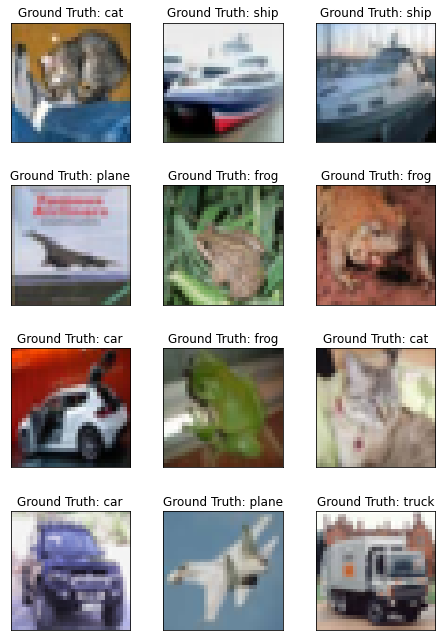

In [13]:
# View some examples

img_subset = 1 # mnist or mnist_2
if img_subset == 1:
    examples = enumerate(test_loader)
elif img_subset == 2:
    examples = enumerate(test_loader_2)
batch_idx, (example_data, example_targets) = next(examples)

print('Example data shape:', example_data.shape)

fig = plt.figure(figsize=(6.4, 9.6))

if data_type == 'CIFAR':
    example_data = example_data / 2 + 0.5 # unnormalize
    example_data_np = example_data.numpy()
    example_data_np = np.transpose(example_data_np, (0, 2, 3, 1))

for i in range(12):
    plt.subplot(4,3,i+1)
    plt.tight_layout()
    if data_type == 'CIFAR':
        plt.imshow(example_data_np[i],  interpolation='none')
    elif data_type == 'MNIST':
        plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Ground Truth: {}".format(class_labels[data_params['subset_idxs'][example_targets[i]]]))
    plt.xticks([])
    plt.yticks([])
fig.show()

# -----


# def imshow(img):
#     img = img / 2 + 0.5     # unnormalize
#     npimg = img.numpy()
#     plt.imshow(np.transpose(npimg, (1, 2, 0)))
#     plt.show()


# # get some random training images
# dataiter = iter(trainloader)
# images, labels = dataiter.next()

# # show images
# imshow(torchvision.utils.make_grid(images))
# # print labels
# print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

### Build the network

In [4]:
import math

class MaskLinearLayer(nn.Module):
    """ Custom linear layer which handles specialized dropouts """
    def __init__(self, size_in, size_out, train_params):
        super().__init__()
        self.size_in, self.size_out = size_in, size_out
        weight = torch.Tensor(size_out, size_in)
        self.weight = nn.Parameter(weight) 
        bias = torch.Tensor(size_out)
        self.bias = nn.Parameter(bias)

        self.cuda = train_params['cuda']

        # initialize weights and biases
        nn.init.kaiming_uniform_(self.weight, a=math.sqrt(5)) # weight init
        fan_in, _ = nn.init._calculate_fan_in_and_fan_out(self.weight)
        bound = 1 / math.sqrt(fan_in)
        nn.init.uniform_(self.bias, -bound, bound)  # bias init

        # initialize the masks
        self.dropout_type = train_params['dropout_type']
        self.dropout_p = train_params['dropout_p']

        if self.dropout_type in ('weights', 'weights_targeted',):
            self.mask = torch.ones(self.weight.shape).to(device)
        elif self.dropout_type in ('nodes', 'nodes_norm', 'nodes_targeted', 'mgn'):
            self.mask = torch.ones(self.weight.shape)
            self.bias_mask = torch.ones(self.bias.shape) # 50
            if self.cuda:
                    self.mask, self.bias_mask = self.mask.to(device), self.bias_mask.to(device)

    def forward(self, x, noise_params):

        if self.dropout_type in ('weights', 'weights_targeted',):    
            if noise_params['refresh_dropout']:
                if self.dropout_type == 'weights': # Uniform random
                    self.mask = (torch.rand(self.mask.shape) > 
                                 self.dropout_p * torch.ones(self.mask.shape)).int().to(device)
                elif self.dropout_type == 'weights_targeted':
                    self.mask = (torch.rand(self.mask.shape) > 
                                 noise_params['weight_dropout_perc']).int().to(device)
                # print('Total weights dropped:', np.sum(1 - self.mask.cpu().numpy()))

            w_times_x= torch.mm(x, torch.multiply(self.mask, self.weight).t()) 
            
            return torch.add(w_times_x, self.bias)
         
        elif self.dropout_type in ('nodes', 'nodes_norm', 'nodes_targeted', 'mgn'): # Zeros out incoming weights and bias
            if noise_params['refresh_dropout']:
                if self.dropout_type in ('nodes', 'nodes_norm',): # Uniform random
                    node_mask = (torch.rand(self.bias_mask.shape) > 
                                 self.dropout_p * torch.ones(self.bias_mask.shape)).int()
                    if self.dropout_type == 'nodes': # No renormalization
                        node_weight = 1.0
                    elif self.dropout_type == 'nodes': # Renormalizes nodes based on p
                        node_weight = 1.0 / (1- self.dropout_p)

                    self.mask = node_weight * (torch.ones(self.mask.shape).T * node_mask).T
                    self.bias_mask = node_mask
                elif self.dropout_type == 'nodes_targeted': 
                    # print(torch.rand(self.bias_mask.shape).get_device())
                    # print(noise_params['node_dropout_perc'].get_device())

                    node_mask = (torch.rand(self.bias_mask.shape) > 
                                 noise_params['node_dropout_perc']).int()

                    self.mask = (torch.ones(self.mask.shape).T * node_mask).T
                    self.bias_mask = node_mask

                if self.cuda:
                    self.mask, self.bias_mask = self.mask.to(device), self.bias_mask.to(device)
            
            w_times_x= torch.mm(x, torch.multiply(self.mask, self.weight).t()) 
            masked_bias = torch.multiply(self.bias_mask, self.bias)

            if self.dropout_type == 'mgn': # Just multiplies the preactiviation directly
                node_mask = torch.normal(torch.ones(self.bias_mask.shape), 
                                         self.dropout_p).to(device)
                return torch.multiply(torch.add(w_times_x, masked_bias),
                                      node_mask) 
            else:
                return torch.add(w_times_x, masked_bias)
        else: # No dropout
            w_times_x= torch.mm(x, self.weight.t())
            return torch.add(w_times_x, self.bias)

class MNISTNet(nn.Module):
    def __init__(self, network_params, train_params):
        self.n_outputs = network_params['n_outputs']

        super(MNISTNet, self).__init__()
        # nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0)
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        # 1 x 28 x 28 -> 10 x 24 x 24
        # Max pool2d(., 2) -> 10 x 12 x 12
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        # 10 x 12 x 12 -> 20 x 8 x 8
        # Max pool2d(., 2) -> 20 x 4 x 4
        # 20 x 4 x 4 = 320
        self.drop_layer = MaskLinearLayer(20 * 4 * 4, 50, train_params)
        self.readout = nn.Linear(50, self.n_outputs)

    def update_dropout(self, new_p):
        self.dropout_p = new_p
        # self.mask = (torch.rand(self.mask.shape) > new_p * torch.ones(self.mask.shape)).int()

    def forward(self, x, noise_params, outputs='final'):
        
        x = self.conv1(x)
        x = F.relu(F.max_pool2d(x, 2))
        x = self.conv2(x)
        # x = F.dropout2d(x, p=0.5, training=True)
        conv_out = F.relu(F.max_pool2d(x, 2))
        
        x = conv_out.view(-1, 320)

        x = self.drop_layer(x, noise_params)
        
        # Add noise directly to the feat_out vector (before relu activation)
        if noise_params['noise_type'] == 'feature':
            x += torch.normal(
                torch.zeros(x.shape), 
                noise_params['noise_variance']).to(device) 

        feat_out = F.relu(x)

        x = self.readout(feat_out)

        if outputs=='final':
            return F.log_softmax(x, dim=-1)
        elif outputs=='conv':
            return F.log_softmax(x, dim=-1), conv_out
        elif outputs=='feat':
            return F.log_softmax(x, dim=-1), feat_out

class CIFARNet(nn.Module):
    def __init__(self, network_params, train_params):
        self.n_outputs = network_params['n_outputs']

        super(CIFARNet, self).__init__()

        self.conv1 = nn.Conv2d(3, 6, kernel_size=5)
        # 3 x 32 x 32 -> 6 x 28 x 28
        # Max pool2d(., 2) -> 6 x 14 x 14
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        # 6 x 14 x 14 -> 16 x 10 x 10
        # Max pool2d(., 2) -> 16 x 5 x 5
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        
        # # Regular sized feature space, used for paper
        # self.drop_layer = MaskLinearLayer(120, 84, train_params)
        # # self.fc1 = MaskLinearLayer(16 * 5 * 5, 120, train_params)
        # # self.drop_layer = nn.Linear(120, 84)
        # self.readout = nn.Linear(84, self.n_outputs)

        # Difference size feature space, used for consistency check
        print('RUNNING DIFF SIZE NETWORK, THIS WAS NOT USED FOR MAIN PAPER RESULTS')
        self.drop_layer = MaskLinearLayer(120, 56, train_params)
        # self.fc1 = MaskLinearLayer(16 * 5 * 5, 120, train_params)
        # self.drop_layer = nn.Linear(120, 84)
        self.readout = nn.Linear(56, self.n_outputs)

    def update_dropout(self, new_p):
        self.dropout_p = new_p
        # self.mask = (torch.rand(self.mask.shape) > new_p * torch.ones(self.mask.shape)).int()

    def forward(self, x, noise_params, outputs='final'):
        
        x = self.conv1(x)
        x = F.relu(F.max_pool2d(x, 2))
        x = self.conv2(x)
        # x = F.dropout2d(x, p=self.dropout_p, training=self.training)
        conv_out = F.relu(F.max_pool2d(x, 2))
        
        x = conv_out.view(-1, 16 * 5 * 5) # flatten all dimensions except batch

        # x = F.relu(self.fc1(x, noise_params))
        x = F.relu(self.fc1(x))
        
        # feat_out = F.relu(self.drop_layer(x))
        x = self.drop_layer(x, noise_params)
        
        # Add noise directly to the feat_out vector (before relu activation)
        if noise_params['noise_type'] == 'feature':
            x += torch.normal(
                torch.zeros(x.shape), 
                noise_params['noise_variance']).to(device) 

        feat_out = F.relu(x)
        # x = F.dropout(feat_out, p=self.dropout_p, training=self.training)
        x = self.readout(feat_out)

        if outputs=='final':
            return F.log_softmax(x, dim=-1)
        elif outputs=='conv':
            return F.log_softmax(x, dim=-1), conv_out
        elif outputs=='feat':
            return F.log_softmax(x, dim=-1), feat_out

In [5]:
import pickle

def train(network, epoch, train_params, data_params, verbose=False):
    
    noise_params  = {
        'noise_type': train_params['noise_type'],    
        'noise_variance': train_params['noise_variance'],
    }
    network.train()

    # Lists to store test data
    targets_epoch, feat_outs_epoch = [], []
    readout_w_epoch, readout_b_epoch = [], []

    if train_params['switch_datasets'] and epoch >= train_params['switch_epoch']:
        train_dataset_loader = train_loader_2
    else:
        train_dataset_loader = train_loader

    for batch_idx, (data, target) in enumerate(train_dataset_loader):    

        if batch_idx % train_params['dropout_period'] == 0:
            noise_params['refresh_dropout'] = True
        else:
            noise_params['refresh_dropout'] = False

        if train_params['dropout_type'] in ('nodes_targeted',):
            noise_params['node_dropout_perc'] = train_params['node_dropout_perc']
        elif train_params['dropout_type'] in ('weights_targeted',):
            noise_params['weight_dropout_perc'] = train_params['weight_dropout_perc']

        if train_params['cuda']:
            data, target = data.to(device), target.to(device)
        # This will zero out the gradients for this batch. 
        optimizer.zero_grad()
        output = network(data, noise_params)
        # Calculate the loss The negative log likelihood loss.
        loss = F.nll_loss(output, target)
        # dloss/dx for every parameter 
        loss.backward()
        
        # Adds noise to the drop_layer gradients
        if train_params['noise_type'] == 'gradient':
            network.drop_layer.weight.grad += torch.normal(
                torch.zeros(network.drop_layer.weight.grad.shape), 
                train_params['noise_variance']).to(device)
            network.drop_layer.bias.grad += torch.normal(
                torch.zeros(network.drop_layer.bias.grad.shape), 
                train_params['noise_variance']).to(device)    
        # for p in network.parameters():
        #     p.grad += torch.normal(torch.zeros(p.grad.shape), 1).to(device)
            # grads.append(p.grad.detach())
            # print('Var grad:', np.var(p.grad.detach().cpu().numpy()))
        # do a one-step update on our parameters.

        optimizer.step()
        if batch_idx % train_params['log_interval'] == 0:
            if verbose:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(data), len(train_loader.dataset),
                    100. * batch_idx / len(train_loader), loss.item()))
            train_losses.append(loss.item())
            train_counter.append(
                (batch_idx*train_params['batch_size_train'])/len(train_loader.dataset) + (epoch-1))
        #   torch.save(network.state_dict(), '/results/model.pth')
        #   torch.save(optimizer.state_dict(), '/results/optimizer.pth')
        
        if batch_idx in train_params['test_batch_idxs'] and epoch > train_params['save_thresh']: # Performs testing
            targets_test, feat_outs_test = test(network, batch_idx, epoch, train_params, 
                                                data_params, verbose=verbose)
            # readout_w_test, readout_b_test = (network.readout.weight.cpu().detach().numpy(),
            #                                   network.readout.bias.cpu().detach().numpy())
            readout_w_test, readout_b_test = (network.readout.weight.clone().detach(),
                                              network.readout.bias.clone().detach())
            targets_epoch.append(targets_test) 
            feat_outs_epoch.append(feat_outs_test)
            readout_w_epoch.append(readout_w_test)
            readout_b_epoch.append(readout_b_test)

            # Updates the dropout percentages
            if train_params['dropout_type'] in ('nodes_targeted',):
                if train_params['dropout_period'] != 1:
                    raise NotImplementedError('Need to be careful this works.')
                # Calculates covariance in feature space
                feat_cov = np.cov(feat_outs_epoch[-1].cpu().numpy().T)
                neruon_vars = np.array([feat_cov[i, i] for i in range(feat_cov.shape[0])])
                # neuron_var_perc = np.clip(20 * neruon_vars/np.sum(neruon_vars), 0, 1.0)
                neuron_var_perc = np.clip(42 * ((neruon_vars+1e-5)**(-1)/np.sum((neruon_vars+1e-5)**(-1))), 0, 1.0)
                # neuron_var_perc = 2*(1 - ndtr(15*np.abs(neruon_vars)))
                # print('Neuron dropouts:', neuron_var_perc)
                print('Dropped weights: {:.2f}, equiv uniform: {:.2f}, Max var perc: {:.3f}'.format(
                    np.sum(neuron_var_perc), 
                    np.sum(neuron_var_perc)/np.prod(neuron_var_perc.shape),
                    np.max(20 * neruon_vars/np.sum(neruon_vars))))

                train_params['node_dropout_perc'] = torch.tensor(neuron_var_perc)
            elif train_params['dropout_type'] in ('weights_targeted',):
                if train_params['dropout_period'] != 1:
                    raise NotImplementedError('Need to be careful this works.')
                weight_vals = network.drop_layer.weight.detach().cpu().numpy()

                # weight_perc = np.abs(weight_vals)/np.linalg.norm(np.abs(weight_vals))
                weight_perc = 2*(1 - ndtr(15*np.abs(weight_vals)))

                # print('Total drop perc:', np.sum(weight_perc))
                # print('Max drop:', np.max(weight_perc))
                print('Equivalent uniform: {:.2f}'.format(np.sum(weight_perc)/np.prod(weight_perc.shape)))
                # print('Max weight mag:', np.max(np.abs(weight_vals)))
                train_params['weight_dropout_perc'] = torch.tensor(weight_perc)

    return targets_epoch, feat_outs_epoch, readout_w_epoch, readout_b_epoch
            

def test(network, batch_idx, epoch, train_params, data_params, verbose=False):
    network.eval()
    test_loss = 0
    correct = 0

    noise_params  = {
        'refresh_dropout': False,
        'noise_type': train_params['noise_type'],    
        'noise_variance': train_params['noise_variance'],
    }
    if train_params['dropout_type'] in ('nodes_targeted',):
        noise_params['node_dropout_perc'] = train_params['node_dropout_perc']
    elif train_params['dropout_type'] in ('weights_targeted',):
        noise_params['weight_dropout_perc'] = train_params['weight_dropout_perc']

    # print(network.fc1_bias_mask)
    # print('Percent zero weights:', 
    #       np.sum(network.fc1.weight.detach().numpy() == 0)/np.prod(network.fc1.weight.shape))

    feat_outs = []
    targets = []
    with torch.no_grad():
        if train_params['switch_datasets'] and epoch >= train_params['switch_epoch']:
            test_dataset_loader = test_loader_2
        else:
            test_dataset_loader = test_loader

        for data, target in test_dataset_loader:
            
            if train_params['cuda']:
                data, target = data.to(device), target.to(device)

            output, feat_out = network(data, noise_params, outputs='feat')
            feat_outs.append(feat_out)
            targets.append(target)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.data.view_as(pred)).long().cpu().sum()
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    test_counter.append(
                (batch_idx*train_params['batch_size_train'])/len(train_loader.dataset) + (epoch-1))
    accuracies.append(correct / len(test_loader.dataset))
    if verbose:
        print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
            test_loss, correct, len(test_loader.dataset),
            100. * correct / len(test_loader.dataset)))
        
    feat_outs = torch.cat(feat_outs, dim=0)
    targets = torch.cat(targets, dim=0)
    
    return targets, feat_outs

def save_data_summary(path, feat_outs, targets, accuracies, readout_w, readout_b):

    save_the_file = True

    if os.path.exists(path):
        print('File already exists at:', path)
        override = input('Override? (Y/N):')
        if override == 'Y':
            save_the_file = True
        else:
            save_the_file = False

    if save_the_file:
        with open(path, 'wb') as save_file:
            pickle.dump(feat_outs, save_file, protocol=pickle.HIGHEST_PROTOCOL)
            pickle.dump(targets, save_file, protocol=pickle.HIGHEST_PROTOCOL)
            pickle.dump(accuracies, save_file, protocol=pickle.HIGHEST_PROTOCOL)
            pickle.dump(readout_w, save_file, protocol=pickle.HIGHEST_PROTOCOL)
            pickle.dump(readout_b, save_file, protocol=pickle.HIGHEST_PROTOCOL)

            pickle.dump(test_counter, save_file, protocol=pickle.HIGHEST_PROTOCOL)
            pickle.dump(test_losses, save_file, protocol=pickle.HIGHEST_PROTOCOL)
            pickle.dump(train_counter, save_file, protocol=pickle.HIGHEST_PROTOCOL)
            pickle.dump(train_losses, save_file, protocol=pickle.HIGHEST_PROTOCOL)
        print('Data Saved')
    else:
        print('Data Not Saved')

def load_data_summary(root_path, random_seed, train_params, data_params):

    save_string = get_save_string_summary(random_seed, train_params, data_params)
    path = root_path + save_string + '.pickle'

    if not os.path.exists(path):
        raise ValueError('No file at path:', path)
    else:
        with open(path, 'rb') as load_file:
            feat_outs_load = pickle.load(load_file)
            targets_load = pickle.load(load_file)
            accuracies_load = pickle.load(load_file)
            readout_w_load = pickle.load(load_file)
            readout_b_load = pickle.load(load_file)

            try:
                test_counter = pickle.load(load_file)
                test_losses = pickle.load(load_file)
                train_counter = pickle.load(load_file)
                train_losses = pickle.load(load_file)

                return feat_outs_load, targets_load, accuracies_load, readout_w_load, readout_b_load, test_counter, test_losses, train_counter, train_losses

            except EOFError:
                return feat_outs_load, targets_load, accuracies_load, readout_w_load, readout_b_load

def get_save_string_summary(random_seed, train_params, data_params):
    """ Returns a unique string identifier for the data """

    class_str = [str(i) for i in data_params['subset_idxs']]
    class_str = ''.join(class_str)

    if train_params['noise_type'] == 'gradient':
        if train_params['noise_variance'] == 1.0:
            noise_str = 'noise_gradient_var1e0'
        elif train_params['noise_variance'] == 0.1:
            noise_str = 'gradient_var1e-1'
        else:
            noise_str = 'noise_gradient_var{:.0e}'.format(train_params['noise_variance'])
    elif train_params['noise_type'] == 'feature':
        if train_params['noise_variance'] == 1.0:
            noise_str = 'noise_feature_var1e0'
        elif train_params['noise_variance'] == 0.1:
            noise_str = 'noise_feature_var1e-1'
        else:
            noise_str = 'noise_feature_var{:.0e}'.format(train_params['noise_variance'])
    else:
        if train_params['dropout_p'] == 1.0:
            p_str = '1e0'
        elif train_params['dropout_p'] == 0.9:
            p_str = '9e-1'
        elif train_params['dropout_p'] == 0.8:
            p_str = '8e-1'
        elif train_params['dropout_p'] == 0.75:
            p_str = '75e-2'
        elif train_params['dropout_p'] == 0.7:
            p_str = '7e-1'
        elif train_params['dropout_p'] == 0.6:
            p_str = '6e-1'
        elif train_params['dropout_p'] == 0.5:
            p_str = '5e-1'
        elif train_params['dropout_p'] == 0.4:
            p_str = '4e-1'
        elif train_params['dropout_p'] == 0.3:
            p_str = '3e-1'
        elif train_params['dropout_p'] == 0.2:
            p_str = '2e-1'
        elif train_params['dropout_p'] == 0.1:
            p_str = '1e-1'
        elif train_params['dropout_p'] == 0.0:
            p_str = '0'
        else:
            p_str = '{:.0e}'.format(train_params['dropout_p'])
        noise_str = ('dropout_' + train_params['dropout_type'] + '_p' + p_str + 
                     '_period' + str(train_params['dropout_period']))

    if train_params['l2_reg'] == 1e-2:
        l2_str = '1e-2'
    elif train_params['l2_reg'] == 1e-3:
        l2_str = '1e-3'
    elif train_params['l2_reg'] == 1e-4:
        l2_str = '1e-4'
    else:
        raise NotImplementedError('L2 value not implemented in save')

    if train_params['learning_rate'] == 1e-2:
        lr_str = '1e-2'
    elif train_params['learning_rate'] == 1e-3:
        lr_str = '1e-3'
    elif train_params['learning_rate'] == 1e-4:
        lr_str = '1e-4'
    else:
        raise NotImplementedError('L2 value not implemented in save')

    return (train_params['data_type'] + '_classes' + class_str + '_' + noise_str + '_seed' + str(random_seed) + 
            '_epochs' + str(train_params['n_epochs']) + '_l2' + l2_str + 
            '_testfreq' + str(train_params['test_freq']) + '_lr' + lr_str)

def sig_fig_round(x):
    """ For rounding variance values to nice numbers """
    return np.round(x, -1 * np.floor(np.log10(np.abs(x))).astype(np.int))

#### Train/Load the network(s)

In [66]:
from scipy.special import ndtr # Gaussian CDF 

n_trials = 5
verbose = False

train_params = {
    'data_type': data_type,

    'n_epochs': 80,
    'batch_size_train': 64,
    'batch_size_test': 1000,
    'learning_rate': 1e-3,
    'momentum': 0.9,
    'l2_reg': 1e-3,

    'dropout_type': 'nodes', # weights, nodes, nodes_norm, weights_targeted, nodes_targeted, mgn
    # np.array([sig_fig_round(val) for val in np.logspace(-3, 1, num=n_trials)])
    'dropout_p': 0.5, #np.round(np.linspace(0.1, 0.9, n_trials), decimals=1), # For mgn, serves as variance
    'dropout_period': 1, # number of batches to hold the same dropout pattern
    # 1: regular dropout, updated every (training) forward pass
    # > len(train_loader): only update dropout pattern once per batch
    'test_freq': 10, # number of times per epoch to evaluate test data 
    'log_interval': 100,

    'noise_type': None, #gradient, feature, None (types of direction noise injection)
    'noise_variance': 0.1, #np.array([sig_fig_round(val) for val in np.logspace(-3, 1, num=n_trials)]),

    'save_thresh': 70, # Number of epochs to start saving data at (and sampling more frequently)

    'switch_datasets': False,
    'switch_epoch': 25,

    'cuda': True,
}

# root_path = '/content/drive/MyDrive/neuro_research/visual_change_drift/summary_data/'
# root_path = '/content/drive/MyDrive/neuro_research/visual_change_drift/summary_data/smallfeature_'
root_path = '/content/drive/MyDrive/neuro_research/visual_change_drift/summary_data/largefeature_'
save_summary_data = False
load_summary_data = True

random_seed_start = 0

# Only saves feature space representations from a subset of the data.
save_only_subset = True
save_subset = [2, 6]

if train_params['cuda']:
    print('Using CUDA...')
    device = torch.device('cuda')
else:
    print('Using CPU...')
    device = torch.device('cpu')

if train_params['switch_datasets']:
    raise NotImplementedError('Need to change test batches if multiple datasets')
else:
    n_batches = len(train_loader)
    train_params['test_batch_idxs'] = np.floor(np.linspace(0, n_batches, train_params['test_freq']+1)[1:] - 1)
    print(f'Testing at batches idxs (total: {n_batches}):', train_params['test_batch_idxs'])


network_params = {
    'n_outputs': len(data_params['subset_idxs']),
}

feat_outs_experiments = []
targets_experiments = []
accuracies_experiments = []
readout_w_experiments = []
readout_b_experiments = []

train_counter_experiments = []
test_counter_experiments = []
train_losses_experiments = []
test_losses_experiments = []

if train_params['noise_type'] == 'gradient':
    print('Adding noise to gradients. Variance:',
        train_params['noise_variance']
    )
elif train_params['noise_type'] == 'feature':
    print('Adding noise to directly to features. Variance:',
        train_params['noise_variance']
    )
elif train_params['dropout_type'] in ('weights', 'nodes', 'weights_targeted', 'nodes_targeted', 'mgn'):
    print('Using dropout type noise with p = ', train_params['dropout_p'])
else:
    print('Noise type not recognized, not adding any.')

p_values = np.ones((n_trials,))
sigma_values = np.ones((n_trials,))
# For paramters that can change from one trial to the next
if type(train_params['dropout_p']) == np.ndarray:
    print('Testing many values of p.')
    assert train_params['dropout_p'].shape[0] == n_trials
    p_values = np.copy(train_params['dropout_p'])
    sigma_values = train_params['noise_variance'] * sigma_values
elif type(train_params['noise_variance']) == np.ndarray:
    print('Testing many values of sigma.')
    assert train_params['noise_variance'].shape[0] == n_trials
    p_values = train_params['dropout_p'] * p_values
    sigma_values = np.copy(train_params['noise_variance'])
else:
    print('p and sigma are constant.')
    p_values = train_params['dropout_p'] * p_values
    sigma_values = train_params['noise_variance'] * sigma_values

for trial in range(n_trials):    
    # For reproducability
    random_seed = random_seed_start + trial
    # Disables nondeterministic algorithms from cudnn
    torch.backends.cudnn.enabled = False
    torch.manual_seed(random_seed)
    
    # Sets p and sigma if scanning over values
    train_params['dropout_p'] = p_values[trial]
    train_params['noise_variance'] = sigma_values[trial]

    print(20*'-' + f' Trial: {trial} Seed: {random_seed} ' + 20*'-')

    if load_summary_data:
        save_string = get_save_string_summary(random_seed, train_params, data_params)
        path = root_path + save_string + '.pickle'
        
        if os.path.exists(path):
            print('Loading from path:', path)
            
            try: # Try the larger unpack first (for later data that was saved with more params)
                (feat_outs_load, targets_load, accuracies_load, readout_w_load, 
                readout_b_load, test_counter_load, test_losses_load, 
                train_counter_load, train_losses_load) = load_data_summary(
                    root_path, random_seed, train_params, data_params)
                
                train_counter_experiments.append(train_counter_load)
                test_counter_experiments.append(test_counter_load)
                train_losses_experiments.append(train_losses_load)
                test_losses_experiments.append(test_losses_load)
            except ValueError:
                feat_outs_load, targets_load, accuracies_load, readout_w_load, readout_b_load = load_data_summary(
                    root_path, random_seed, train_params, data_params)
            
            feat_outs_experiments.append(feat_outs_load)
            targets_experiments.append(targets_load)

            accuracies_experiments.append(accuracies_load)

            readout_w_experiments.append(readout_w_load)
            readout_b_experiments.append(readout_b_load)
            
            continue # Skips rest of loop since data doesn't need to be recalculated
        else:
            print('Loaded data not found at: ', path)

    train_losses = []
    train_counter = []
    test_losses = []
    test_counter = []
    # test_counter = [i*len(train_loader.dataset)/train_params['test_freq'] for i 
    #                 in range(train_params['test_freq']*train_params['n_epochs'] + 1)]
    accuracies = []

    feat_outs = []
    targets = []
    readout_w = []
    readout_b = []

    network_params['dropout_p'] = train_params['dropout_p']

    if data_type == 'MNIST':
        network = MNISTNet(network_params, train_params)
    elif data_type == 'CIFAR':
        network = CIFARNet(network_params, train_params)
    if train_params['cuda']:
        network.to(device)

    optimizer = optim.SGD(network.parameters(), lr=train_params['learning_rate'],
                        momentum=train_params['momentum'],
                        weight_decay=train_params['l2_reg'])
    
    if train_params['dropout_type'] in ('nodes_targeted',):
        train_params['node_dropout_perc'] = torch.zeros(network.drop_layer.weight.shape[0])
    elif train_params['dropout_type'] in ('weights_targeted',):
        train_params['weight_dropout_perc'] = torch.zeros(network.drop_layer.weight.shape)

    targets_init, feat_outs_init = test(network, 0, 1, train_params, data_params,
                                        verbose=verbose)
    readout_w_init, readout_b_init = (network.readout.weight,
                                      network.readout.bias)

    if save_only_subset:
        print('Only saving a subset of targets.')
        target_filter = np.array([target in save_subset for target in targets_init.cpu().numpy()])
        feat_outs.append(feat_outs_init.cpu().numpy()[target_filter])
        targets.append(targets_init.cpu().numpy()[target_filter])
    else:
        feat_outs.append(feat_outs_init.cpu().numpy())
        targets.append(targets_init.cpu().numpy())
    readout_w.append(readout_w_init.cpu().detach().numpy())
    readout_b.append(readout_b_init.cpu().detach().numpy())
    for epoch in range(1, train_params['n_epochs'] + 1):
        train_outs = train(network, epoch, train_params, data_params, 
                           verbose=verbose)
        
        targets_epoch, feat_outs_epoch, readout_w_epoch, readout_b_epoch = train_outs

        if save_only_subset:
            feat_outs.extend([x.cpu().numpy()[target_filter] for x in feat_outs_epoch])
            targets.extend([x.cpu().numpy()[target_filter] for x in targets_epoch])
        else:
            feat_outs.extend([x.cpu().numpy() for x in feat_outs_epoch])
            targets.extend([x.cpu().numpy() for x in targets_epoch])
        readout_w.extend([x.cpu().numpy() for x in readout_w_epoch])
        readout_b.extend([x.cpu().numpy() for x in readout_b_epoch])

    print('\tTest set: Avg. loss: {:.4f}, Accuracy: {:.2f}%'.format(
        test_losses[-1], 100. * accuracies[-1]))

    feat_outs_experiments.append(feat_outs)
    targets_experiments.append(targets)
    accuracies_experiments.append(accuracies)

    readout_w_experiments.append(readout_w)
    readout_b_experiments.append(readout_b)

    train_counter_experiments.append(train_counter)
    test_counter_experiments.append(test_counter)
    train_losses_experiments.append(train_losses)
    test_losses_experiments.append(test_losses)

    if save_summary_data: 
        save_string = get_save_string_summary(random_seed, train_params, data_params)
        path = root_path + save_string + '.pickle'

        print('   Saving to path:', path)
        save_data_summary(path, feat_outs, targets, accuracies, readout_w, readout_b)

Using CUDA...
Testing at batches idxs (total: 782): [ 77. 155. 233. 311. 390. 468. 546. 624. 702. 781.]
Adding noise to gradients. Variance: 3.0
p and sigma are constant.
-------------------- Trial: 0 Seed: 0 --------------------
Loading from path: /content/drive/MyDrive/neuro_research/visual_change_drift/summary_data/CIFAR_classes0123456789_noise_gradient_var3e+00_seed0_epochs40_l21e-3_testfreq10_lr1e-3.pickle
-------------------- Trial: 1 Seed: 1 --------------------
Loading from path: /content/drive/MyDrive/neuro_research/visual_change_drift/summary_data/CIFAR_classes0123456789_noise_gradient_var3e+00_seed1_epochs40_l21e-3_testfreq10_lr1e-3.pickle
-------------------- Trial: 2 Seed: 2 --------------------
Loading from path: /content/drive/MyDrive/neuro_research/visual_change_drift/summary_data/CIFAR_classes0123456789_noise_gradient_var3e+00_seed2_epochs40_l21e-3_testfreq10_lr1e-3.pickle
-------------------- Trial: 3 Seed: 3 --------------------
Loading from path: /content/drive/MyDr

### Training evaluation

Looks at training metrics as a funciton of time to try to figure out when the accuracy has stabilized

Overfit time: 35.0


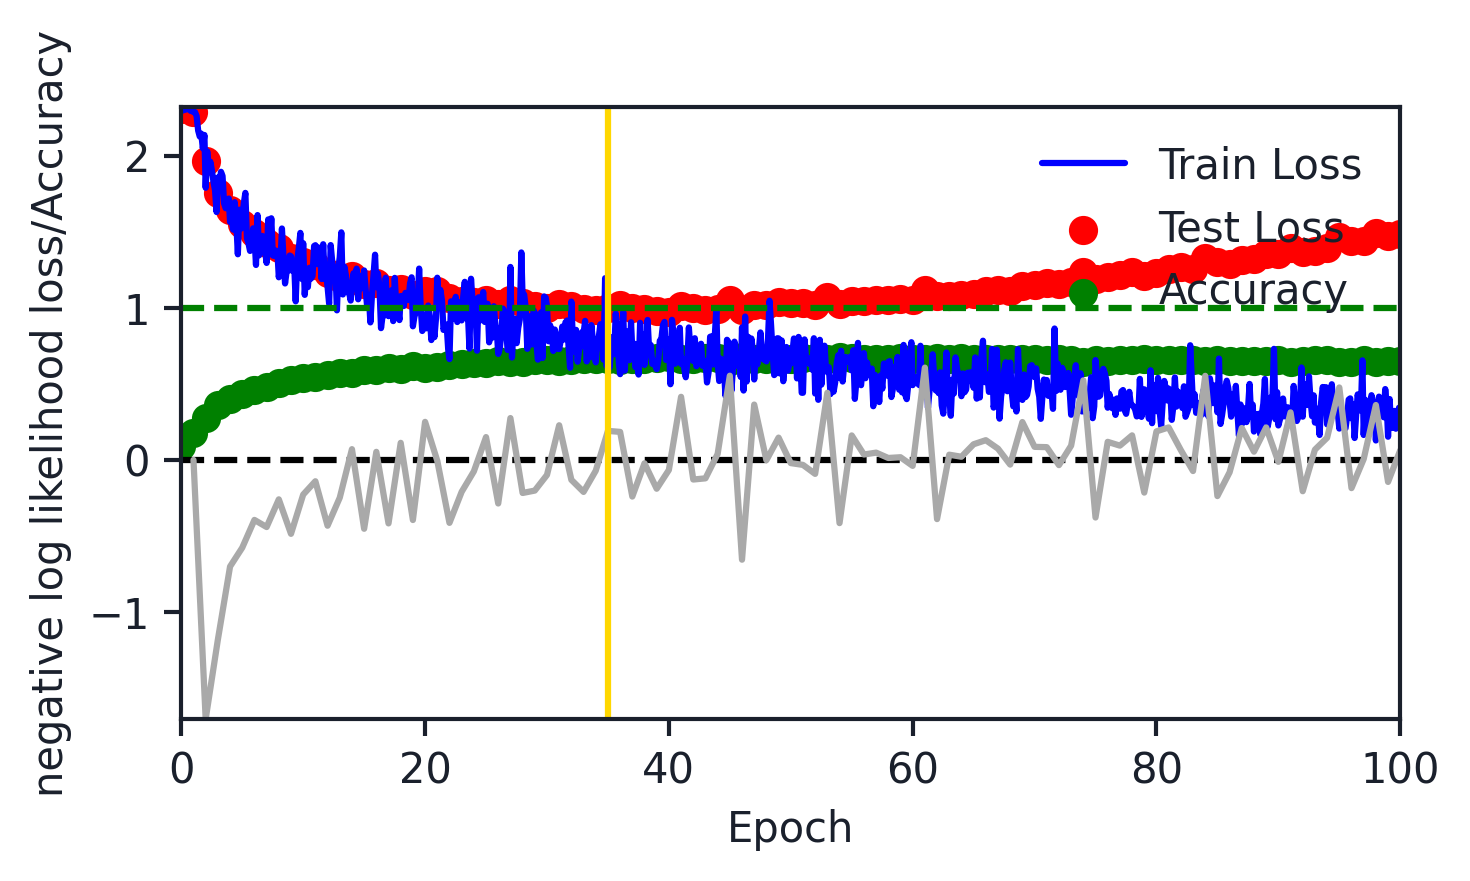

In [ ]:
exp_idx = 0

eval_epoch = [35,] # no noise
# eval_epoch = [30, 40, 40, 30, 30, 40, 55, 90, 90] # feature
# eval_epoch = [30, 30, 40, 30, 30, 30, 15, 20, 10] # gradient
# eval_epoch = [45, 50, 60, 60, 70, 80, 80, 80, 80] # nodes
# eval_epoch = [40, 50, 50, 60, 60, 70, 80, 90, 90] # weights
# eval_epoch = [35, 35, 45, 35, 35, 40, 45, 50, 35] # mgn


fig = plt.figure()
plt.plot(train_counter_experiments[exp_idx], 
         train_losses_experiments[exp_idx], color='blue')
plt.scatter(test_counter_experiments[exp_idx][:], 
            test_losses_experiments[exp_idx], color='red')
plt.scatter(test_counter_experiments[exp_idx][:], 
            accuracies_experiments[exp_idx], color='green')
plt.legend(['Train Loss', 'Test Loss', 'Accuracy'], loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('negative log likelihood loss/Accuracy')
plt.axhline(1.0, linestyle='dashed', color='green')
plt.axhline(0.0, linestyle='dashed', color='k')


# Computes test and train difference

overfit_thresh = 0.1

time_bins = np.linspace(1, train_params['n_epochs'], train_params['n_epochs'])
n_bins = len(time_bins)
train_time_bins = np.digitize(train_counter_experiments[exp_idx], bins=time_bins)
test_time_bins = np.digitize(test_counter_experiments[exp_idx], bins=time_bins)
test_train_diff = np.zeros((n_bins,))
delta_test = np.zeros((n_bins,))
test_loss_avg = np.zeros((n_bins,))

overfit_count = 0
overfit_time = None
for bin_idx in range(n_bins):
    # Only does 1: and add +1 to index to skip initial test
    train_loss_avg = np.mean(np.array(train_losses_experiments[exp_idx])[train_time_bins == bin_idx])
    test_loss_avg[bin_idx] = np.mean(np.array(test_losses_experiments[exp_idx])[test_time_bins == bin_idx])
    test_train_diff[bin_idx] = (test_loss_avg[bin_idx] - train_loss_avg) / test_loss_avg[bin_idx]
    if bin_idx == 0:
        delta_test[bin_idx] = 0
    else:
        delta_test[bin_idx] = (test_loss_avg[bin_idx] - test_loss_avg[bin_idx - 1])/test_loss_avg[bin_idx]
    
    # if test_train_diff[bin_idx] > overfit_thresh and overfit_time is None:
    if bin_idx > 10:
        if np.mean(delta_test[bin_idx-9:bin_idx+1]) > 0 and overfit_time is None:
            overfit_time = time_bins[bin_idx - 9]


plt.plot(time_bins, 10*delta_test, color='darkgrey')
if overfit_time is not None:
    plt.axvline(overfit_time, color='gold')
    print('Overfit time:', overfit_time)

fig.show()

In [ ]:
with torch.no_grad():
    analysis_data = example_data
    analysis_data = analysis_data.to(device)
    output, feat_out = network(analysis_data, outputs='feat')
    # # output, conv_out = network(test_data, outputs='conv')

TypeError: ignored

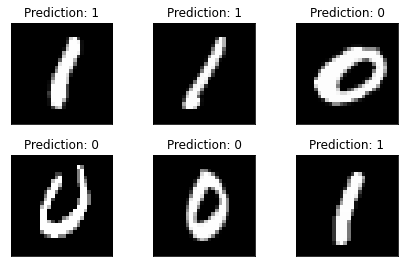

In [ ]:
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(analysis_data[i][0].cpu(), cmap='gray', interpolation='none')
  plt.title("Prediction: {}".format(
    output.data.max(1, keepdim=True)[1][i].item()))
  plt.xticks([])
  plt.yticks([])
fig.show()

PCA: [0.9596157  0.03072145 0.00435898 0.00183774 0.00125836] PR: 1.0847975599337332


(0.0, 1.1)

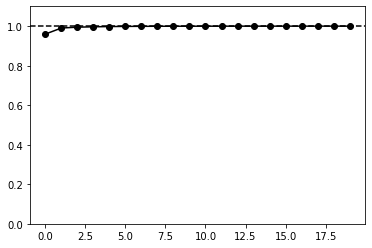

In [ ]:
def participation_ratio_vector(C):
    """Computes the participation ratio of a vector of variances."""
    return np.sum(C) ** 2 / np.sum(C*C)

pc_dims = 5
n_feat_space = 50

# Finds percentage of variance explained by top pc_dims of PCA
pca_full = PCA(n_components=n_feat_space)
feat_out_pca = pca_full.fit_transform(feat_out)
explained_var = pca_full.explained_variance_ratio_
print('PCA:', explained_var[:pc_dims], 'PR:', participation_ratio_vector(pca_full.explained_variance_))
total_exvar = []
for i in range(n_feat_space-1):
  total_exvar.append(np.sum(explained_var[:i+1]))
plt.figure()
plt.plot(total_exvar[:20], 'k-o')
plt.axhline(1.0, color='k', linestyle='dashed')
plt.ylim([0.0, 1.1])

In [ ]:
n_classes = 10
class_pca = [[] for _ in range(n_classes)]
for target, pca_vec in zip(example_targets, feat_out_pca):
    class_pca[target].append(pca_vec)

for idx, class_list in enumerate(class_pca):
    class_pca[idx] = np.array(class_list)
    print(f'Class {idx} shape:', class_pca[idx].shape)

Class 0 shape: (440, 50)
Class 1 shape: (560, 50)
Class 2 shape: (0,)
Class 3 shape: (0,)
Class 4 shape: (0,)
Class 5 shape: (0,)
Class 6 shape: (0,)
Class 7 shape: (0,)
Class 8 shape: (0,)
Class 9 shape: (0,)


Text(0, 0.5, 'PC: 1')

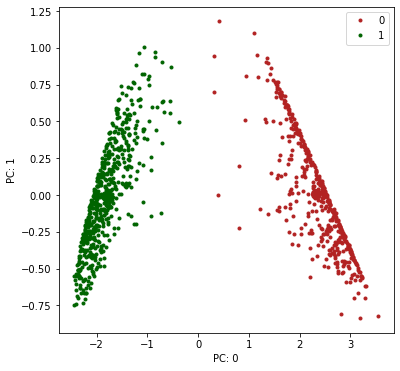

In [ ]:
pc0 = 0
pc1 = 1

fig, ax1 = plt.subplots(1, 1, figsize=(6,6))

for idx, class_matrix in enumerate(class_pca):
    if class_pca[idx].shape[0] > 0:
        ax1.plot(class_matrix[:, pc0], class_matrix[:, pc1], linewidth=0.0, marker='.', label=idx, color=class_colors[idx])
        class_center = np.mean(class_matrix, axis=0)
        ax1.plot(class_center[pc0], class_center[pc1], marker='o', markersize=10, color=class_colors[idx])

ax1.legend()
ax1.set_xlabel(f'PC: {pc0}')
ax1.set_ylabel(f'PC: {pc1}')

In [ ]:
for idx, class_matrix in enumerate(class_pca):
    pca_class = PCA(n_components=n_feat_space)
    _ = pca_class.fit_transform(class_matrix)

    class_center = np.mean(class_matrix, axis=0)
    cov_mat = 1/class_matrix.shape[0] * np.matmul(class_matrix.T, class_matrix) -  np.outer(class_center, class_center)
    eigvals, eigvecs = np.linalg.eig(cov_mat)       
    eigvals = eigvals / class_matrix.shape[0]

    print(f'Digit {idx} // PR: {participation_ratio_vector(pca_class.explained_variance_):.2f} // cov eig PR: {participation_ratio_vector(eigvals):.2f}')

NameError: ignored

### Drift Tests

Sorts feature vectors by traget and stores to array.

Feature outs is a nested list in order: [trial_idx][seq_idx][class_idx](n_test, feture_space_dim)

In [68]:
from sklearn.decomposition import PCA

def participation_ratio_vector(C):
    """Computes the participation ratio of a vector of variances."""
    return np.sum(C) ** 2 / np.sum(C*C)

def get_align(x, y):
     return np.dot(x,y)/(
         np.linalg.norm(x) * np.linalg.norm(y)
     )

n_times = len(feat_outs_experiments[0])
if save_only_subset:
    n_classes = len(save_subset)
    target_idxs = [save_subset.index(tar) if tar in save_subset else np.nan for tar in np.arange(10)]
else:
    n_classes = len(data_params['subset_idxs'])
    target_idxs = np.arange(10)
n_feats = feat_outs_experiments[0][0].shape[1]

for trial in range(n_trials):
    feature_vals = [[[] for _ in range(n_classes)] for _ in range(n_times)]

    feat_outs = feat_outs_experiments[trial]
    targets = targets_experiments[trial]

    for time_idx in range(n_times):
        target_vals = targets[time_idx]
        feat_vals = feat_outs[time_idx]
        for target, feat_val in zip(target_vals, feat_vals):
            feature_vals[time_idx][target_idxs[target]].append(feat_val)

    for time_idx in range(n_times):
        # print('Time {}:'.format(time_idx))
        for class_idx in range(n_classes):
            feature_vals[time_idx][class_idx] = np.array(feature_vals[time_idx][class_idx])
            # print('  Class {} size:'.format(class_idx), 
            #       feature_vals[time_idx][class_idx].shape)

    feat_outs_experiments[trial] = feature_vals

For each class, at each time step, for each trail, computes the PCA fit of its variational space. Then computes the drift metrics.

In [81]:
len(feature_vals)

10

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':


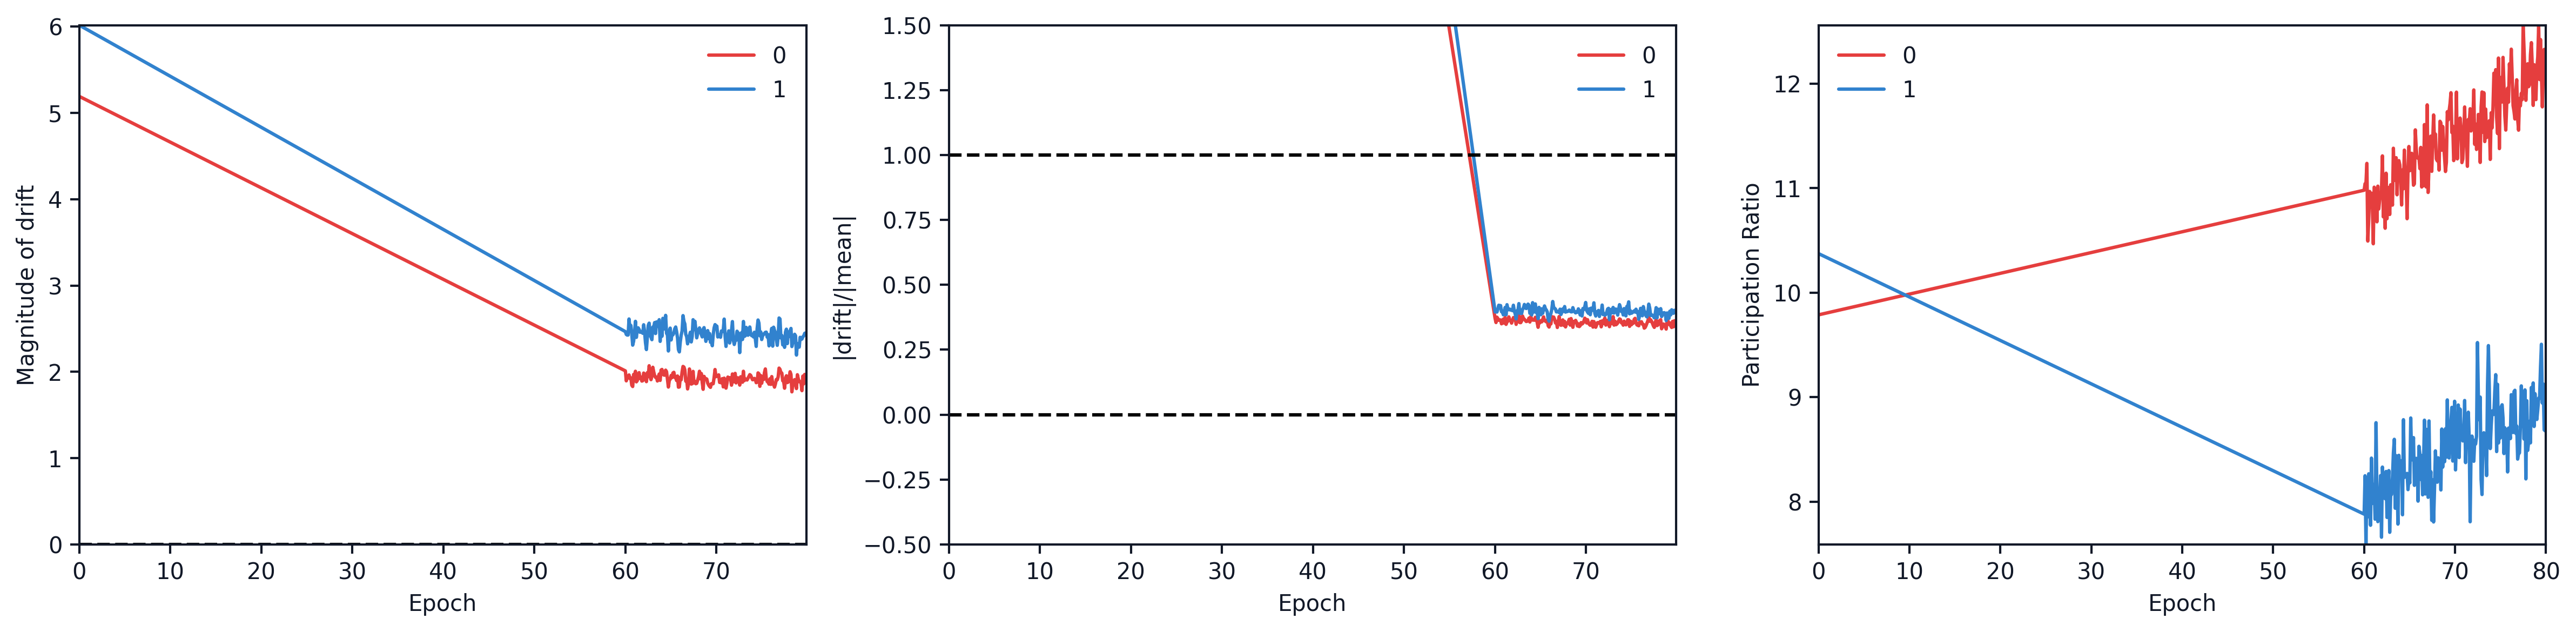

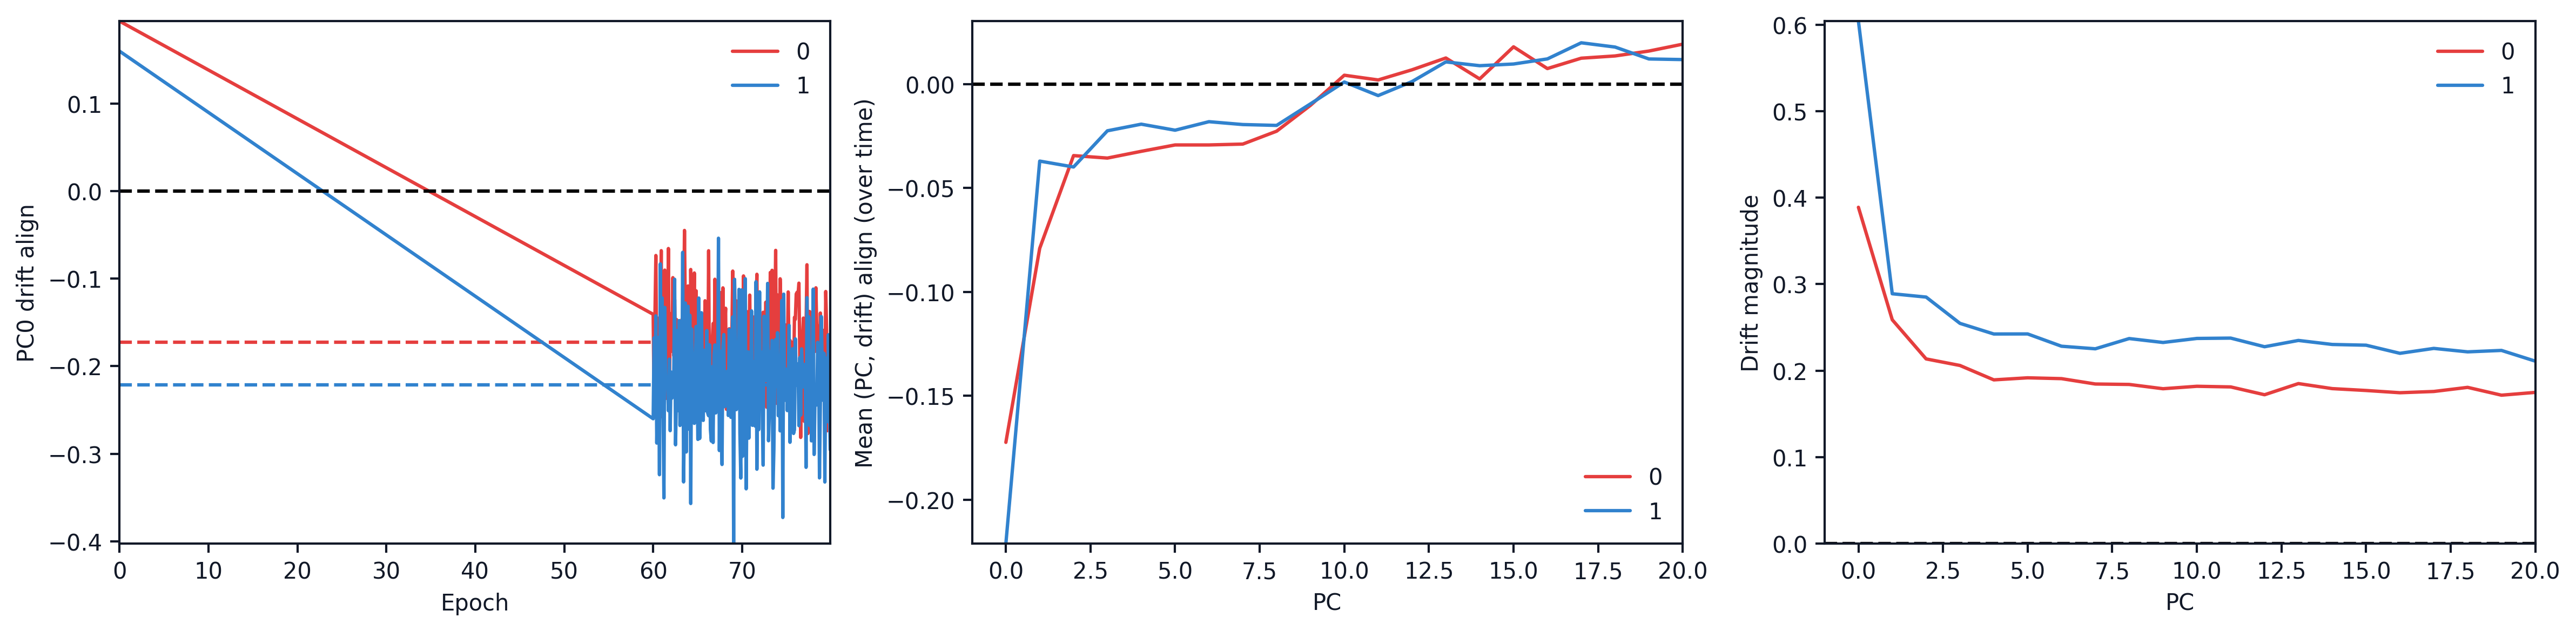

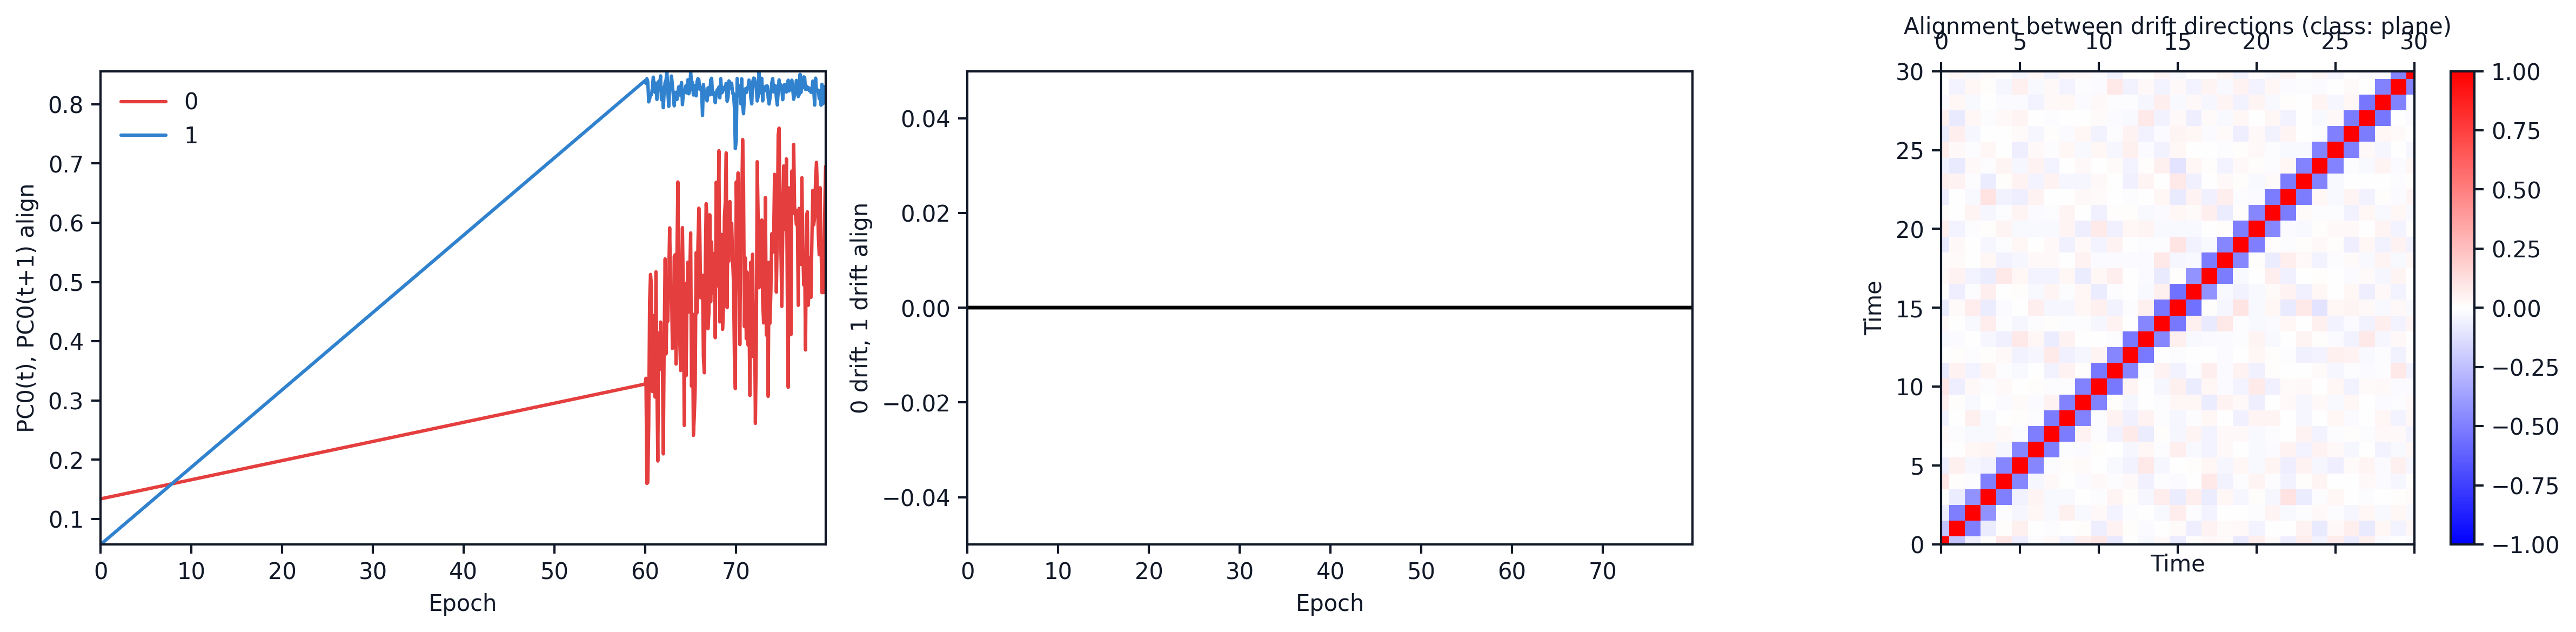

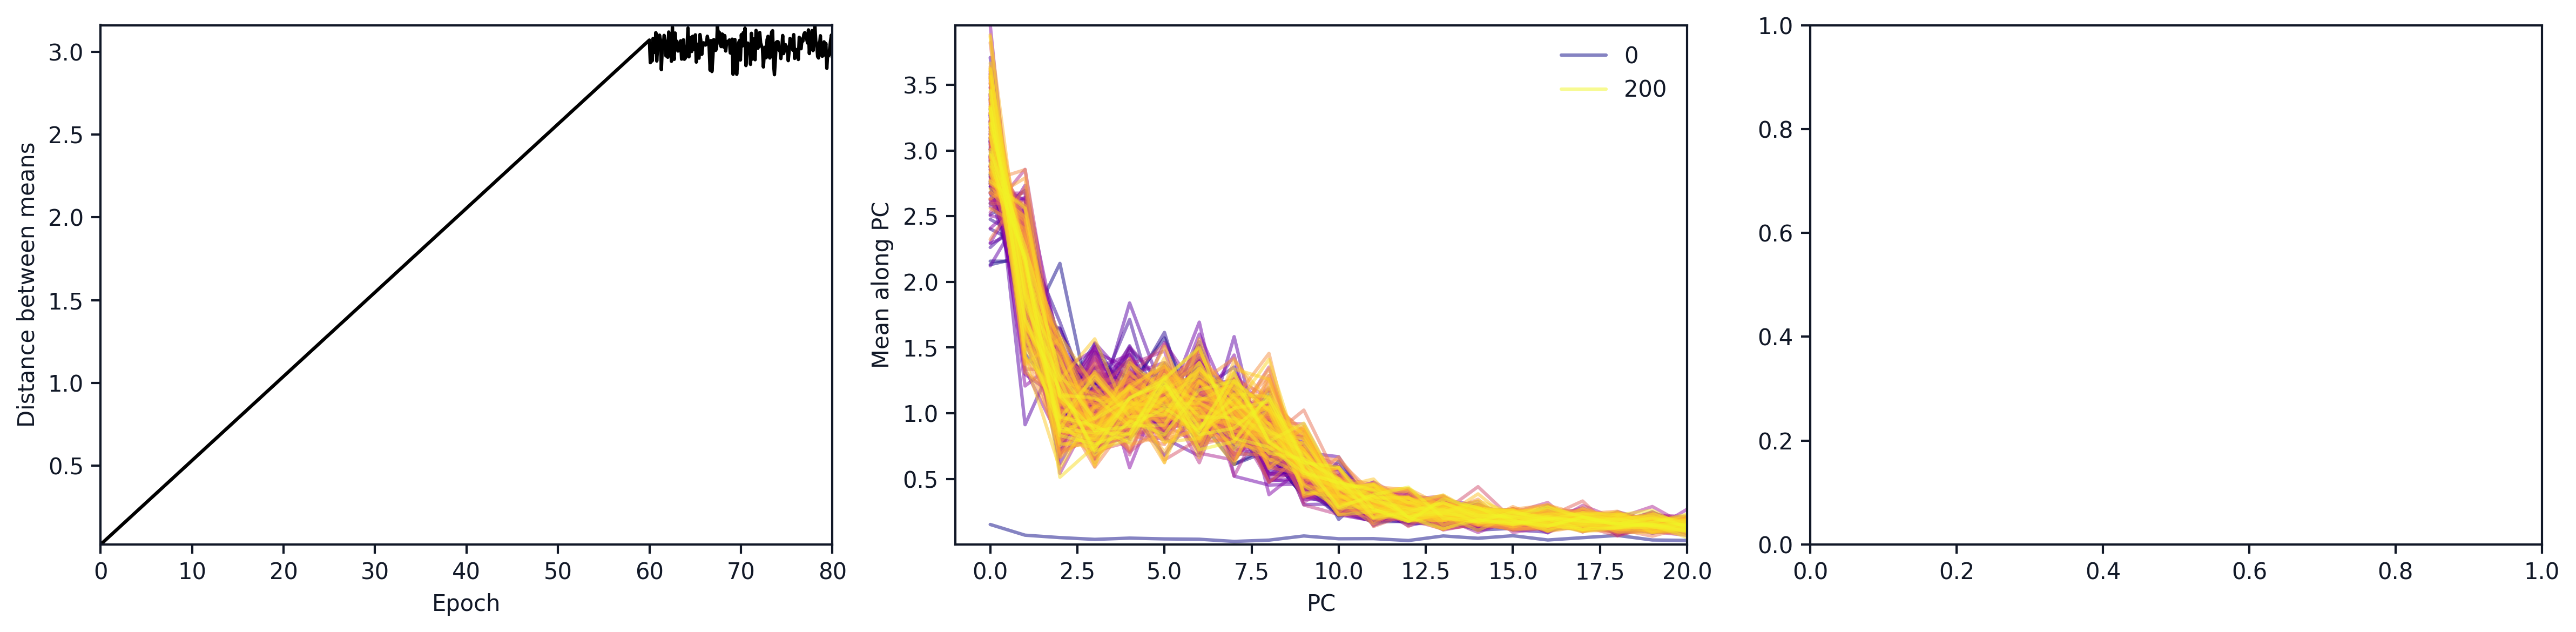

In [83]:
subset_labels = (class_labels[data_params['subset_idxs'][0]],
                 class_labels[data_params['subset_idxs'][1]])

class_means = np.zeros((n_trials, n_times, n_classes, n_feats))
class_pca_fits = [[[] for _ in range(n_times)] for _ in range(n_trials)] 
class_prs = np.zeros((n_trials, n_times, n_classes,))
n_pca = np.min(feat_outs_experiments[0][0][0].shape)
class_pca_means = np.zeros((n_trials, n_times, n_classes, n_pca))

class_diff_mag = np.zeros((n_trials, n_times,)) # Distance between class means

epochs = np.linspace(train_params['save_thresh'], train_params['n_epochs'], 
                     train_params['test_freq']*(train_params['n_epochs'] - train_params['save_thresh']))
epochs = np.insert(epochs, 0, 0.0) # Always has initial data, so add 0

for trial_idx in range(n_trials):
    feature_vals = feat_outs_experiments[trial_idx]
    for time_idx in range(len(feature_vals)):
        for class_idx in range(n_classes):
            class_means[trial_idx, time_idx, class_idx] = np.mean(feature_vals[time_idx][class_idx], axis=0)
            
            n_feat_space = np.min(feature_vals[time_idx][class_idx].shape)
            pca_time_class = PCA(n_components=n_feat_space)

            pca_feats = pca_time_class.fit_transform(feature_vals[time_idx][class_idx])
            class_prs[trial_idx, time_idx, class_idx] = participation_ratio_vector(
                pca_time_class.explained_variance_ratio_
            )

            # Removes ambiguity in PCA direction by making sure all means (along PC directions) are positive
            pca_dir_signs = np.sign(np.mean(np.matmul(feature_vals[time_idx][class_idx], pca_time_class.components_.T), axis=0))
            for pca_idx, pca_dir in enumerate(pca_time_class.components_):
                pca_time_class.components_[pca_idx, :] = pca_dir_signs[pca_idx] * pca_dir
            class_pca_fits[trial_idx][time_idx].append(pca_time_class)

            class_pca_means[trial_idx, time_idx, class_idx] = np.mean(
                np.matmul(feature_vals[time_idx][class_idx], pca_time_class.components_.T), axis=0)

        if n_classes == 2: # Won't work for more than 2 classes 
            class_diff_mag[trial_idx, time_idx] = np.linalg.norm(
                class_means[trial_idx, time_idx, 1] -
                class_means[trial_idx, time_idx, 0]
            )

# Number of time steps to take drift differences
n_time_drift = 1

mean_diff_mags = np.zeros((n_trials, n_classes, n_times-n_time_drift,))
mean_diff_mags_normalized = np.zeros((n_trials, n_classes, n_times-n_time_drift,))

pca_drift_aligns = np.zeros((n_trials, n_classes, n_times-n_time_drift, n_pca))
pca_drift_value = np.zeros((n_trials, n_classes, n_times-n_time_drift, n_pca))
class_drift_aligns = np.zeros((n_trials, n_times-n_time_drift,)) # Alignment betwen classes
drift_drift_aligns = np.zeros((n_trials, n_classes, n_times-n_time_drift, n_times-n_time_drift)) # Alignment betwen classes
pca_pca_aligns = np.zeros((n_trials, n_classes, n_times-n_time_drift,)) # Alignment between top PCs of current and previous time

for trial_idx in range(n_trials):
    drifts = np.zeros((n_classes, n_times-n_time_drift, n_feats))
    for time_idx in range(len(feature_vals) - n_time_drift):
        for class_idx in range(n_classes):
            drift = (
                class_means[trial_idx, time_idx+n_time_drift, class_idx] - 
                class_means[trial_idx, time_idx, class_idx]
            )
            drifts[class_idx, time_idx] = drift

            mean_diff_mags[trial_idx, class_idx, time_idx] = np.linalg.norm(drift)
            mean_diff_mags_normalized[trial_idx, class_idx, time_idx] = (
                mean_diff_mags[trial_idx, class_idx, time_idx]/np.linalg.norm(
                    class_means[trial_idx, time_idx, class_idx]
                )
            )
            pca_drift = np.matmul(
                class_pca_fits[trial_idx][time_idx][class_idx].components_,
                drift
            )

            for pca_idx in range(n_pca):
                pca_drift_aligns[trial_idx, class_idx, time_idx, pca_idx] = get_align(
                    class_pca_fits[trial_idx][time_idx][class_idx].components_[pca_idx],
                    drift
                )
                pca_drift_value[trial_idx, class_idx, time_idx, pca_idx] = pca_drift[pca_idx]
            pca_pca_aligns[trial_idx, class_idx, time_idx] = get_align(
                class_pca_fits[trial_idx][time_idx+n_time_drift][class_idx].components_[0],
                class_pca_fits[trial_idx][time_idx][class_idx].components_[0]
            )
        if n_classes > 2:
            class_drift_aligns[trial_idx, time_idx] = get_align(
                drifts[0, time_idx],
                drifts[1, time_idx]
            )
    # Calculate all pairwise drift aligns 
    for time_idx in range(len(feat_outs)-n_time_drift):
        for time_idx2 in range(len(feat_outs)-n_time_drift):
            for class_idx in range(n_classes):
                drift_drift_aligns[trial_idx, class_idx, time_idx, time_idx2] = (
                    get_align(
                        drifts[class_idx, time_idx], drifts[class_idx, time_idx2]
                    )
                )

avg_mean_diff_mags = np.mean(mean_diff_mags, axis=0)
avg_mean_diff_mags_normalized = np.mean(mean_diff_mags_normalized, axis=0)
avg_class_diff_mag = np.mean(class_diff_mag, axis=0)

avg_class_prs = np.mean(class_prs, axis=0)
avg_pca_drift_aligns = np.mean(pca_drift_aligns, axis=0)
avg_pca_drift_mags = np.mean(np.abs(pca_drift_value), axis=0)
avg_class_drift_aligns = np.mean(class_drift_aligns, axis=0)
avg_drift_drift_aligns = np.mean(drift_drift_aligns, axis=0)
avg_pca_pca_aligns = np.mean(pca_pca_aligns, axis=0)

avg_class_pca_means = np.mean(class_pca_means, axis=0)

# Epoch threshold for averaging across time (avoids initial training)
e_thresh = (45, 55)
idx_thresh = [train_params['test_freq']*(epoch - train_params['save_thresh'])+1 for epoch in e_thresh]

fig, ax = plt.subplots(1, 3, figsize=(16,4))
fig2, ax2 = plt.subplots(1, 3, figsize=(16,4))
fig3, ax3 = plt.subplots(1, 3, figsize=(16,4))
fig4, ax4 = plt.subplots(1, 3, figsize=(16,4))

for class_idx in range(n_classes):
    ax[0].plot(epochs[:-n_time_drift], avg_mean_diff_mags[class_idx], color=c_vals[class_idx], 
               label=data_params['subset_idxs'][class_idx])
    ax[1].plot(epochs[:-n_time_drift], avg_mean_diff_mags_normalized[class_idx], color=c_vals[class_idx],
               label=data_params['subset_idxs'][class_idx])
    ax[2].plot(epochs, avg_class_prs[:, class_idx], color=c_vals[class_idx],
               label=data_params['subset_idxs'][class_idx])

    ax2[0].plot(epochs[:-n_time_drift], avg_pca_drift_aligns[class_idx, :, 0], color=c_vals[class_idx], 
               label=data_params['subset_idxs'][class_idx])
    ax2[0].axhline(np.mean(avg_pca_drift_aligns[class_idx, idx_thresh[0]:idx_thresh[1], 0]), color=c_vals[class_idx], 
                   linestyle='dashed')
    
    ax2[1].plot(np.mean(avg_pca_drift_aligns[class_idx, idx_thresh[0]:idx_thresh[1]], axis=0), 
                color=c_vals[class_idx], 
                label=data_params['subset_idxs'][class_idx])
    ax2[2].plot(np.mean(avg_pca_drift_mags[class_idx, idx_thresh[0]:idx_thresh[1]], axis=0), 
                color=c_vals[class_idx], 
                label=data_params['subset_idxs'][class_idx])
    
    ax3[0].plot(epochs[:-n_time_drift], avg_pca_pca_aligns[class_idx], color=c_vals[class_idx],
               label=data_params['subset_idxs'][class_idx])
ax3[1].plot(epochs[:-n_time_drift], avg_class_drift_aligns, color='k')

for trial_idx in range(n_trials):
    ax3[1].plot(epochs[:-n_time_drift], class_drift_aligns[trial_idx], color='k', alpha=0.3)

ax4[0].plot(epochs, avg_class_diff_mag, color='k')

cmap = plt.cm.get_cmap('plasma')
for time_idx in range(n_times):
    label = None
    if time_idx == 0 or time_idx == n_times - 1:
        label = time_idx 
    ax4[1].plot(avg_class_pca_means[time_idx, 0], 
                color=cmap(time_idx/n_times), label=label, alpha=0.5)

drift_align_plot = ax3[2].matshow(avg_drift_drift_aligns[0], cmap='bwr',
                                  vmin=-1, vmax=1)

# This starts from epoch 0
# ax[0].plot(epochs, accuracies, color='k', label='Accuracy')
# ax[1].plot(epochs, accuracies, color='k', label='Accuracy')

for i in range(3):
    ax[i].set_xlabel('Epoch')
    ax[i].legend()
    ax2[i].legend()
ax[0].set_ylabel('Magnitude of drift')
ax[0].axhline(0.0, color='k', linestyle='dashed')

ax[1].set_ylabel('|drift|/|mean|')
ax[1].set_ylim([-0.5, 1.5])
ax[1].axhline(1.0, color='k', linestyle='dashed')
ax[1].axhline(0.0, color='k', linestyle='dashed')
ax[2].set_ylabel('Participation Ratio')

ax2[0].set_xlabel('Epoch')
ax2[0].set_ylabel('PC0 drift align')
ax2[0].axhline(0.0, color='k', linestyle='dashed')

ax2[1].set_xlabel('PC')
ax2[1].set_ylabel('Mean (PC, drift) align (over time)')
ax2[1].axhline(0.0, color='k', linestyle='dashed')
ax2[1].set_xlim([-1,20])

ax2[2].set_xlabel('PC')
ax2[2].set_ylabel('Drift magnitude')
ax2[2].axhline(0.0, color='k', linestyle='dashed')
ax2[2].set_xlim([-1,20])

ax3[0].set_xlabel('Epoch')
ax3[0].legend()
ax3[0].set_ylabel('PC0(t), PC0(t+{}) align'.format(n_time_drift))

ax3[1].set_xlabel('Epoch')
ax3[1].set_ylabel('{} drift, {} drift align'.format(
    data_params['subset_idxs'][0], data_params['subset_idxs'][1]
))

ax3[2].set_title('Alignment between drift directions (class: {})'.format(
    subset_labels[0]
))
plt.colorbar(drift_align_plot, ax=ax3[2])
ax3[2].set_xlabel('Time')
ax3[2].set_ylabel('Time')
ax3[2].set_xlim([0,30])
ax3[2].set_ylim([0,30])

ax4[0].set_xlabel('Epoch')
ax4[0].set_ylabel('Distance between means')

ax4[1].set_xlabel('PC')
ax4[1].set_ylabel('Mean along PC')
ax4[1].set_xlim([-1,20])
ax4[1].legend()

if train_params['switch_datasets']:
    for ax_i in (ax[0], ax[1], ax[2], ax2[0]):
        ax_i.axvline(train_params['switch_epoch'] - 0.5, color='grey', linestyle='dashed')

#### Variance Explained Ratio Plots

In [88]:
from scipy.stats import linregress

def get_align_angle(x, y):
    dot = np.dot(x,y)/(
         np.linalg.norm(x) * np.linalg.norm(y)
     )
    if dot > 1.0:
         dot = 1.0
    elif dot < -1.0:
        dot = -1.0
    
    return 180/np.pi * np.arccos(dot)

class_means = np.zeros((n_trials, n_times, n_classes, n_feats))
class_pca_fits = [[[] for _ in range(n_times)] for _ in range(n_trials)] 
class_prs = np.zeros((n_trials, n_times, n_classes))

epochs = np.linspace(train_params['save_thresh'], train_params['n_epochs'], 
                     train_params['test_freq']*(train_params['n_epochs'] - train_params['save_thresh']))
epochs = np.insert(epochs, 0, 0.0) # Always has initial data, so add 0
n_feats = feat_outs_experiments[0][0][0].shape[1]

for trial_idx in range(n_trials):
    feature_vals = feat_outs_experiments[trial_idx]
    for time_idx in range(len(feature_vals)):
        for class_idx in range(n_classes):
            class_means[trial_idx, time_idx, class_idx] = np.mean(feature_vals[time_idx][class_idx], axis=0)
            
            n_feat_space = np.min(feature_vals[time_idx][class_idx].shape)
            pca_time_class = PCA(n_components=n_feat_space)

            pca_feats = pca_time_class.fit_transform(feature_vals[time_idx][class_idx])

            # Removes ambiguity in PCA direction by making sure all means (along PC directions) are positive
            pca_dir_signs = np.sign(np.mean(np.matmul(feature_vals[time_idx][class_idx], pca_time_class.components_.T), axis=0))
            for pca_idx, pca_dir in enumerate(pca_time_class.components_):
                pca_time_class.components_[pca_idx, :] = pca_dir_signs[pca_idx] * pca_dir
            class_pca_fits[trial_idx][time_idx].append(pca_time_class)

            class_prs[trial_idx, time_idx, class_idx] = participation_ratio_vector(
                pca_time_class.explained_variance_ratio_
            )

# # Epoch threshold for averaging across time (avoids initial training)
# e_thresh = (30, 40)
# idx_thresh = [train_params['test_freq']*(epoch - train_params['save_thresh'])+1 for epoch in e_thresh]
# n_thresh = idx_thresh[1] - idx_thresh[0] # Number of idxs within the threshold
# print('Using epoch threshold:', e_thresh, 'idxs:', idx_thresh)
n_time_drift = 1 # delta t (number of idxs)

print('USING FIXED VALUES FOR DROPOUT DRIFT')
idx_thresh = (0, 10)
n_thresh = 10

# Some metrics independent of drift but still taken within epoch_thresholds
var_space_dim_ratio = np.zeros((n_trials, n_classes, n_thresh,))
var_space_var_exp = np.zeros((n_trials, n_classes, n_thresh,))

pca_var_exp_i_notdrift = np.zeros((n_trials, n_classes, n_thresh, n_pca))
pca_means = np.zeros((n_trials, n_classes, n_thresh, n_pca))

for trial_idx in range(n_trials):
    feature_vals = feat_outs_experiments[trial_idx]
    for time_idx in range(n_thresh):
        init_t_idx = idx_thresh[0]+time_idx
                
        for class_idx in range(n_classes):

            var_space_dim = participation_ratio_vector(
                class_pca_fits[trial_idx][init_t_idx][class_idx].explained_variance_ratio_
            )
            var_space_dim_ratio[trial_idx, class_idx, time_idx] = var_space_dim/n_feats
            var_space_dim_int = int(np.ceil(var_space_dim))
            var_space_var_exp[trial_idx, class_idx, time_idx] = np.sum(
                class_pca_fits[trial_idx][init_t_idx][class_idx].explained_variance_ratio_[:var_space_dim_int]
            )

            pca_means[trial_idx, class_idx, time_idx] = (np.mean(
                np.matmul(feature_vals[init_t_idx][class_idx], class_pca_fits[trial_idx][init_t_idx][class_idx].components_.T), axis=0)/
                np.linalg.norm(class_means[trial_idx, init_t_idx, class_idx])
            )
            pca_var_exp_i_notdrift[trial_idx, class_idx, time_idx] = (
                class_pca_fits[trial_idx][init_t_idx][class_idx].explained_variance_ratio_
            )

# Average over classes and times
avg_var_space_dim_ratio = np.mean(var_space_dim_ratio, axis=(1, 2))
avg_var_space_var_exp = np.mean(var_space_var_exp, axis=(1,2))
print('D/n: {:.3f} (std {:.3f})'.format(
    avg_var_space_dim_ratio.mean(), avg_var_space_dim_ratio.std()))
print('Var exp in D: {:.3f} (std {:.3f})'.format(
    avg_var_space_var_exp.mean(), avg_var_space_var_exp.std()))

# Time set to n-thresh - n_time_drift so all differences taken within threshold

pca_var_exp_i = np.zeros((n_trials, n_classes, n_thresh-n_time_drift, n_pca))
pca_drift_angles = np.zeros((n_trials, n_classes, n_thresh-n_time_drift, n_pca))
pca_drift_mag = np.zeros((n_trials, n_classes, n_thresh-n_time_drift, n_pca))
pca_i_var_exp_f = np.zeros((n_trials, n_classes, n_thresh-n_time_drift, n_pca))

for trial_idx in range(n_trials):
    drifts = np.zeros((n_classes, n_times-n_time_drift, n_feats))
    for time_idx in range(n_thresh-n_time_drift):
        init_t_idx = idx_thresh[0]+time_idx
        final_t_idx = idx_thresh[0]+time_idx+n_time_drift
        
        for class_idx in range(n_classes):
            
            
            # Drift metrics
            drift = (
                class_means[trial_idx, final_t_idx, class_idx] - 
                class_means[trial_idx, init_t_idx, class_idx]
            )
            drifts[class_idx, time_idx] = drift

            pca_var_exp_i[trial_idx, class_idx, time_idx] = (
                class_pca_fits[trial_idx][init_t_idx][class_idx].explained_variance_ratio_
            )

            pca_drift = np.matmul(
                class_pca_fits[trial_idx][init_t_idx][class_idx].components_,
                drift
            )

            for pca_idx in range(n_pca):
                pca_drift_angles[trial_idx, class_idx, time_idx, pca_idx] = get_align_angle(
                    class_pca_fits[trial_idx][init_t_idx][class_idx].components_[pca_idx],
                    drift
                )
                pca_drift_mag[trial_idx, class_idx, time_idx, pca_idx] = np.abs(
                    pca_drift[pca_idx])/np.linalg.norm(drift)

            data_i = feat_outs_experiments[trial_idx][init_t_idx][class_idx]
            data_f = feat_outs_experiments[trial_idx][final_t_idx][class_idx]

            # Flow of variation
            pca_i_data_i = np.matmul(data_i, class_pca_fits[trial_idx][init_t_idx][class_idx].components_.T)
            pca_i_data_f = np.matmul(data_f, class_pca_fits[trial_idx][init_t_idx][class_idx].components_.T)
            
            pca_i_data_i_cov = np.cov(pca_i_data_i.T)
            pca_i_data_i_vars = np.diag(pca_i_data_i_cov)
            pca_i_data_i_vars_ratio = pca_i_data_i_vars/np.sum(pca_i_data_i_vars)
            pca_i_data_f_cov = np.cov(pca_i_data_f.T)
            pca_i_data_f_vars = np.diag(pca_i_data_f_cov)
            pca_i_var_exp_f[trial_idx, class_idx, time_idx] = pca_i_data_f_vars/np.sum(pca_i_data_f_vars)

Using epoch threshold: (70, 80) idxs: [101, 201]
D/n: 0.122 (std 0.006)
Var exp in D: 0.773 (std 0.005)


Drift magnitudes:
  plane - Slope: 1.38 (se: 0.01), r: 0.44 p: 0.00e+00
  car - Slope: 1.24 (se: 0.01), r: 0.45 p: 0.00e+00
Drift angle
  plane - Slope: 47.28 (se: 0.92), r: 0.18 p: 0.00e+00
  car - Slope: 35.78 (se: 0.79), r: 0.16 p: 0.00e+00
Change in variance
  plane - Slope: 0.56 (se: 0.00), r: 0.92 p: 0.00e+00
  car - Slope: 0.58 (se: 0.00), r: 0.92 p: 0.00e+00


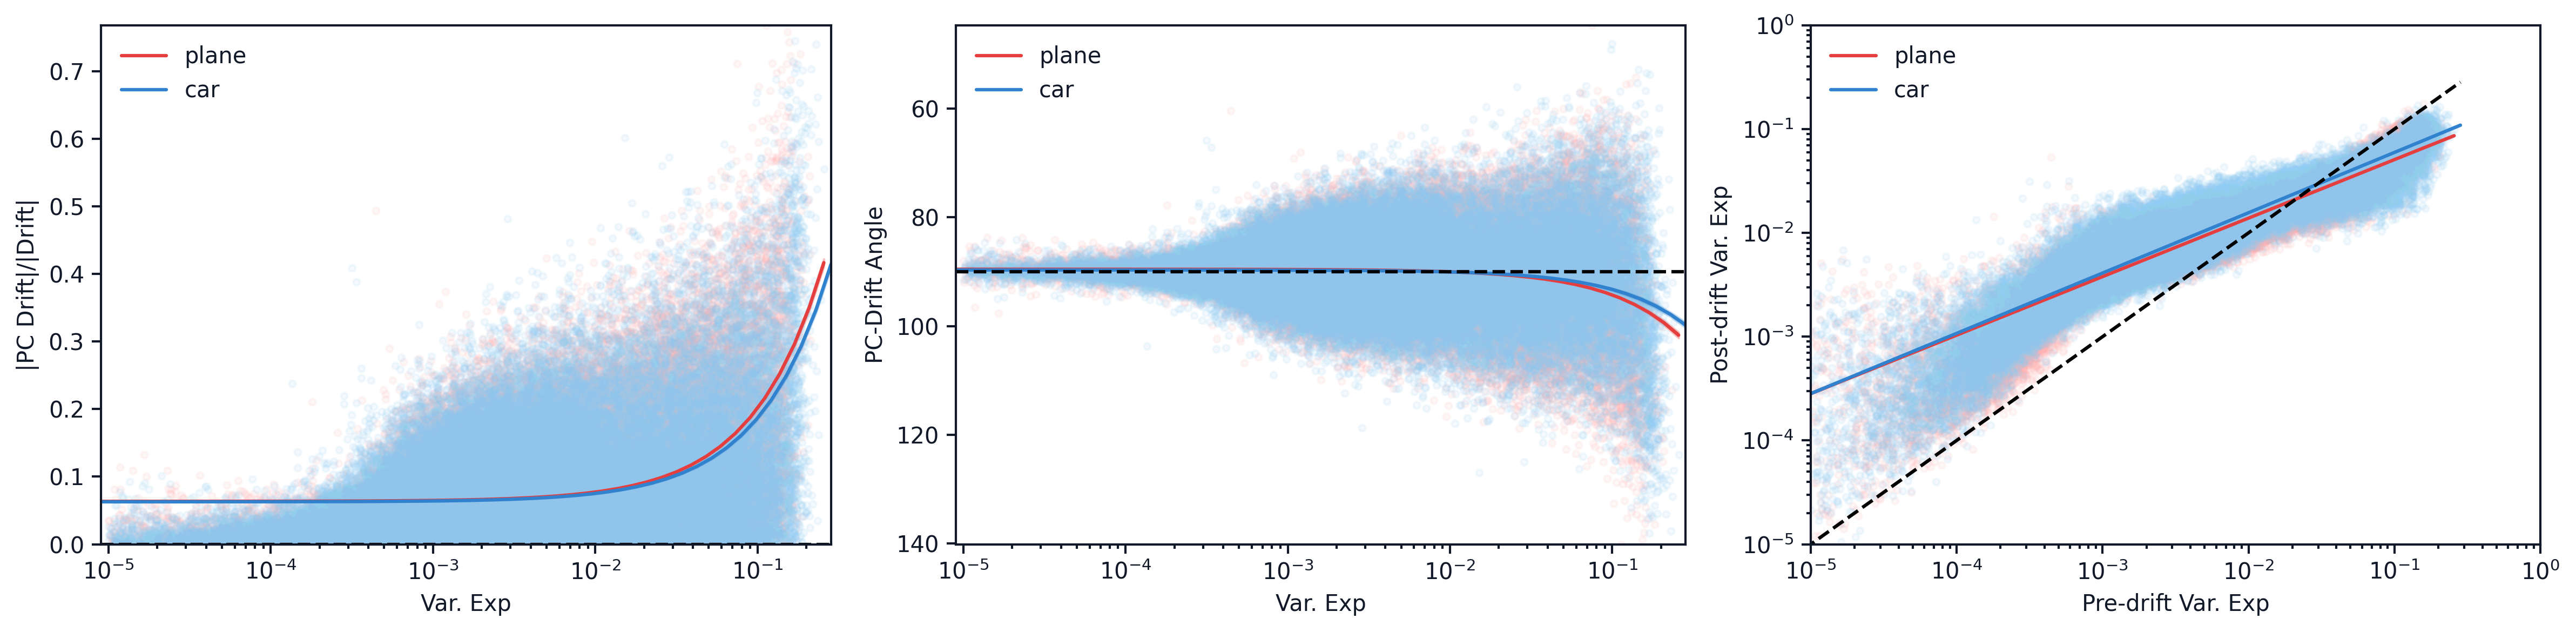

In [89]:
subset_labels = [class_labels[data_params['subset_idxs'][idx]] for idx in range(n_classes)]

fig, ax = plt.subplots(1, 3, figsize=(16,4))

n_se = 1.97
class_idx_save = 1

# Not drift metrics
pca_var_exp_i_notdrift_fit = [[] for _ in range(n_classes)]
pca_means_fit = [[] for _ in range(n_classes)]
# Drift metrics
pca_var_exp_i_fit = [[] for _ in range(n_classes)]
pca_drift_angles_fit = [[] for _ in range(n_classes)]
pca_drift_mag_fit = [[] for _ in range(n_classes)]
pca_i_var_exp_f_fit = [[] for _ in range(n_classes)]
# Reshapes all vectors for fitting
for class_idx in range(n_classes):
    pca_var_exp_i_notdrift_fit[class_idx] = np.transpose(pca_var_exp_i_notdrift, axes=(1, 0, 2, 3)).reshape((n_classes, -1))[class_idx]
    pca_means_fit[class_idx] = np.transpose(pca_means, axes=(1, 0, 2, 3)).reshape((n_classes, -1))[class_idx]

    pca_var_exp_i_fit[class_idx] = np.transpose(pca_var_exp_i, axes=(1, 0, 2, 3)).reshape((n_classes, -1))[class_idx]
    pca_drift_angles_fit[class_idx] = np.transpose(pca_drift_angles, axes=(1, 0, 2, 3)).reshape((n_classes, -1))[class_idx]
    pca_drift_mag_fit[class_idx] = np.transpose(pca_drift_mag, axes=(1, 0, 2, 3)).reshape((n_classes, -1))[class_idx]
    pca_i_var_exp_f_fit[class_idx] = np.transpose(pca_i_var_exp_f, axes=(1, 0, 2, 3)).reshape((n_classes, -1))[class_idx]

# Thresholds
min_var_exp = 1e-5

for class_idx in range(n_classes):
    var_exp_filter = pca_var_exp_i_notdrift_fit[class_idx] > min_var_exp
    pca_means_fit[class_idx] = pca_means_fit[class_idx][var_exp_filter]
    pca_var_exp_i_notdrift_fit[class_idx] = pca_var_exp_i_notdrift_fit[class_idx][var_exp_filter]

    var_exp_filter = pca_var_exp_i_fit[class_idx] > min_var_exp 
    pca_drift_angles_fit[class_idx] = pca_drift_angles_fit[class_idx][var_exp_filter]
    pca_drift_mag_fit[class_idx] = pca_drift_mag_fit[class_idx][var_exp_filter]
    pca_i_var_exp_f_fit[class_idx] = pca_i_var_exp_f_fit[class_idx][var_exp_filter]
    pca_var_exp_i_fit[class_idx] = pca_var_exp_i_fit[class_idx][var_exp_filter]

print('Drift magnitudes:')
for class_idx in range(n_classes):
    ax[0].scatter(pca_var_exp_i_fit[class_idx],
                  pca_drift_mag_fit[class_idx],
                  marker='.', color=c_vals_l[class_idx], 
                  alpha=0.1)

    reg = linregress(
        pca_var_exp_i_fit[class_idx], 
        pca_drift_mag_fit[class_idx])
    reg1 = reg
    print('  {} - Slope: {:.2f} (se: {:.2f}), r: {:.2f} p: {:.2e}'.format(
         subset_labels[class_idx], reg.slope, reg.stderr, reg.rvalue, reg.pvalue))
    reg_plot_X = np.logspace(np.log10(0.9*np.min(pca_var_exp_i_fit[class_idx])), 
                             np.log10(1.1*np.max(pca_var_exp_i_fit[class_idx])), num=50)
    reg_plot_y = reg.slope * reg_plot_X + reg.intercept
    reg_plot_min_y = ((reg.slope - n_se* reg.stderr) * reg_plot_X + 
                      (reg.intercept - n_se * reg.intercept_stderr))
    reg_plot_max_y = ((reg.slope + n_se * reg.stderr) * reg_plot_X + 
                      (reg.intercept + n_se * reg.intercept_stderr))
    ax[0].fill_between(reg_plot_X, reg_plot_min_y, reg_plot_max_y, 
                       color=c_vals[class_idx], alpha=0.3)
    ax[0].plot(reg_plot_X, reg_plot_y, color=c_vals[class_idx], 
               label=subset_labels[class_idx],)

    if class_idx == class_idx_save:
        drift_mag_fits_X = reg_plot_X
        drift_mag_fits_y = (reg_plot_y, reg_plot_min_y, reg_plot_max_y)
        drift_mag_rs = reg.rvalue

print('Drift angle')
for class_idx in range(n_classes):   
    ax[1].scatter(pca_var_exp_i_fit[class_idx],
                  pca_drift_angles_fit[class_idx],
                  marker='.', color=c_vals_l[class_idx], 
                  alpha=0.1)

    reg = linregress(pca_var_exp_i_fit[class_idx],
                     pca_drift_angles_fit[class_idx])
    reg2 = reg
    print('  {} - Slope: {:.2f} (se: {:.2f}), r: {:.2f} p: {:.2e}'.format(
         subset_labels[class_idx], reg.slope, reg.stderr, reg.rvalue, reg.pvalue))
    reg_plot_X = np.logspace(np.log10(0.9*np.min(pca_var_exp_i_fit[class_idx])), 
                             np.log10(1.1*np.max(pca_var_exp_i_fit[class_idx])), num=50)
    reg_plot_y = reg.slope * reg_plot_X + reg.intercept
    reg_plot_min_y = ((reg.slope - n_se* reg.stderr) * reg_plot_X + 
                      (reg.intercept - n_se * reg.intercept_stderr))
    reg_plot_max_y = ((reg.slope + n_se * reg.stderr) * reg_plot_X + 
                      (reg.intercept + n_se * reg.intercept_stderr))
    ax[1].fill_between(reg_plot_X, reg_plot_min_y, reg_plot_max_y, 
                       color=c_vals[class_idx], alpha=0.3)
    ax[1].plot(reg_plot_X, reg_plot_y, color=c_vals[class_idx], 
               label=subset_labels[class_idx],)

    if class_idx == class_idx_save:
        drift_angle_fits_X = reg_plot_X
        drift_angle_fits_y = (reg_plot_y, reg_plot_min_y, reg_plot_max_y)
        drift_angle_rs = reg.rvalue

print('Change in variance') 
for class_idx in range(n_classes): 
    ax[2].scatter(pca_var_exp_i_fit[class_idx], 
                  pca_i_var_exp_f_fit[class_idx],
                  marker='.', color=c_vals_l[class_idx], 
                  alpha=0.1)

    reg = linregress(np.log(pca_var_exp_i_fit[class_idx]), 
                     np.log(pca_i_var_exp_f_fit[class_idx]))
    reg3 = reg
    print('  {} - Slope: {:.2f} (se: {:.2f}), r: {:.2f} p: {:.2e}'.format(
         subset_labels[class_idx], reg.slope, reg.stderr, reg.rvalue, reg.pvalue))
    reg_plot_X = np.logspace(np.log10(0.9*np.min(pca_var_exp_i_fit[class_idx])), 
                             np.log10(1.1*np.max(pca_var_exp_i_fit[class_idx])), num=50)
    reg_plot_y = np.exp(reg.slope * np.log(reg_plot_X) + reg.intercept)
    reg_plot_min_y = np.exp((reg.slope - n_se* reg.stderr) * np.log(reg_plot_X) + 
                            (reg.intercept - n_se * reg.intercept_stderr))
    reg_plot_max_y = np.exp((reg.slope + n_se * reg.stderr) * np.log(reg_plot_X) + 
                            (reg.intercept + n_se * reg.intercept_stderr))
    ax[2].fill_between(reg_plot_X, reg_plot_min_y, reg_plot_max_y, 
                       color=c_vals[class_idx], alpha=0.3)
    ax[2].plot(reg_plot_X, reg_plot_y, color=c_vals[class_idx], 
               label=subset_labels[class_idx],)
    if class_idx == class_idx_save:
        change_varexp_fits_X = reg_plot_X
        change_varexp_fits_y = (reg_plot_y, reg_plot_min_y, reg_plot_max_y)
        change_varexp_rs = reg.rvalue

ax[0].axhline(0.0, color='k', linestyle='dashed')
ax[0].set_xlabel('Var. Exp')
ax[0].set_ylabel('|PC Drift|/|Drift|')
ax[0].set_xscale('log')
ax[0].legend()

ax[1].axhline(90.0, color='k', linestyle='dashed')
ax[1].set_xlabel('Var. Exp')
ax[1].set_ylabel('PC-Drift Angle')
ax[1].set_xscale('log')
ax[1].invert_yaxis()
ax[1].legend()

ax[2].plot(reg_plot_X, reg_plot_X, color='k', linestyle='dashed')
ax[2].set_xlabel('Pre-drift Var. Exp')
ax[2].set_ylabel('Post-drift Var. Exp')
ax[2].set_xlim([min_var_exp, 1.0])
ax[2].set_ylim([min_var_exp, 1.0])
ax[2].set_xscale('log')
ax[2].set_yscale('log')
ax[2].legend()

Mean as a function of variance explained plot

  car - Slope: 0.76 (se: 0.00), r: 0.77 p: 0.00e+00


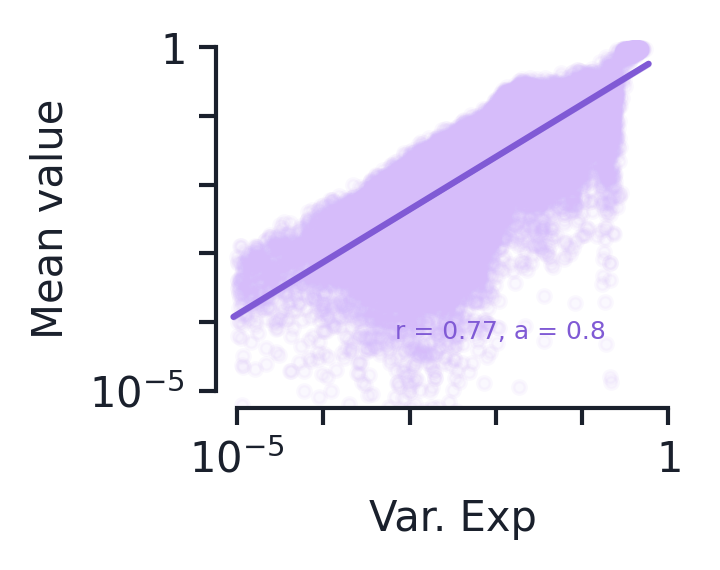

In [ ]:
# Plots of means versus variance explained
fig, ax = plt.subplots(1, 1, figsize=(2.5,2))
class_idx = 1

ax.scatter(pca_var_exp_i_notdrift_fit[class_idx], 
                pca_means_fit[class_idx],
                marker='.', color=c_vals_l[3], 
                alpha=0.1)

reg = linregress(np.log(pca_var_exp_i_notdrift_fit[class_idx]), 
                    np.log(pca_means_fit[class_idx]))
print('  {} - Slope: {:.2f} (se: {:.2f}), r: {:.2f} p: {:.2e}'.format(
        subset_labels[class_idx], reg.slope, reg.stderr, reg.rvalue, reg.pvalue))
reg_plot_X = np.logspace(np.log10(0.9*np.min(pca_var_exp_i_notdrift_fit[class_idx])), 
                            np.log10(1.1*np.max(pca_var_exp_i_notdrift_fit[class_idx])), num=50)
reg_plot_y = np.exp(reg.slope * np.log(reg_plot_X) + reg.intercept)
reg_plot_min_y = np.exp((reg.slope - n_se* reg.stderr) * np.log(reg_plot_X) + 
                        (reg.intercept - n_se * reg.intercept_stderr))
reg_plot_max_y = np.exp((reg.slope + n_se * reg.stderr) * np.log(reg_plot_X) + 
                        (reg.intercept + n_se * reg.intercept_stderr))
ax.fill_between(reg_plot_X, reg_plot_min_y, reg_plot_max_y, 
                    color=c_vals[3], alpha=0.3)
ax.plot(reg_plot_X, reg_plot_y, color=c_vals[3], 
            label=subset_labels[class_idx],)

ax.text(0.6, 0.2, 'r = {:.2f}, a = {:.1f}'.format(reg.rvalue, reg.slope), 
        horizontalalignment='center', verticalalignment='center', 
        color=c_vals[3], fontsize=6, transform=ax.transAxes)

ax.set_xlabel('Var. Exp')
ax.set_ylabel('Mean value')
# ax.set_ylim([0, 1])
# ax.set_yticks([0, 0.5, 1])
# ax.set_yticklabels([0, 0.5, 1])
ax.set_xlim([min_var_exp, 1.0])
ax.set_xscale('log')
ax.set_ylim([1e-5, 1.0])
ax.set_yscale('log')
ax.set_xticks([1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0])
ax.set_xticklabels(['$10^{-5}$', None, None, None, None, '$1$'])
ax.set_yticks([1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0])
ax.set_yticklabels(['$10^{-5}$', None, None, None, None, '$1$'])

jetplot.breathe(ax=ax)

#### Correlation decay plots

Sees how the correlation between pairs of feature space representations changes as a function of the time difference of which they are taken. In the passive data we see a very slow decline in correlation, so we would like to see the same here.

In [ ]:
n_times = 50
trial_idx = 0
# n_test = feat_outs_experiments[0][0][0].shape[0] # All test examples
n_test = 200

# Epoch threshold
e_thresh = 500

corr_vals = np.zeros((n_trials, n_times-1))

for trial_idx in range(n_trials):
    feature_vals = feat_outs_experiments[trial_idx]
    
    trial_corrs = np.zeros((n_classes, n_times-1))
    for class_idx in range(n_classes):
        class_corrs = [[] for _ in range(n_times-1)]
        for time_idx1 in range(e_thresh, len(feature_vals)):
        # for time_idx1 in range(e_thresh, e_thresh+1):
            for time_idx2 in range(time_idx1+1, len(feature_vals)):
                time_diff = time_idx2 - time_idx1 
                if time_diff < n_times:
                    corrs = np.corrcoef(
                        feature_vals[time_idx1][class_idx][:n_test, :],
                        feature_vals[time_idx2][class_idx][:n_test, :]
                    )[:n_test, n_test:]
                    # Average over all test examples correlation at two time steps
                    class_corrs[time_diff-1].append(np.mean(
                        np.diag(corrs)
                    ))
        # for i in range(n_times-1):
        #     print('Idx {} len {}'.format(i, len(class_corrs[i])))

        # Average all examples of a given time difference
        class_corrs = [np.mean(corr_val_list) for corr_val_list in class_corrs]
        trial_corrs[class_idx] = class_corrs
    
    corr_vals[trial_idx] = np.mean(trial_corrs, axis=0)

# Number of time steps to take drift differences
n_time_drift = 1

(0.0, 1.0)

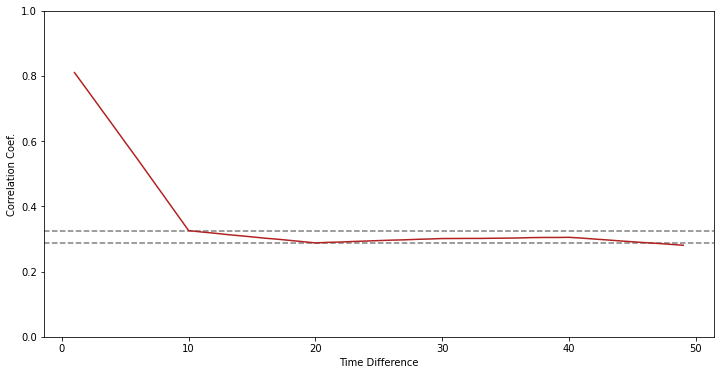

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

time_diffs = np.arange(1, n_times)

ax.axhline(np.mean(corr_vals, axis=0)[9], color='grey', linestyle='dashed')
ax.axhline(np.mean(corr_vals, axis=0)[19], color='grey', linestyle='dashed')
ax.plot(time_diffs, np.mean(corr_vals, axis=0), color='firebrick')
ax.set_xlabel('Time Difference')
ax.set_ylabel('Correlation Coef.')
ax.set_ylim([0.0, 1.0])


#### SVCs

This investigates how an SVC decision boundary might change as a function of time.

In [ ]:
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

def get_align(x, y):
     return np.dot(x,y)/(
         np.linalg.norm(x) * np.linalg.norm(y)
     )

# Epoch threshold
e_thresh = (60, 65)
idx_thresh = [train_params['test_freq']*(epoch - train_params['save_thresh'])+1 for epoch in e_thresh]
n_thresh = idx_thresh[1] - idx_thresh[0] # Number of idxs within the threshold
print('Using epoch threshold:', e_thresh)

n_folds = 10
n_feats = feat_outs_experiments[0][0][0].shape[1]

cross_aligns_trial = np.zeros((n_trials, n_thresh, n_thresh))
cross_angles_trial = np.zeros((n_trials, n_thresh, n_thresh))

cross_accs_trial = np.zeros((n_trials, n_thresh, n_thresh))
readout_aligns_trial = np.zeros((n_trials, n_thresh))

for trial_idx in range(n_trials):
    print('Trial:', trial_idx)
    feature_vals = feat_outs_experiments[trial_idx]
    readout_ws = readout_w_experiments[trial_idx]

    X_data_times = []
    y_labels_times = []

    models_time = []

    for time_idx in range(idx_thresh[0], idx_thresh[1]):
        
        # Create the classification data 
        X_data = []
        y_labels = []

        for class_idx in range(n_classes):
            X_data.append(feature_vals[time_idx][class_idx])
            y_labels.append(class_idx * np.ones(
                feature_vals[time_idx][class_idx].shape[0], 
                dtype=np.int32
            ))

        X_data = np.concatenate(X_data, axis=0)
        y_labels = np.concatenate(y_labels, axis=0)

        # Shuffle the classification data
        arr_idxs = np.arange(X_data.shape[0])
        np.random.seed(10)
        np.random.shuffle(arr_idxs)
        X_data = X_data[arr_idxs]
        y_labels = y_labels[arr_idxs]

        X_data_times.append(X_data)
        y_labels_times.append(y_labels)

        # k-Fold Cross validation, saving the model details at each step
        kf = KFold(n_splits=n_folds)

        models = []
        coefs = np.zeros((n_folds, n_feats))
        intercepts = np.zeros((n_folds,))
        raw_accs = np.zeros((n_folds, ))

        for fold_idx, (train_index, test_index) in enumerate(kf.split(X_data)):
            X_train, X_test = X_data[train_index], X_data[test_index]
            y_train, y_test = y_labels[train_index], y_labels[test_index]

            # SVC classifier
            # clf = svm.LinearSVC(class_weight=class_weights, fit_intercept=False)
            clf = svm.LinearSVC(class_weight='balanced', fit_intercept=True, max_iter=100000)
            # clf = svm.LinearSVC(fit_intercept=False)

            clf.fit(X_train, y_train)
            models.append(clf)
            coefs[fold_idx] = clf.coef_[0]
            intercepts[fold_idx] = clf.intercept_[0]

            y_pred = clf.predict(X_test)
            raw_accs[fold_idx] = np.sum(y_pred == y_test) / y_test.shape[0]

        models_time.append(models)

    cross_aligns = np.zeros((n_thresh, n_thresh))
    cross_angles = np.zeros((n_thresh, n_thresh))
    cross_accs = np.zeros((n_thresh, n_thresh))

    readout_aligns = np.zeros((n_thresh,))

    for time_idx_c in range(n_thresh): # Classifier index
        
        ro_aligns_folds = aligns = np.zeros((n_folds,))
        
        models = models_time[time_idx_c]
        
        # Cross accuracy/alignment calculation
        for time_idx_d in range(n_thresh): # Data index
            X_data = X_data_times[time_idx_d]
            y_labels = y_labels_times[time_idx_d]

            models_d = models_time[time_idx_d]

            aligns = np.zeros((n_folds,))
            angles = np.zeros((n_folds,))
            cross_accs_folds = np.zeros((n_folds,))

            # k-Fold Cross validation, saving the model details at each step
            kf = KFold(n_splits=n_folds)

            for fold_idx, (train_index, test_index) in enumerate(kf.split(X_data)):
                _, X_test = X_data[train_index], X_data[test_index]
                _, y_test = y_labels[train_index], y_labels[test_index]

                # SVC classifier
                clf = models[fold_idx]
                y_cross_pred = clf.predict(X_test)
                cross_accs_folds[fold_idx] = np.sum(y_cross_pred == y_test) / y_test.shape[0]


                clf_d = models_d[fold_idx]
                aligns[fold_idx] = get_align(
                    clf.coef_[0], clf_d.coef_[0]
                )
                angles[fold_idx] = get_align_angle(
                    clf.coef_[0], clf_d.coef_[0]
                ) 
            cross_accs[time_idx_c, time_idx_d] = np.mean(cross_accs_folds)
            cross_aligns[time_idx_c, time_idx_d] = np.mean(aligns)
            cross_angles[time_idx_c, time_idx_d] = np.mean(angles)
        
        # Readout alignment calculation
        for fold_idx in range(n_folds):
            # Alignment with first class idx
            ro_aligns_folds[fold_idx] = get_align(
                readout_ws[time_idx_c][0], models[fold_idx].coef_[0]
            )
        
        readout_aligns[time_idx_c] = np.mean(ro_aligns_folds)

    cross_aligns_trial[trial_idx] = cross_aligns
    cross_angles_trial[trial_idx] = cross_angles
    cross_accs_trial[trial_idx] = cross_accs
    readout_aligns_trial[trial_idx] = readout_aligns

Using epoch threshold: (60, 65)
Trial: 0
Trial: 1
Trial: 2
Trial: 3
Trial: 4
Trial: 5
Trial: 6
Trial: 7
Trial: 8
Trial: 9


Avg cross acc: 0.75, std 0.03
Avg rel cross acc: 0.86, std 0.03
Avg angle: 69.57, std 3.11


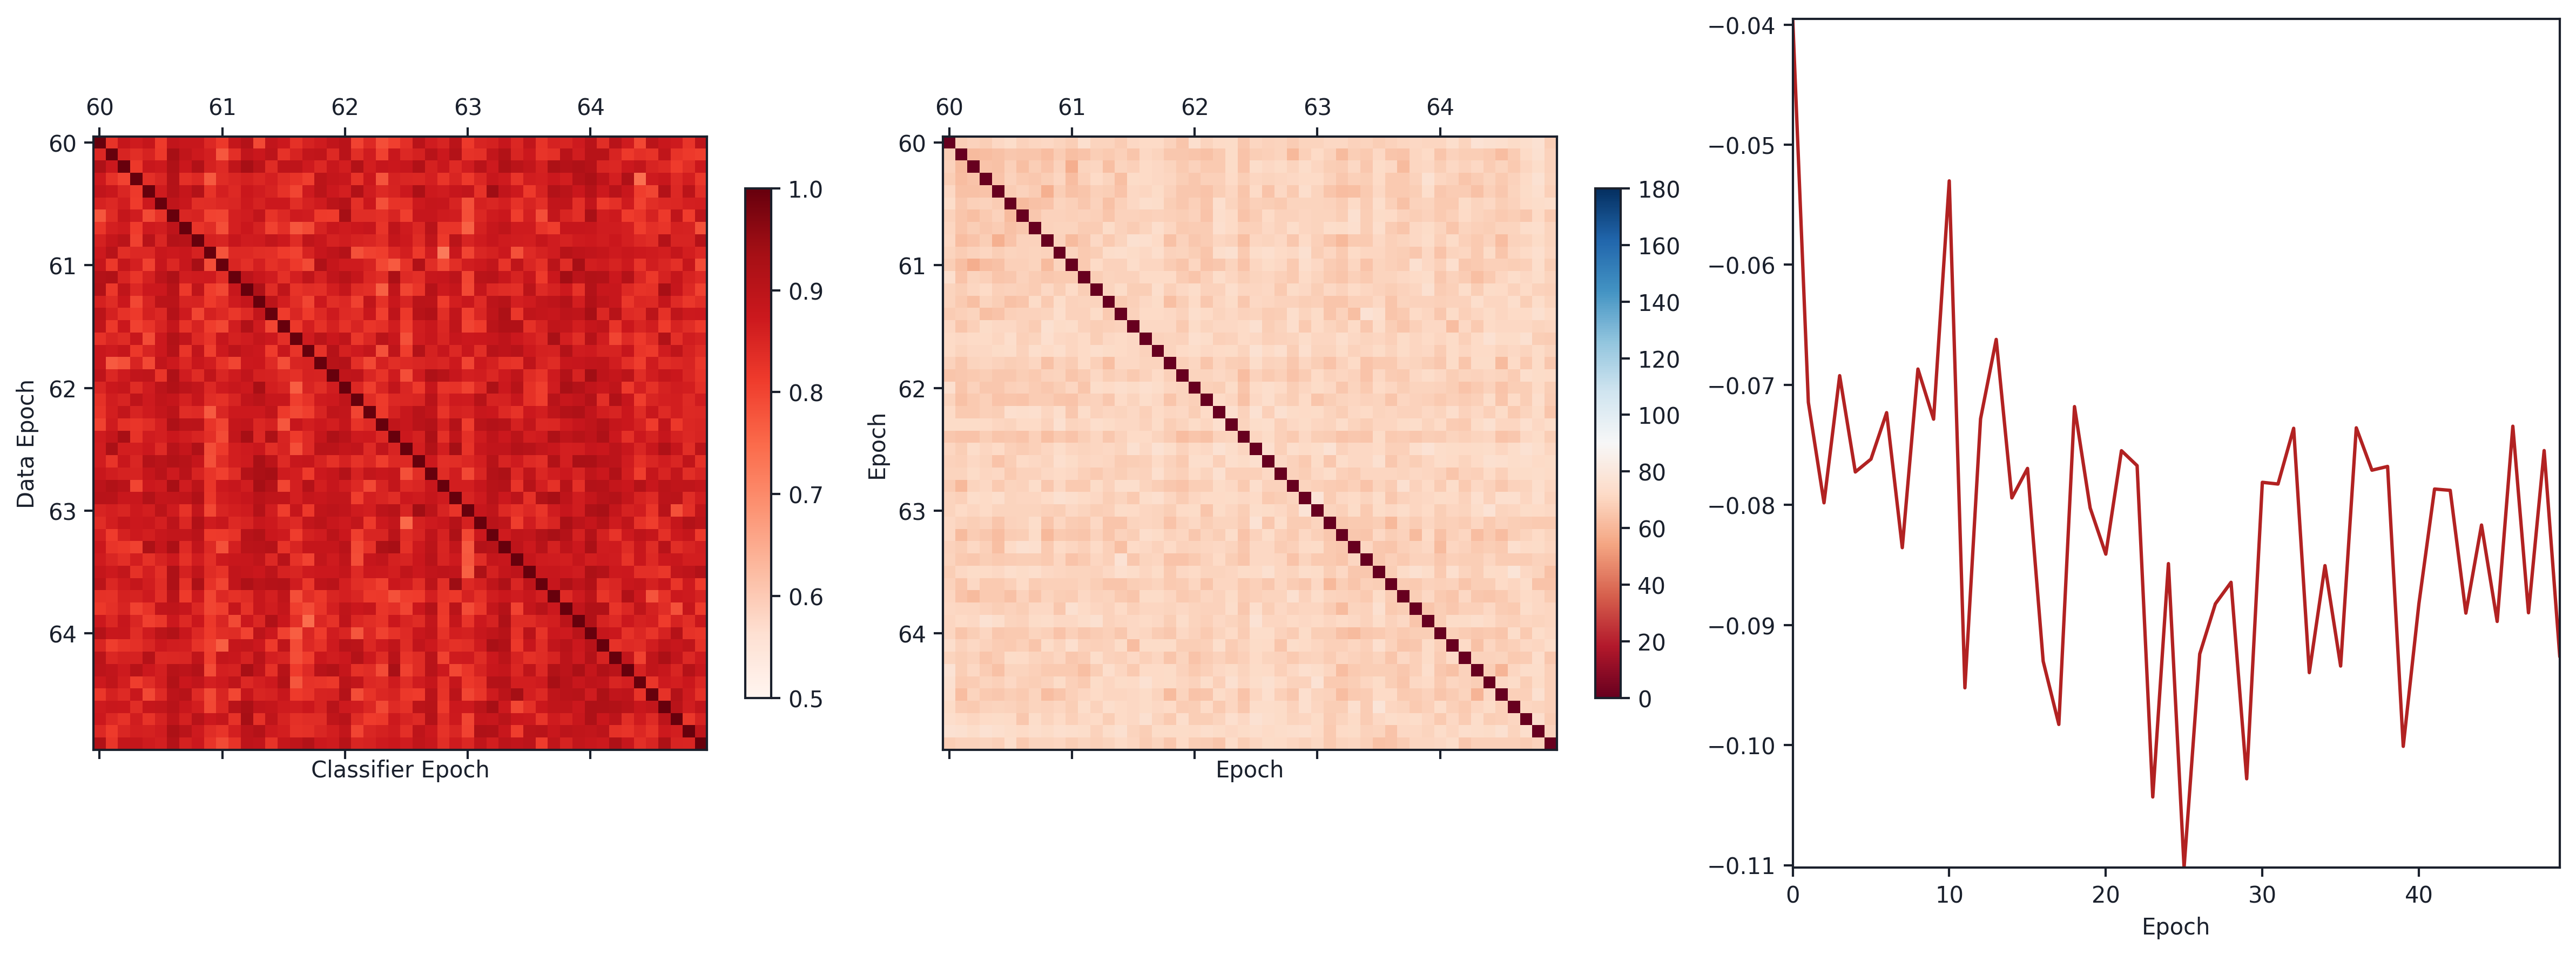

In [ ]:
cross_accs_rel_trial = np.zeros((n_trials, n_thresh, n_thresh))

for trial_idx in range(n_trials):
    for time_idx_c in range(n_thresh): # Classifier index
        if cross_accs_trial[trial_idx, time_idx_c, time_idx_c] == 0.0:
            raise ValueError('Accuracy is zero at idx {}!'.format(time_idx_c))
        cross_accs_rel_trial[trial_idx, time_idx_c, :] = (
            cross_accs_trial[trial_idx, time_idx_c, :] / 
            cross_accs_trial[trial_idx, time_idx_c, time_idx_c]
        )

fig, ax = plt.subplots(1, 3, figsize=(16, 6))

acc_plot = ax[0].matshow(np.mean(cross_accs_rel_trial, axis=0), vmin=0.5, 
                         vmax=1.0, cmap='Reds')
plt.colorbar(acc_plot, ax=ax[0], shrink=0.6)

ax[0].set_xlabel('Classifier Epoch')
ax[0].set_ylabel('Data Epoch')
# ax[0].set_title('Relative Cross Accuracies')

align_plot = ax[1].matshow(np.mean(cross_angles_trial, axis=0), vmin=0.0,
                           vmax=180, cmap='RdBu')
plt.colorbar(align_plot, ax=ax[1], shrink=0.6)

ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Epoch')
# ax[1].set_title('Classifier Alignment')

ax[2].plot(np.mean(readout_aligns_trial, axis=0), color='firebrick')
ax[2].set_xlabel('Epoch')
# ax[2].set_ylabel('(RO[0], SVC) align')

for ax_it in (ax[0], ax[1]):
    ax_it.set_xticks([0, 10, 20, 30, 40])
    ax_it.set_yticks([0, 10, 20, 30, 40])
    ax_it.set_xticklabels([60, 61, 62, 63, 64])
    ax_it.set_yticklabels([60, 61, 62, 63, 64])

# Averages over off_diagonal values
cross_accs = []
cross_accs_rel = []
angles = []
for time_idx_c in range(n_thresh):
    for time_idx_d in range(n_thresh):
        if time_idx_c == time_idx_d:
            continue
        else:
            cross_accs.append(np.mean(cross_accs_trial, axis=0)[time_idx_c, time_idx_d])
            cross_accs_rel.append(np.mean(cross_accs_rel_trial, axis=0)[time_idx_c, time_idx_d])
            if time_idx_c > time_idx_d:
                angles.append(np.mean(cross_angles_trial, axis=0)[time_idx_c, time_idx_d])

cross_accs = np.array(cross_accs)
cross_accs_rel = np.array(cross_accs_rel)
angles = np.array(angles)
print('Avg cross acc: {:.2f}, std {:.2f}'.format(cross_accs.mean(), cross_accs.std()))
print('Avg rel cross acc: {:.2f}, std {:.2f}'.format(cross_accs_rel.mean(), cross_accs_rel.std()))
print('Avg angle: {:.2f}, std {:.2f}'.format(angles.mean(), angles.std()))

Here are a few more geometry metrics to get a handle on how time differences don't seem to matter for drift above a certain threshold

Using epoch threshold: (25, 30)
Trial: 0
Trial: 1
Trial: 2
Trial: 3
Trial: 4
Trial: 5
Trial: 6
Trial: 7
Trial: 8
Trial: 9


ValueError: ignored

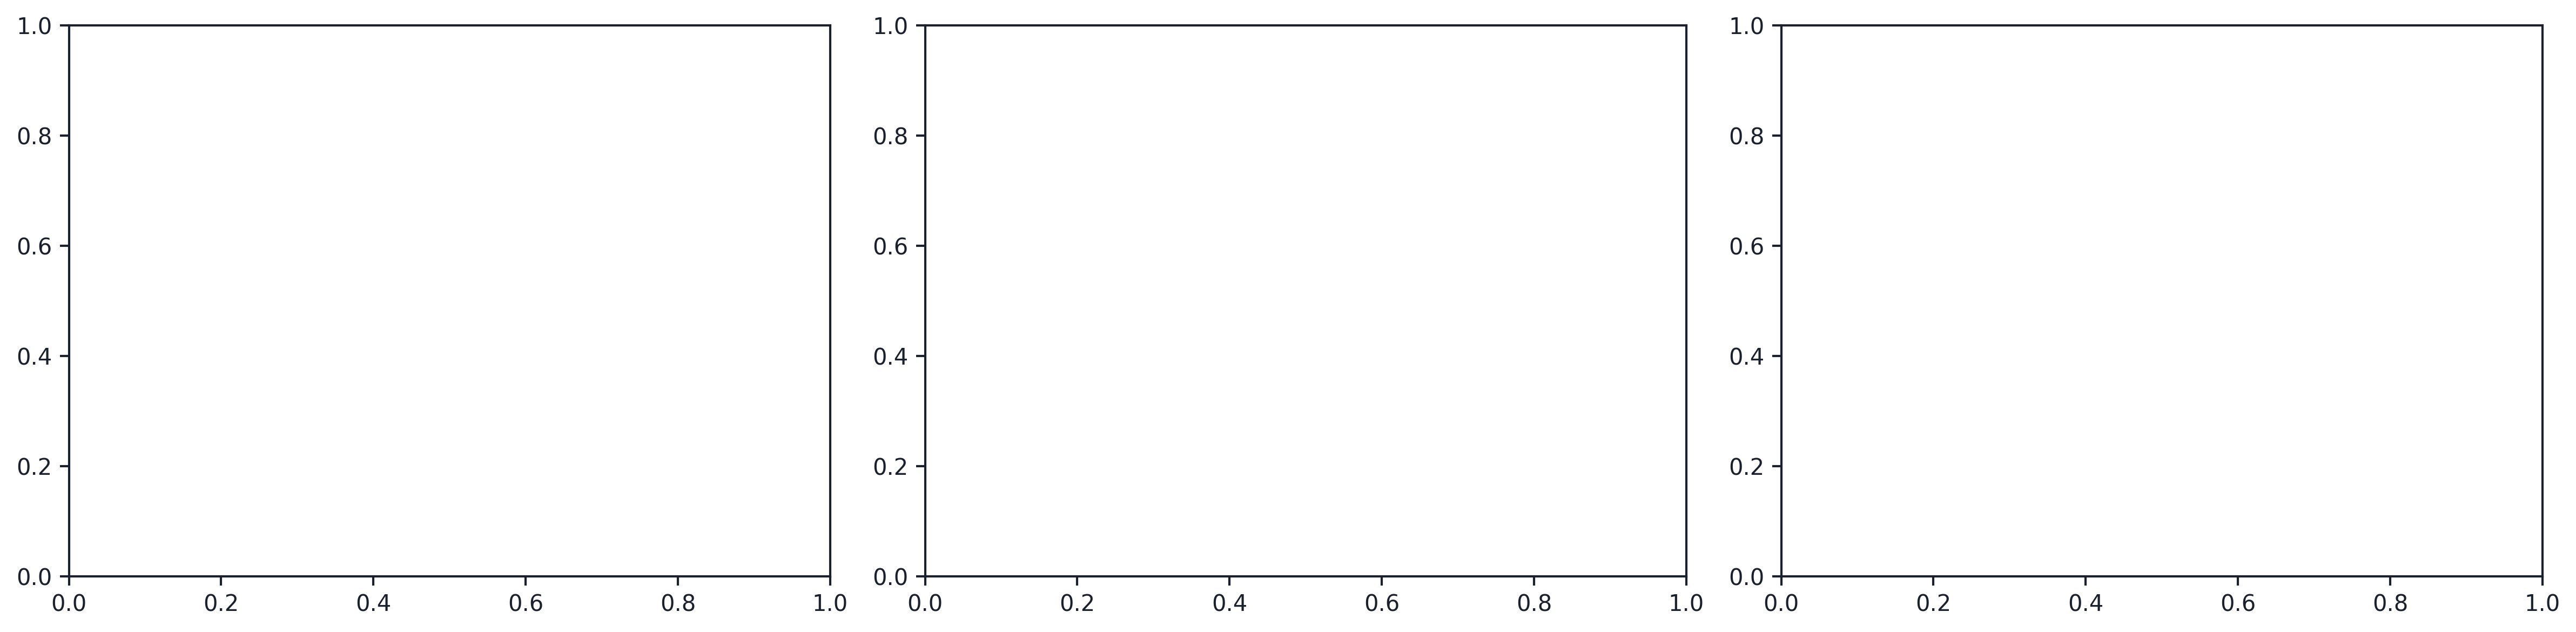

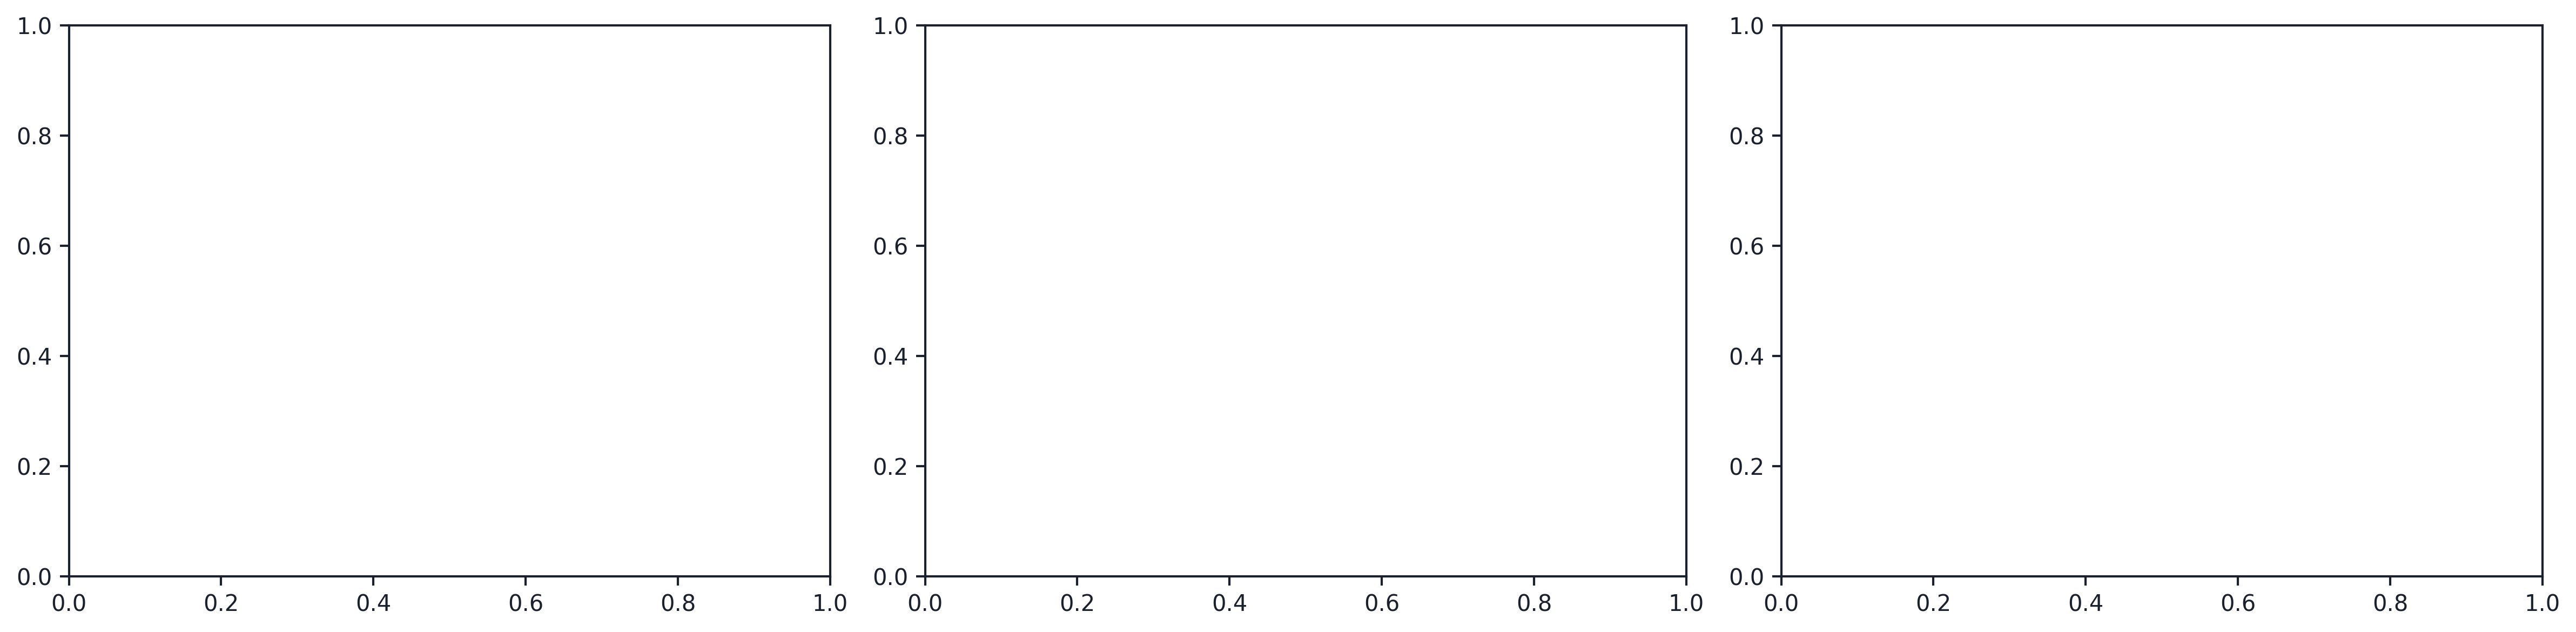

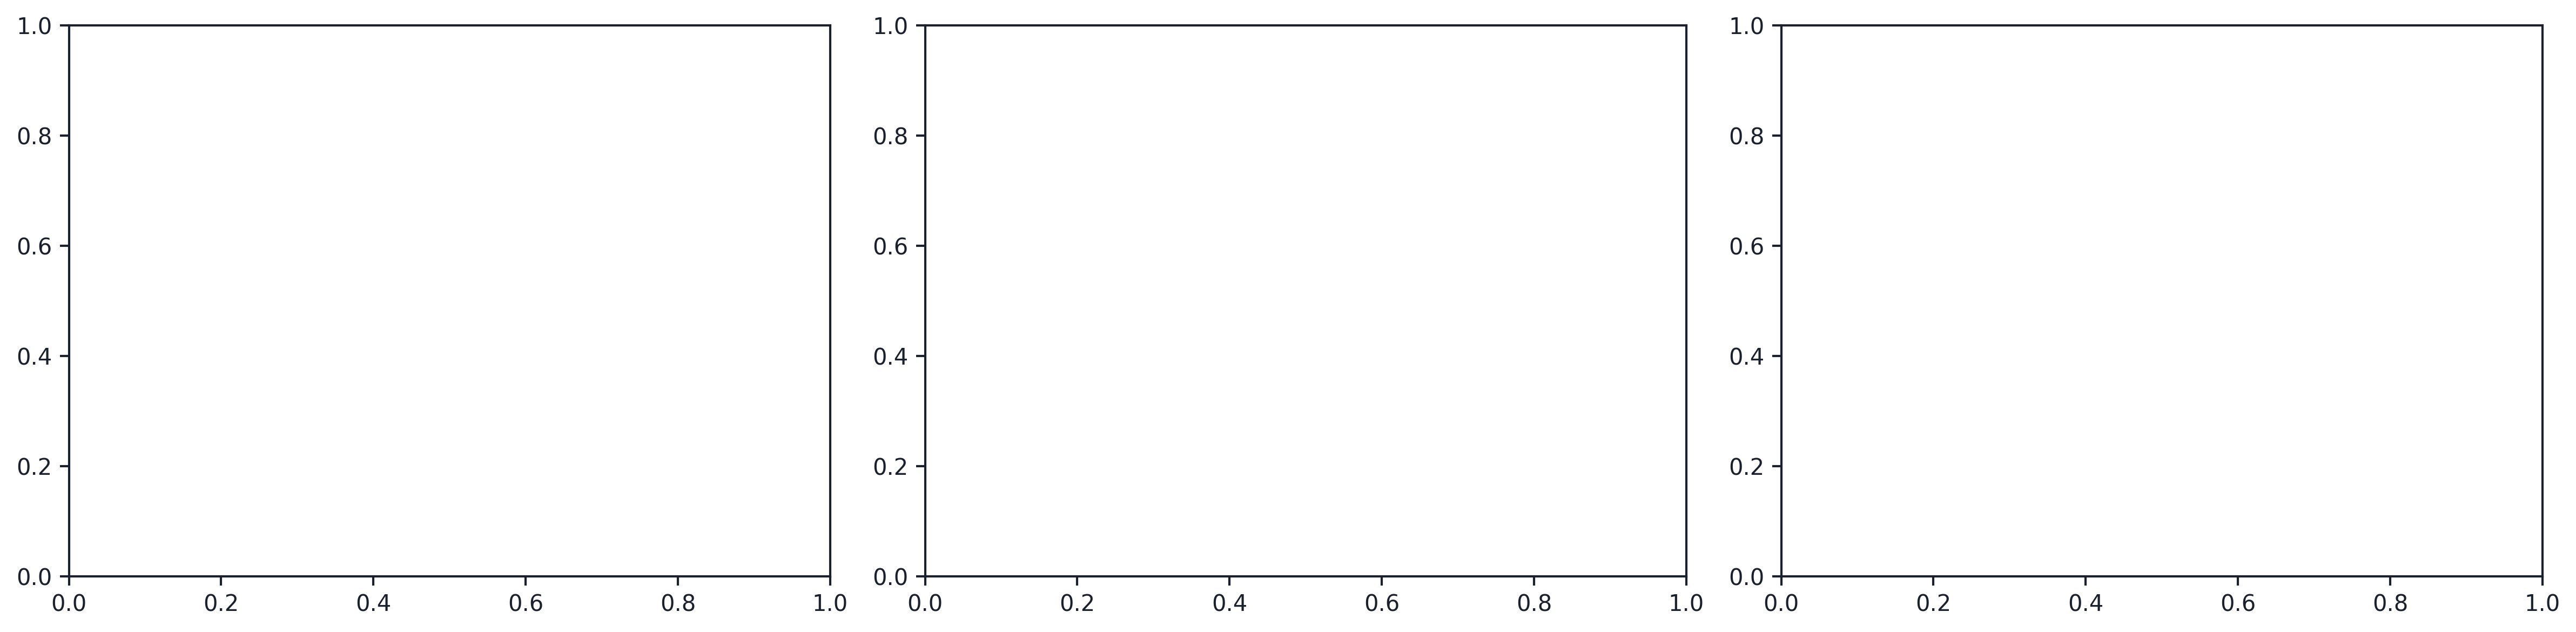

In [ ]:
subset_labels = (class_labels[data_params['subset_idxs'][0]],
                 class_labels[data_params['subset_idxs'][1]])


# Epoch threshold
idx_thresh = [train_params['test_freq']*(epoch - train_params['save_thresh'])+1 for epoch in e_thresh]
n_thresh = idx_thresh[1] - idx_thresh[0] # Number of idxs within the threshold
print('Using epoch threshold:', e_thresh)

class_means = np.zeros((n_trials, n_thresh, n_classes, n_feats))
class_pca_fits = [[[] for _ in range(n_thresh)] for _ in range(n_trials)] 
class_prs = np.zeros((n_trials, n_thresh, n_classes,))
class_pca_means = np.zeros((n_trials, n_thresh, n_classes, n_feats))

epochs = np.linspace(train_params['save_thresh'], train_params['n_epochs'], 
                     train_params['test_freq']*(train_params['n_epochs'] - train_params['save_thresh']))
epochs = np.insert(epochs, 0, 0.0) # Always has initial data, so add 0

class_mean_aligns = np.zeros((n_trials, n_classes, n_thresh, n_thresh))
class_readout_aligns = np.zeros((n_trials, n_classes, n_thresh, n_thresh))
class_readout_angles = np.zeros((n_trials, n_classes, n_thresh, n_thresh))
mean_readout_aligns = np.zeros((n_trials, n_classes, n_thresh, n_thresh)) 

var_var_perc = np.zeros((n_trials, n_classes, n_thresh, n_thresh)) 
var_var_perc_chance = np.zeros((n_trials, n_classes, n_thresh, n_thresh)) 
if n_classes == 2:
    var_var_perc_cross = np.zeros((n_trials, n_thresh, n_thresh)) 

for trial_idx in range(n_trials):
    print('Trial:', trial_idx)
    feature_vals = feat_outs_experiments[trial_idx]
    for time_idx in range(n_thresh):
        time_idx_i = time_idx + idx_thresh[0]
        for class_idx in range(n_classes):
            class_means[trial_idx, time_idx, class_idx] = np.mean(feature_vals[time_idx_i][class_idx], axis=0)
            
            n_feat_space = np.min(feature_vals[time_idx_i][class_idx].shape)
            pca_time_class = PCA(n_components=n_feat_space)

            pca_feats = pca_time_class.fit_transform(feature_vals[time_idx_i][class_idx])
            class_prs[trial_idx, time_idx, class_idx] = participation_ratio_vector(
                pca_time_class.explained_variance_ratio_
            )

            # Removes ambiguity in PCA direction by making sure all means (along PC directions) are positive
            pca_dir_signs = np.sign(np.mean(np.matmul(feature_vals[time_idx_i][class_idx], pca_time_class.components_.T), axis=0))
            for pca_idx, pca_dir in enumerate(pca_time_class.components_):
                pca_time_class.components_[pca_idx, :] = pca_dir_signs[pca_idx] * pca_dir
            class_pca_fits[trial_idx][time_idx].append(pca_time_class)

            class_pca_means[trial_idx, time_idx, class_idx] = np.mean(
                np.matmul(feature_vals[time_idx_i][class_idx], pca_time_class.components_.T), axis=0)
    
    for time_idx in range(n_thresh):
        for time_idx2 in range(n_thresh):
            time_idx_1 = time_idx + idx_thresh[0]
            time_idx_2 = time_idx2 + idx_thresh[0]            
            for class_idx in range(n_classes):
                class_mean_aligns[trial_idx, class_idx, time_idx, time_idx2] = get_align(
                    class_means[trial_idx, time_idx, class_idx],
                    class_means[trial_idx, time_idx2, class_idx]
                )
                class_readout_aligns[trial_idx, class_idx, time_idx, time_idx2] = get_align(
                    readout_w_experiments[trial_idx][time_idx_1][class_idx],
                    readout_w_experiments[trial_idx][time_idx_2][class_idx]
                )
                class_readout_angles[trial_idx, class_idx, time_idx, time_idx2] = get_align_angle(
                    readout_w_experiments[trial_idx][time_idx_1][class_idx],
                    readout_w_experiments[trial_idx][time_idx_2][class_idx]
                )
                mean_readout_aligns[trial_idx, class_idx, time_idx, time_idx2] = get_align(
                    class_means[trial_idx, time_idx, class_idx],
                    readout_w_experiments[trial_idx][time_idx_2][class_idx]
                )

                dim1 = int(np.ceil(class_prs[trial_idx, time_idx, class_idx]))
                dim2 = int(np.ceil(class_prs[trial_idx, time_idx2, class_idx]))
                var_var_perc[trial_idx, class_idx, time_idx, time_idx2] = subspace_perc(
                    class_pca_fits[trial_idx][time_idx][class_idx].components_[:dim1,:].T,
                    class_pca_fits[trial_idx][time_idx2][class_idx].components_[:dim2,:].T
                )
                var_var_perc_chance[trial_idx, class_idx, time_idx, time_idx2] = np.max(
                    (dim1, dim2,)
                ) / n_feats
            if n_classes == 2:
                dim1 = int(np.ceil(class_prs[trial_idx, time_idx, 0]))
                dim2 = int(np.ceil(class_prs[trial_idx, time_idx2, 1]))
                var_var_perc_cross[trial_idx, time_idx, time_idx2] = subspace_perc(
                    class_pca_fits[trial_idx][time_idx][0].components_[:dim1,:].T,
                    class_pca_fits[trial_idx][time_idx2][1].components_[:dim2,:].T
                )

n_time_drift = 1

drift_readout_aligns = np.zeros((n_trials, n_classes, n_thresh-n_time_drift, n_thresh)) 
drift_readout_angles = np.zeros((n_trials, n_classes, n_thresh-n_time_drift, n_thresh))
drift_drift_angle = np.zeros((n_trials, n_classes, n_thresh-n_time_drift, n_thresh-n_time_drift))
if n_classes == 2: # Drift of one population relative to other readout (class_idx is population)
    drift_readout_angles_cross = np.zeros((n_trials, n_classes, n_thresh-n_time_drift, n_thresh))
    drift_drift_angle_cross = np.zeros((n_trials, n_thresh-n_time_drift, n_thresh-n_time_drift))

for trial_idx in range(n_trials):
    drifts = np.zeros((n_classes, n_thresh-n_time_drift, n_feats))
    for time_idx in range(n_thresh - n_time_drift):
        for class_idx in range(n_classes):
            drift = (
                class_means[trial_idx, time_idx+n_time_drift, class_idx] - 
                class_means[trial_idx, time_idx, class_idx]
            )
            drifts[class_idx, time_idx] = drift

    for time_idx in range(n_thresh - n_time_drift):
        for time_idx2 in range(n_thresh): 
            time_idx_1 = time_idx + idx_thresh[0]
            time_idx_2 = time_idx2 + idx_thresh[0]
            for class_idx in range(n_classes):
                drift_readout_aligns[trial_idx, class_idx, time_idx, time_idx2] = get_align(
                    drifts[class_idx, time_idx],
                    readout_w_experiments[trial_idx][time_idx_2][class_idx]
                )
                drift_readout_angles[trial_idx, class_idx, time_idx, time_idx2] = get_align_angle(
                    drifts[class_idx, time_idx],
                    readout_w_experiments[trial_idx][time_idx_2][class_idx]
                )
            if n_classes == 2: # Angle of one population's drift relative to the other readout vector
                drift_readout_angles_cross[trial_idx, 0, time_idx, time_idx2] = get_align_angle(
                    drifts[0, time_idx],
                    readout_w_experiments[trial_idx][time_idx_2][1]
                )
                drift_readout_angles_cross[trial_idx, 1, time_idx, time_idx2] = get_align_angle(
                    drifts[1, time_idx],
                    readout_w_experiments[trial_idx][time_idx_2][0]
                )
        for time_idx2 in range(n_thresh - n_time_drift): 
            for class_idx in range(n_classes):
                drift_drift_angle[trial_idx, class_idx, time_idx, time_idx2] = get_align_angle(
                    drifts[class_idx, time_idx], drifts[class_idx, time_idx2]
                )
            if n_classes == 2:
                drift_drift_angle_cross[trial_idx, time_idx, time_idx2] = get_align_angle(
                    drifts[0, time_idx], drifts[1, time_idx2]
                )

fig, ax = plt.subplots(1, 3, figsize=(16,4))
fig2, ax2 = plt.subplots(1, 3, figsize=(16,4))
fig3, ax3 = plt.subplots(1, 3, figsize=(16,4))

avg_class_mags = np.mean(np.linalg.norm(class_means, axis=-1), axis=0)
avg_class_mean_aligns = np.mean(class_mean_aligns, axis=0)
avg_class_readout_aligns = np.mean(class_readout_aligns, axis=0)
avg_class_readout_angles = np.mean(class_readout_angles, axis=0)
avg_mean_readout_aligns = np.mean(mean_readout_aligns, axis=0)

avg_drift_readout_aligns = np.mean(drift_readout_aligns, axis=0)
avg_drift_readout_angles = np.mean(drift_readout_angles, axis=0)

align_plots = []
align_plots_2 = []
align_plots_3 = []

for class_idx in range(n_classes):
    ax[0].plot(epochs, avg_class_mags[:, class_idx], color=c_vals[class_idx])
    align_plots.append(ax[class_idx+1].matshow(avg_class_mean_aligns[class_idx], cmap='bwr',
                            vmin=-1, vmax=1))
    # align_plots.append(ax[class_idx+1].matshow(avg_class_mean_aligns[class_idx], cmap='bwr',
    #                         vmin=-1, vmax=1))
    plt.colorbar(align_plots[class_idx], ax=ax[class_idx+1])

    align_plots_2.append(ax2[class_idx+1].matshow(
        avg_class_readout_angles[class_idx, :n_thresh, :n_thresh], 
        vmin=0.0, vmax=180, cmap='RdBu'
    ))
    plt.colorbar(align_plots_2[class_idx], ax=ax2[class_idx+1])
    align_plots_3.append(ax3[class_idx+1].matshow(avg_mean_readout_aligns[class_idx],
                                                  vmin=-1.0, vmax=1.0, cmap='RdBu'))
    plt.colorbar(align_plots_3[class_idx], ax=ax3[class_idx+1])

align_plots4 = ax2[0].matshow(avg_drift_readout_angles[0, :n_thresh, :n_thresh], 
                              vmin=0.0, vmax=180.0, cmap='RdBu')
plt.colorbar(align_plots4, ax=ax2[0])

ax[0].legend()
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Mean magnitude')

ax[1].set_xlim([400, 500])
ax[1].set_ylim([400, 500])

for ax_i in (ax[1], ax[2], ax2[0], ax2[1], ax2[2], ax3[1], ax3[2]):
    ax_i.set_xlabel('Epoch')
    ax_i.set_ylabel('Epoch')

ax[1].set_title('Mean Aligns, Class: {}'.format(class_labels[0]))
ax[2].set_title('Mean Aligns, Class: {}'.format(class_labels[1]))

ax2[0].set_title('Drift-Readout Aligns, Class: {}'.format(class_labels[0]))
for ax_it in (ax2[0], ax2[1], ax2[2]):
    ax_it.set_xticks([0, n_thresh])
    ax_it.set_xticklabels([e_thresh[0], e_thresh[1]])
    ax_it.set_yticks([0, n_thresh])
    ax_it.set_yticklabels([e_thresh[0], e_thresh[1]])
# ax2[1].set_title('Readout Aligns, Class: {}'.format(class_labels[0]))
# ax2[2].set_title('Readout Aligns, Class: {}'.format(class_labels[1]))

ax3[1].set_title('Mean-Readout Aligns, Class: {}'.format(class_labels[0]))
ax3[2].set_title('Mean-Readout Aligns, Class: {}'.format(class_labels[1]))

Random deivation: 5.000806101698661
Largest ro angle change: 2.7 (std 0.3)
Cross drift angle: 40.4 (std 4.9)


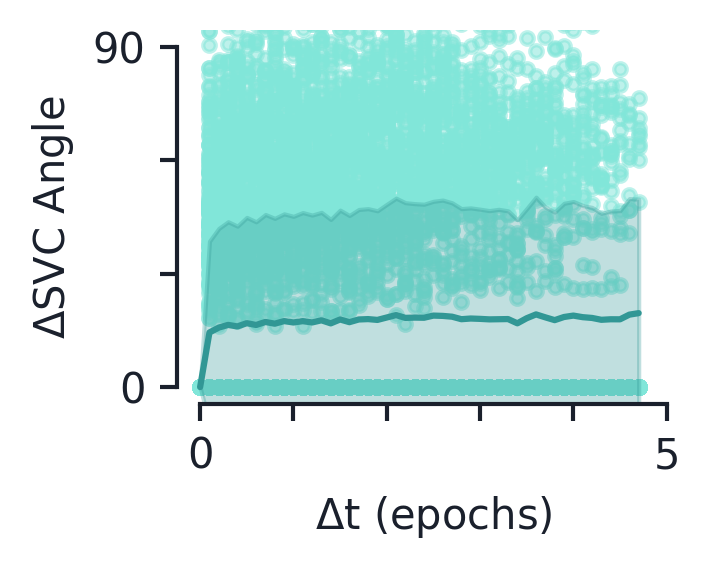

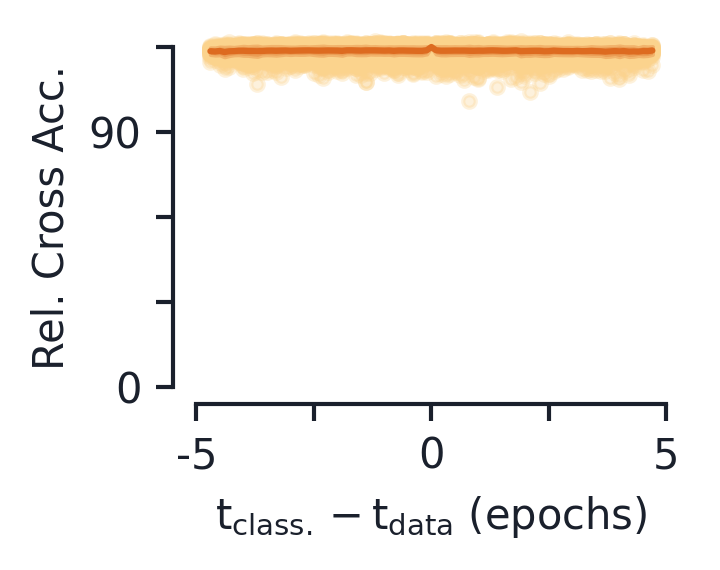

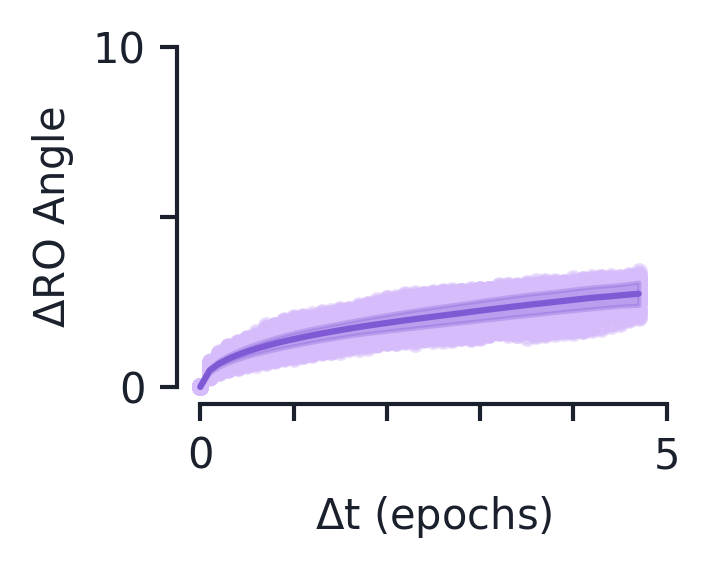

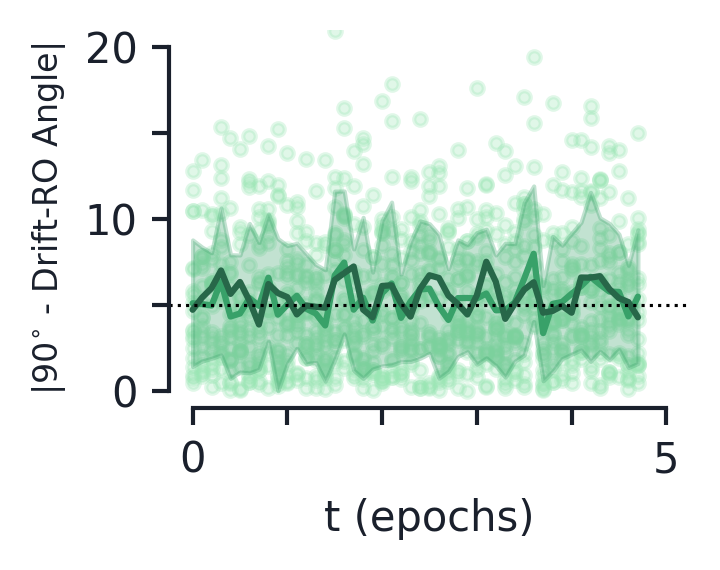

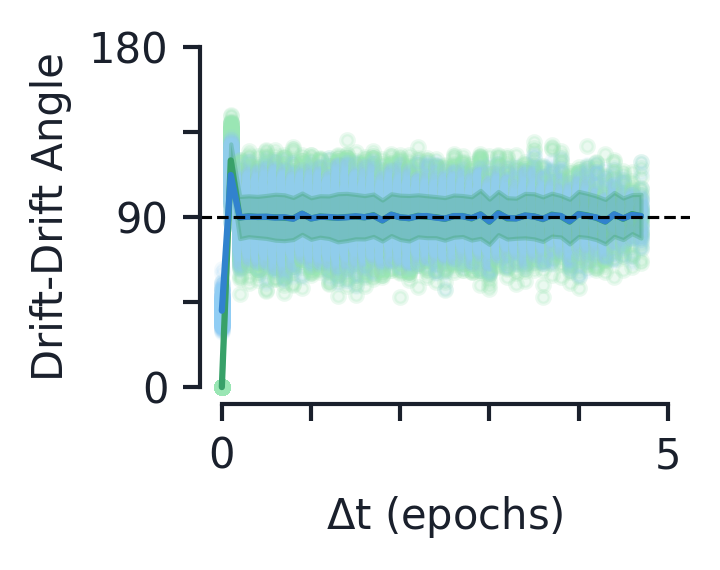

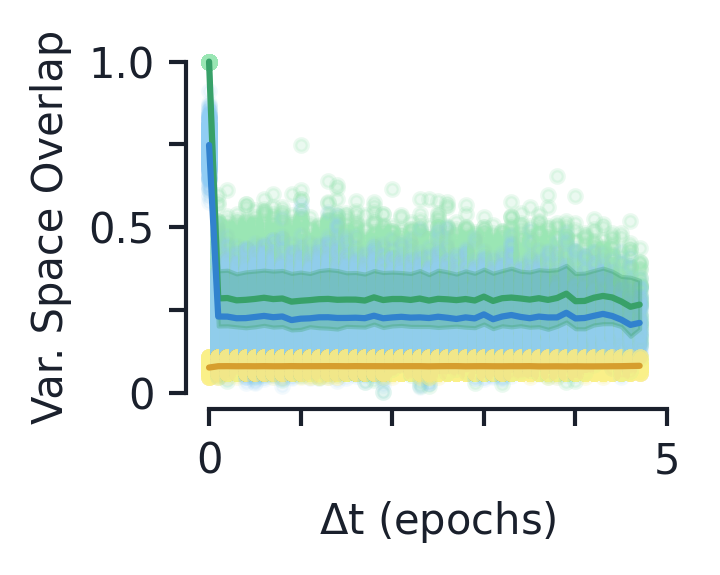

In [ ]:
deltat_max = 48

times = [[] for _ in range(deltat_max)]
delta_ts = [[] for _ in range(deltat_max)]
drift_delta_ts = [[] for _ in range(deltat_max)]
delta_ts_class = [[] for _ in range(deltat_max)]
drift_delta_ts_class = [[] for _ in range(deltat_max)]
time_diffs = [[] for _ in range(2*deltat_max-1)]
cross_accs_rel_dt = [[] for _ in range(2*deltat_max-1)]
cross_angles_dt = [[] for _ in range(deltat_max)]
ro_angles_dt = [[] for _ in range(deltat_max)] 
drift_ro_angles_dt = [[] for _ in range(deltat_max)]
drift_ro_angles_cross_dt = [[] for _ in range(deltat_max)]

drift_drift_angles_dt = [[] for _ in range(deltat_max)]
drift_drift_angles_cross_dt = [[] for _ in range(deltat_max)]
var_var_perc_dt = [[] for _ in range(deltat_max)]
var_var_perc_cross_dt = [[] for _ in range(deltat_max)]
var_var_perc_chance_dt = [[] for _ in range(deltat_max)]

for time_idx_d in range(n_thresh):
    for time_idx_c in range(n_thresh):
        deltat = np.abs(time_idx_c - time_idx_d)
        time_diff = time_idx_c - time_idx_d
        if deltat < deltat_max: # If under thershold
            for trial_idx in range(n_trials):
                delta_ts[deltat].append(deltat)
                cross_angles_dt[deltat].append(cross_angles_trial[trial_idx, time_idx_c, time_idx_d])

                time_diffs[time_diff+deltat_max-1].append(time_diff)
                cross_accs_rel_dt[time_diff+deltat_max-1].append(
                    cross_accs_rel_trial[trial_idx, time_idx_c, time_idx_d]
                )
                var_var_perc_cross_dt[deltat].append(
                    var_var_perc_cross[trial_idx, time_idx_c, time_idx_d]
                )
                if time_idx_d < n_thresh-n_time_drift and time_idx_c < n_thresh-n_time_drift:
                    drift_delta_ts[deltat].append(deltat)
                    drift_drift_angles_cross_dt[deltat].append(
                            drift_drift_angle_cross[trial_idx, time_idx_c, time_idx_d]
                        )
                for class_idx in range(n_classes):
                    delta_ts_class[deltat].append(deltat)
                    ro_angles_dt[deltat].append(
                        class_readout_angles[trial_idx, class_idx, time_idx_c, time_idx_d]
                    )
                    if time_idx_d < n_thresh-n_time_drift and time_idx_c < n_thresh-n_time_drift:
                        drift_delta_ts_class[deltat].append(deltat)
                        drift_drift_angles_dt[deltat].append(
                            drift_drift_angle[trial_idx, class_idx, time_idx_c, time_idx_d]
                        )
                    var_var_perc_dt[deltat].append(
                        var_var_perc[trial_idx, class_idx, time_idx_c, time_idx_d]
                    )
                    var_var_perc_chance_dt[deltat].append(
                        var_var_perc_chance[trial_idx, class_idx, time_idx_c, time_idx_d]
                    )
    # Now just absolute time data
    if time_idx_d < deltat_max:
        for trial_idx in range(n_trials):
            for class_idx in range(n_classes):
                times[time_idx_d].append(time_idx_d)
                drift_ro_angles_dt[time_idx_d].append(
                    np.abs(90 - drift_readout_angles[trial_idx, class_idx, time_idx_d, time_idx_d])
                )
                drift_ro_angles_cross_dt[time_idx_d].append(
                    np.abs(90 - drift_readout_angles_cross[trial_idx, class_idx, time_idx_d, time_idx_d])
                )

rand_angle_trials = 1000
rand_devs = np.zeros((rand_angle_trials,))
unit_vec = np.zeros((n_feats,))
unit_vec[0] = 1.0
for idx in range(rand_angle_trials):
    rand_devs[idx] = np.abs(90 - get_align_angle(
        unit_vec, np.random.normal(size=n_feats)
    ))

print('Random deivation:', rand_devs.mean())


fig0, ax0 = plt.subplots(1, 1, figsize=(2.5, 2)) # SVC Angle
fig1, ax1 = plt.subplots(1, 1, figsize=(2.5, 2)) # SVC Cross acc
fig2, ax2 = plt.subplots(1, 1, figsize=(2.5, 2)) # RO angle change
fig3, ax3 = plt.subplots(1, 1, figsize=(2.5, 2)) # drift RO angle
fig4, ax4 = plt.subplots(1, 1, figsize=(2.5, 2)) # Drift angles
fig5, ax5 = plt.subplots(1, 1, figsize=(2.5, 2)) # Var space overlaps

# Colors
ax0_ci = 5
ax1_ci = 4
ax2_ci = 3
ax3_ci = 2

avg_cross_angles = []
std_cross_angles = []
avg_cross_accs_rel = []
std_cross_accs_rel = []
avg_ro_angles = []
std_ro_angles = []
avg_drift_ro_angles_dt = []
std_drift_ro_angles_dt = []
avg_drift_ro_angles_cross_dt = []

avg_ro_ro_angles = []
std_ro_ro_angles = []
avg_ro_ro_cross = []
avg_var_var_perc = []
std_var_var_perc = []
avg_var_var_cross = []
avg_var_var_chance = []

for time_idx in range(2*deltat_max-1):
    ax1.scatter(time_diffs[time_idx], cross_accs_rel_dt[time_idx],
                color=c_vals_l[ax1_ci], alpha=0.3, marker='.')
    avg_cross_accs_rel.append(np.mean(cross_accs_rel_dt[time_idx]))
    std_cross_accs_rel.append(np.std(cross_accs_rel_dt[time_idx]))
    if time_idx < deltat_max: # Abs time diff plots
        ax0.scatter(delta_ts[time_idx], cross_angles_dt[time_idx],
                    color=c_vals_l[ax0_ci], alpha=0.3, marker='.')
        avg_cross_angles.append(np.mean(cross_angles_dt[time_idx]))
        std_cross_angles.append(np.std(cross_angles_dt[time_idx]))

        ax2.scatter(delta_ts_class[time_idx], ro_angles_dt[time_idx],
                    color=c_vals_l[ax2_ci], alpha=0.3, marker='.')
        avg_ro_angles.append(np.mean(ro_angles_dt[time_idx]))
        std_ro_angles.append(np.std(ro_angles_dt[time_idx]))

        ax3.scatter(times[time_idx], drift_ro_angles_dt[time_idx], 
                    color=c_vals_l[ax3_ci], alpha=0.3, marker='.')
        avg_drift_ro_angles_dt.append(np.mean(drift_ro_angles_dt[time_idx]))
        std_drift_ro_angles_dt.append(np.std(drift_ro_angles_dt[time_idx]))
        avg_drift_ro_angles_cross_dt.append(np.mean(drift_ro_angles_cross_dt[time_idx]))

        ax4.scatter(drift_delta_ts_class[time_idx], drift_drift_angles_dt[time_idx],
                    color=c_vals_l[2], alpha=0.1, marker='.')
        ax4.scatter(drift_delta_ts[time_idx], drift_drift_angles_cross_dt[time_idx],
                    color=c_vals_l[1], alpha=0.1, marker='.')
        avg_ro_ro_angles.append(np.mean(drift_drift_angles_dt[time_idx]))
        std_ro_ro_angles.append(np.std(drift_drift_angles_dt[time_idx]))
        avg_ro_ro_cross.append(np.mean(drift_drift_angles_cross_dt[time_idx]))

        ax5.scatter(delta_ts_class[time_idx], var_var_perc_dt[time_idx],
                    color=c_vals_l[2], alpha=0.1, marker='.')
        ax5.scatter(delta_ts[time_idx], var_var_perc_cross_dt[time_idx],
                    color=c_vals_l[1], alpha=0.1, marker='.')
        ax5.scatter(delta_ts_class[time_idx], var_var_perc_chance_dt[time_idx],
                    color=c_vals_l[8], alpha=0.1, marker='.')
        
        avg_var_var_perc.append(np.mean(var_var_perc_dt[time_idx]))
        std_var_var_perc.append(np.std(var_var_perc_dt[time_idx]))
        avg_var_var_cross.append(np.mean(var_var_perc_cross_dt[time_idx]))
        avg_var_var_chance.append(np.mean(var_var_perc_chance_dt[time_idx]))

ax0.fill_between(np.arange(deltat_max),
                 np.array(avg_cross_angles)-np.array(std_cross_angles),
                 np.array(avg_cross_angles)+np.array(std_cross_angles),
                 color=c_vals[ax0_ci], alpha=0.3)
ax0.plot(np.arange(deltat_max), avg_cross_angles, color=c_vals[ax0_ci])

ax1.fill_between(np.arange(-deltat_max+1, deltat_max),
                 np.array(avg_cross_accs_rel)-np.array(std_cross_accs_rel),
                 np.array(avg_cross_accs_rel)+np.array(std_cross_accs_rel),
                 color=c_vals[ax1_ci], alpha=0.3)
ax1.plot(np.arange(-deltat_max+1, deltat_max), avg_cross_accs_rel, color=c_vals[ax1_ci])

ax2.fill_between(np.arange(deltat_max),
                 np.array(avg_ro_angles)-np.array(std_ro_angles),
                 np.array(avg_ro_angles)+np.array(std_ro_angles),
                 color=c_vals[ax2_ci], alpha=0.3)
ax2.plot(np.arange(deltat_max), avg_ro_angles, color=c_vals[ax2_ci])
print('Largest ro angle change: {:.1f} (std {:.1f})'.format(
    avg_ro_angles[-1], std_ro_angles[-1]
    ))

ax3.fill_between(np.arange(deltat_max),
                 np.array(avg_drift_ro_angles_dt)-np.array(std_drift_ro_angles_dt),
                 np.array(avg_drift_ro_angles_dt)+np.array(std_drift_ro_angles_dt),
                 color=c_vals[ax3_ci], alpha=0.3)
ax3.plot(np.arange(deltat_max), avg_drift_ro_angles_dt, color=c_vals[ax3_ci])
ax3.plot(np.arange(deltat_max), avg_drift_ro_angles_cross_dt, color=c_vals_d[ax3_ci])


ax4.fill_between(np.arange(deltat_max),
                 np.array(avg_ro_ro_angles)-np.array(std_ro_ro_angles),
                 np.array(avg_ro_ro_angles)+np.array(std_ro_ro_angles),
                 color=c_vals[2], alpha=0.3)
ax4.plot(np.arange(deltat_max), avg_ro_ro_angles, color=c_vals[2])
ax4.plot(np.arange(deltat_max), avg_ro_ro_cross, color=c_vals[1])

ax5.fill_between(np.arange(deltat_max),
                 np.array(avg_var_var_perc)-np.array(std_var_var_perc),
                 np.array(avg_var_var_perc)+np.array(std_var_var_perc),
                 color=c_vals[2], alpha=0.3)
ax5.plot(np.arange(deltat_max), avg_var_var_perc, color=c_vals[2])
ax5.plot(np.arange(deltat_max), avg_var_var_cross, color=c_vals[1])
ax5.plot(np.arange(deltat_max), avg_var_var_chance, color=c_vals[8])

ax0.set_xlabel('$\Delta$t (epochs)')
ax0.set_xlim([0, deltat_max])
ax0.set_xticks([0, 10, 20, 30, 40, 50])
ax0.set_xticklabels([0, None, None, None, None, 5])
ax0.set_ylabel('$\Delta$SVC Angle')
ax0.set_ylim([0, 90])
ax0.set_yticks([0, 30, 60, 90])
ax0.set_yticklabels([0, None, None, 90])

ax1.set_xlabel('$t_{class.} - t_{data}$ (epochs)')
ax1.set_xlim([-deltat_max, deltat_max])
ax1.set_xticks([-50, -25, 0, 25, 50])
ax1.set_xticklabels([-5, None, 0, None, 5])
ax1.set_ylabel('Rel. Cross Acc.')
ax1.set_ylim([0, 1])
ax1.set_yticks([0, .25, 0.5, 0.75, 1.0])
ax1.set_yticklabels([0, None, None, 90])

ax2.set_xlabel('$\Delta$t (epochs)')
ax2.set_xlim([0, deltat_max])
ax2.set_xticks([0, 10, 20, 30, 40, 50])
ax2.set_xticklabels([0, None, None, None, None, 5])
ax2.set_ylabel('$\Delta$RO Angle')
ax2.set_ylim([0, 10])
ax2.set_yticks([0, 5, 10])
ax2.set_yticklabels([0, None, 10])

ax3.set_xlabel('t (epochs)')
ax3.set_xlim([0, deltat_max])
ax3.set_xticks([0, 10, 20, 30, 40, 50])
ax3.set_xticklabels([0, None, None, None, None, 5])
ax3.set_ylabel('|$90^{\circ}$ - Drift-RO Angle|', fontsize=8)
ax3.set_ylim([0, 20])
ax3.set_yticks([0, 5, 10, 15, 20])
ax3.set_yticklabels([0, None, 10, None, 20])
ax3.axhline(rand_devs.mean(), color='k', linestyle='dotted', linewidth=0.75)

ax4.set_xlabel('$\Delta$t (epochs)')
ax4.set_xlim([0, deltat_max])
ax4.set_xticks([0, 10, 20, 30, 40, 50])
ax4.set_xticklabels([0, None, None, None, None, 5])
ax4.set_ylabel('Drift-Drift Angle')
ax4.set_ylim([0, 180])
ax4.set_yticks([0, 45, 90, 135, 180])
ax4.set_yticklabels([0, None, 90, None, 180])
ax4.axhline(90, color='k', linestyle='dashed', linewidth=0.75)

print('Cross drift angle: {:.1f} (std {:.1f})'.format(
    avg_ro_ro_cross[0], np.std(drift_drift_angles_cross_dt[0])
))

ax5.set_xlabel('$\Delta$t (epochs)')
ax5.set_xlim([0, deltat_max])
ax5.set_xticks([0, 10, 20, 30, 40, 50])
ax5.set_xticklabels([0, None, None, None, None, 5])
ax5.set_ylabel('Var. Space Overlap')
ax5.set_ylim([0, 1])
ax5.set_yticks([0, .25, 0.5, 0.75, 1.0])
ax5.set_yticklabels([0, None, 0.5, None, 1.0])

jetplot.breathe(ax=ax0)
jetplot.breathe(ax=ax1)
jetplot.breathe(ax=ax2)
jetplot.breathe(ax=ax3)
jetplot.breathe(ax=ax4)
jetplot.breathe(ax=ax5)

This tests how well SVCs can distinguish between sessions versus null of even/odd trials

In [ ]:
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

# Epoch threshold
e_thresh = (60, 61)
idx_thresh = [train_params['test_freq']*(epoch - train_params['save_thresh'])+1 for epoch in e_thresh]
n_thresh = idx_thresh[1] - idx_thresh[0] # Number of idxs within the threshold
print('Using epoch threshold:', e_thresh)

n_folds = 10
n_feats = feat_outs_experiments[0][0][0].shape[1]

n_time_drift = 5 # Number of idx steps to check drift

drift_accs = np.zeros((n_trials, n_classes, n_thresh-n_time_drift))
eo_accs = np.zeros((n_trials, n_classes, n_thresh-n_time_drift))

for trial_idx in range(n_trials):
    print('Trial:', trial_idx)
    feature_vals = feat_outs_experiments[trial_idx]
    readout_ws = readout_w_experiments[trial_idx]

    for class_idx in range(n_classes):
        for time_idx in range(n_thresh-n_time_drift):
            
            # print('  Time:', time_idx)
            init_time_idx = idx_thresh[0] + time_idx
            final_time_idx = idx_thresh[0] + time_idx + n_time_drift

            # Create the classification data 
            X_data = []
            y_labels = []
            
            # Initial time (label: 0)
            X_data.append(feature_vals[init_time_idx][class_idx])
            y_labels.append(0 * np.ones(
                feature_vals[init_time_idx][class_idx].shape[0], 
                dtype=np.int32
            ))
            # Final time (label: 1)
            X_data.append(feature_vals[final_time_idx][class_idx])
            y_labels.append(1 * np.ones(
                feature_vals[final_time_idx][class_idx].shape[0], 
                dtype=np.int32
            ))

            X_data = np.concatenate(X_data, axis=0)
            y_labels = np.concatenate(y_labels, axis=0)

            # Shuffle the classification data
            arr_idxs = np.arange(X_data.shape[0])
            np.random.seed(10)
            np.random.shuffle(arr_idxs)
            X_data = X_data[arr_idxs]
            y_labels = y_labels[arr_idxs]

            raw_accs = np.zeros((n_folds,))
            # k-Fold Cross validation, saving the model details at each step
            kf = KFold(n_splits=n_folds)

            for fold_idx, (train_index, test_index) in enumerate(kf.split(X_data)):
                X_train, X_test = X_data[train_index], X_data[test_index]
                y_train, y_test = y_labels[train_index], y_labels[test_index]

                # SVC classifier
                clf = svm.LinearSVC(class_weight='balanced', fit_intercept=True, max_iter=100000)

                clf.fit(X_train, y_train)
                y_pred = clf.predict(X_test)
                raw_accs[fold_idx] = np.sum(y_pred == y_test) / y_test.shape[0]

            drift_accs[trial_idx, class_idx, time_idx] = np.mean(raw_accs)

            ####### Even/odd classification ##########
            X_data = []
            y_labels = []
            
            n_samples_2 = int(np.floor(feature_vals[init_time_idx][class_idx].shape[0]/2))

            # Evens (label: 0)
            X_data.append(feature_vals[init_time_idx][class_idx][0:2*n_samples_2:2, :])
            y_labels.append(0 * np.ones(
                (n_samples_2,), 
                dtype=np.int32
            ))
            # Odds (label: 1)
            X_data.append(feature_vals[init_time_idx][class_idx][1:2*n_samples_2:2, :])
            y_labels.append(1 * np.ones(
                (n_samples_2,), 
                dtype=np.int32
            ))

            X_data = np.concatenate(X_data, axis=0)
            y_labels = np.concatenate(y_labels, axis=0)

            # Shuffle the classification data
            arr_idxs = np.arange(X_data.shape[0])
            np.random.seed(10)
            np.random.shuffle(arr_idxs)
            X_data = X_data[arr_idxs]
            y_labels = y_labels[arr_idxs]

            raw_accs = np.zeros((n_folds,))
            # k-Fold Cross validation, saving the model details at each step
            kf = KFold(n_splits=n_folds)

            for fold_idx, (train_index, test_index) in enumerate(kf.split(X_data)):
                X_train, X_test = X_data[train_index], X_data[test_index]
                y_train, y_test = y_labels[train_index], y_labels[test_index]

                # SVC classifier
                # clf = svm.LinearSVC(class_weight=class_weights, fit_intercept=False)
                clf = svm.LinearSVC(class_weight='balanced', fit_intercept=True, max_iter=100000)
                # clf = svm.LinearSVC(fit_intercept=False)

                clf.fit(X_train, y_train)
                y_pred = clf.predict(X_test)
                raw_accs[fold_idx] = np.sum(y_pred == y_test) / y_test.shape[0]

            eo_accs[trial_idx, class_idx, time_idx] = np.mean(raw_accs)

# Average over classes and times
avg_drift_accs = np.mean(drift_accs, axis=(1,2))
avg_eo_accs = np.mean(eo_accs, axis=(1,2))

print('Drift accs: {:.2f} (std {:.3f})'.format(avg_drift_accs.mean(), avg_drift_accs.std()))
print('EO accs: {:.2f} (std {:.3f})'.format(avg_eo_accs.mean(), avg_eo_accs.std()))

Using epoch threshold: (60, 61)
Trial: 0
Trial: 1
Trial: 2
Trial: 3
Trial: 4
Trial: 5
Trial: 6
Trial: 7
Trial: 8
Trial: 9
Drift accs: 1.00 (std 0.000)
EO accs: 0.49 (std 0.008)


In [ ]:
print('Drift accs: {:.4f} (std {:.4f})'.format(avg_drift_accs.mean(), avg_drift_accs.std()))
print('EO accs: {:.3f} (std {:.3f})'.format(avg_eo_accs.mean(), avg_eo_accs.std()))

Drift accs: 1.0000 (std 0.0000)
EO accs: 0.493 (std 0.008)


Are they really linearly separable? Let's plot them

(2000, 84)
(2000,)
(2000, 84)


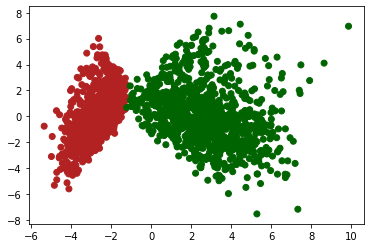

In [ ]:
print(X_data.shape)
print(y_labels.shape)

color_vals = [c_vals[idx] for idx in y_labels]

test_pca = PCA(n_components=n_feats)
X_pca = test_pca.fit_transform(X_data)

print(X_pca.shape)

plt.scatter(X_pca[:, 0], X_pca[:, 1], color=color_vals)

Performs PCA fit on the class means to visualize the drift during training

Means PR: 10.95


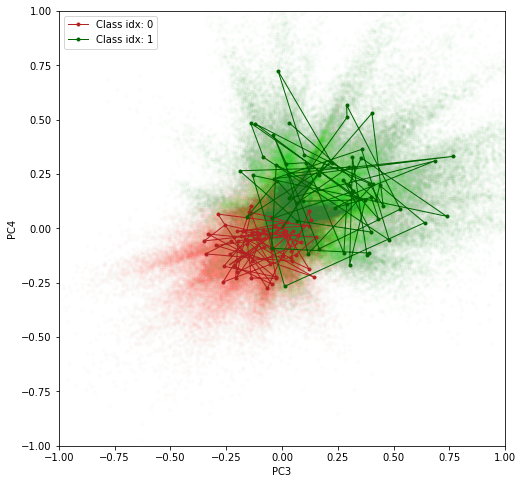

In [ ]:
# PCA on class means

class_means = np.zeros((n_trials, n_times, n_classes, n_feats))
class_pca_fits = [[[] for _ in range(n_times)] for _ in range(n_trials)] 

epochs = np.linspace(0, train_params['n_epochs'], 
                     train_params['test_freq']*train_params['n_epochs']+1)

trial_idx = 0

feature_vals = feat_outs_experiments[trial_idx]
for time_idx in range(len(feat_outs)):
    for class_idx in range(n_classes):
        class_means[trial_idx, time_idx, class_idx] = np.mean(feature_vals[time_idx][class_idx], axis=0)
        
        # n_feat_space = np.min(feature_vals[time_idx][class_idx].shape)
        # pca_time_class = PCA(n_components=n_feat_space)

        # pca_feats = pca_time_class.fit_transform(feature_vals[time_idx][class_idx])

        # # Removes ambiguity in PCA direction by making sure all means (along PC directions) are positive
        # pca_dir_signs = np.sign(np.mean(np.matmul(feature_vals[time_idx][class_idx], pca_time_class.components_.T), axis=0))
        # for pca_idx, pca_dir in enumerate(pca_time_class.components_):
        #     pca_time_class.components_[pca_idx, :] = pca_dir_signs[pca_idx] * pca_dir
        # class_pca_fits[trial_idx][time_idx].append(pca_time_class)

pc1 = 3
pc2 = 4

thresh_idx = 40 * train_params['test_freq']

all_means = np.concatenate([class_means[trial_idx, thresh_idx:, i] for i in range(n_classes)], axis=0)

means_pca = PCA()
means_pca.fit(all_means)

print('Means PR: {:.2f}'.format(participation_ratio_vector(means_pca.explained_variance_ratio_)))


fig, ax = plt.subplots(1, 1, figsize=(8,8))

readouts_trial = np.array(readout_w_experiments[trial_idx])
readouts_pca = np.matmul(readouts_trial, means_pca.components_)

for class_idx in range(n_classes):
    for time_idx in range(len(feat_outs)):
        featout_pca = np.matmul(feat_outs_experiments[trial_idx][time_idx][class_idx],
                                means_pca.components_)
        ax.plot(featout_pca[:, pc1], featout_pca[:, pc2], linewidth = 0.0,
                marker = '.', color=c_vals_l[class_idx], alpha=0.01)

for class_idx in range(n_classes):
    class_means_pca = np.matmul(class_means[trial_idx, thresh_idx:, class_idx], means_pca.components_)
    ax.plot(class_means_pca[:, pc1], class_means_pca[:, pc2], linewidth = 1.0,
            marker = '.', color=c_vals[class_idx], 
            label=f'Class idx: {class_idx}')

    ax.plot([0, readouts_pca[-1, class_idx, pc1]], 
            [0, readouts_pca[-1, class_idx, pc2]], 
            color=c_vals[class_idx])
    
ax.legend()
ax.set_xlabel(f'PC{pc1}')
ax.set_ylabel(f'PC{pc2}')

p_val = 1
if p_val is not None:
    ax.set_xlim([-p_val, p_val])
    ax.set_ylim([-p_val, p_val])

In [ ]:
readouts_trial = np.array(readout_w_experiments[trial_idx])
readouts_trial.shape

(1001, 2, 84)

#### Delta time dependence

Linear fit to lots of delta t.

In [ ]:
from sklearn.decomposition import PCA
from scipy.stats import linregress

def participation_ratio_vector(C):
    """Computes the participation ratio of a vector of variances."""
    return np.sum(C) ** 2 / np.sum(C*C)

def get_align(x, y):
     return np.dot(x,y)/(
         np.linalg.norm(x) * np.linalg.norm(y)
     )

def subspace_perc(A, b):
    """
    A: an N x M matrix, whose column space represents some M-dimensional subspace
    b: an N x P vector
    For each of b's columns, finds the percentage of its magnitude which lies in 
    the subspace formed by the columns of A (its columnspace). Then averages these together
    """
    if len(b.shape) == 1:
        b = b[:, np.newaxis]

    proj = np.matmul(np.matmul(A, np.linalg.inv(np.matmul(A.T, A))), A.T) # N x N matrix
    b_proj = np.matmul(proj, b) # N x P martix

    norm_perc = np.linalg.norm(b_proj, axis=0)/np.linalg.norm(b, axis=0) # P dim vector

    return np.sum(norm_perc**2)/np.min((A.shape[1], b.shape[1]))

subset_labels = (class_labels[data_params['subset_idxs'][0]],
                 class_labels[data_params['subset_idxs'][1]])

class_means = np.zeros((n_trials, n_times, n_classes, n_feats))
class_pca_fits = [[[] for _ in range(n_times)] for _ in range(n_trials)] 
class_prs = np.zeros((n_trials, n_times, n_classes))

epochs = np.linspace(0, train_params['n_epochs'], 
                     train_params['test_freq']*train_params['n_epochs']+1)

var_space_percs = np.zeros((n_trials, n_times,))
var_space_percs_chance = np.zeros((n_trials, n_times,))

for trial_idx in range(n_trials):
    feature_vals = feat_outs_experiments[trial_idx]
    for time_idx in range(len(feat_outs)):
        for class_idx in range(n_classes):
            class_means[trial_idx, time_idx, class_idx] = np.mean(feature_vals[time_idx][class_idx], axis=0)
            
            n_feat_space = np.min(feature_vals[time_idx][class_idx].shape)
            pca_time_class = PCA(n_components=n_feat_space)

            pca_feats = pca_time_class.fit_transform(feature_vals[time_idx][class_idx])

            # Removes ambiguity in PCA direction by making sure all means (along PC directions) are positive
            pca_dir_signs = np.sign(np.mean(np.matmul(feature_vals[time_idx][class_idx], pca_time_class.components_.T), axis=0))
            for pca_idx, pca_dir in enumerate(pca_time_class.components_):
                pca_time_class.components_[pca_idx, :] = pca_dir_signs[pca_idx] * pca_dir
            class_pca_fits[trial_idx][time_idx].append(pca_time_class)

            class_prs[trial_idx, time_idx, class_idx] = participation_ratio_vector(
                pca_time_class.explained_variance_ratio_
            )

        if n_classes==2: # Only does var space overlap if looking at two classes
            class0_dim = int(np.ceil(class_prs[trial_idx, time_idx, 0]))
            class1_dim = int(np.ceil(class_prs[trial_idx, time_idx, 0]))
            
            var_space_percs[trial_idx, time_idx] = subspace_perc(
                class_pca_fits[trial_idx][time_idx][0].components_[:class0_dim, :].T,
                class_pca_fits[trial_idx][time_idx][1].components_[:class1_dim, :].T,
            )
            var_space_percs_chance[trial_idx, time_idx] = np.max((class0_dim, class1_dim)) / n_feat_space

# Epoch threshold for averaging across time (avoids initial training)
# e_thresh = (20, 30)
idx_thresh = [train_params['test_freq']*(epoch - train_params['save_thresh'])+1 for epoch in e_thresh]
n_thresh = idx_thresh[1] - idx_thresh[0] # Number of idxs within the threshold
print('Using epoch threshold:', e_thresh)

# Number of time steps to take drift differences
n_time_drifts = np.arange(1, 10)
class_idx = 1

delta_ts = []
drift_mags_norm = []
delta_prs = []
drift_percs = []

for n_time_drift in n_time_drifts:
    
    mean_diff_mags = np.zeros((n_trials, n_thresh-n_time_drift,))
    mean_diff_mags_normalized = np.zeros((n_trials, n_thresh-n_time_drift,))

    delta_pr_drift = np.zeros((n_trials, n_thresh-n_time_drift,))
    drift_percs_drift = np.zeros((n_trials, n_thresh-n_time_drift,))

    pca_drift_aligns = np.zeros((n_trials, n_thresh-n_time_drift, n_feats))
    class_drift_aligns = np.zeros((n_trials, n_thresh-n_time_drift,)) # Alignment betwen classes
    pca_pca_aligns = np.zeros((n_trials, n_thresh-n_time_drift,)) # Alignment between top PCs of current and previous time

    for trial_idx in range(n_trials):
        drifts = np.zeros((n_thresh-n_time_drift, n_feats))
        for time_idx in range(n_thresh-n_time_drift):
            init_t_idx = idx_thresh[0]+time_idx
            final_t_idx = idx_thresh[0]+time_idx+n_time_drift
            
            drift = (
                class_means[trial_idx, final_t_idx, class_idx] - 
                class_means[trial_idx, init_t_idx, class_idx]
            )
            drifts[time_idx] = drift

            mean_diff_mags[trial_idx, time_idx] = np.linalg.norm(drift)
            mean_diff_mags_normalized[trial_idx, time_idx] = (
                np.linalg.norm(drift)/np.linalg.norm(
                    class_means[trial_idx, init_t_idx, class_idx]
                )
            )
            
            delta_pr_drift[trial_idx, time_idx] = (
                class_prs[trial_idx, final_t_idx, class_idx] - 
                class_prs[trial_idx, init_t_idx, class_idx]
            )
            
            init_var_dim = int(np.ceil(class_prs[trial_idx, init_t_idx, class_idx]))

            drift_percs_drift[trial_idx, time_idx] = subspace_perc(
                class_pca_fits[trial_idx][init_t_idx][class_idx].components_[:init_var_dim].T,
                drift
            )

    delta_ts.append(n_time_drift * np.ones(mean_diff_mags.flatten().shape))
    drift_mags_norm.append(mean_diff_mags_normalized.flatten())
    delta_prs.append(delta_pr_drift.flatten())
    drift_percs.append(drift_percs_drift.flatten())

# Concatenates each of the metrics into one long vector
delta_ts = np.concatenate(delta_ts, axis=0) 
drift_mags_norm = np.concatenate(drift_mags_norm, axis=0) 
delta_prs = np.concatenate(delta_prs, axis=0) 
drift_percs = np.concatenate(drift_percs, axis=0) 

def scatter_with_fit(X, y, ax, n_se=1.97):

    ax.scatter(X, y, color='lightgrey')
    
    reg = linregress(X, y)
    reg_plot_X = np.array([np.min(X), np.max(X)])
    reg_plot_y = reg.slope * reg_plot_X + reg.intercept
    reg_plot_min_y = ((reg.slope - n_se* reg.stderr) * reg_plot_X + 
                      (reg.intercept - n_se * reg.intercept_stderr))
    reg_plot_max_y = ((reg.slope + n_se * reg.stderr) * reg_plot_X + 
                      (reg.intercept + n_se * reg.intercept_stderr))
    ax.fill_between(reg_plot_X, reg_plot_min_y, reg_plot_max_y, 
                       color=c_vals[0], alpha=0.3)
    ax.plot(reg_plot_X, reg_plot_y, color=c_vals[0])

    print('  Slope: {:.2f} (se: {:.2f}), r: {:.2f} p: {:.2e}'.format(
         reg.slope, reg.stderr, reg.rvalue, reg.pvalue))

    return reg_plot_X, (reg_plot_y, reg_plot_min_y, reg_plot_max_y), reg.rvalue

fig, ax = plt.subplots(1, 3, figsize=(16,4))

drift_mags_norm_fits_X, drift_mags_norm_fits_y, drift_mags_norm_rs = scatter_with_fit(delta_ts, drift_mags_norm, ax[0])
delta_prs_fits_X, delta_prs_fits_y, delta_prs_rs = scatter_with_fit(delta_ts, delta_prs, ax[1])
drift_percs_fits_X, drift_percs_fits_y, drift_percs_rs = scatter_with_fit(delta_ts, drift_percs, ax[2])

ax[0].set_xlabel('Delta t')
ax[0].set_ylabel('|Drift|/|Mean|')

ax[1].set_xlabel('Delta t')
ax[1].set_ylabel('Delta PR')

ax[2].set_xlabel('Delta t')
ax[2].set_ylabel('Drift Perc')



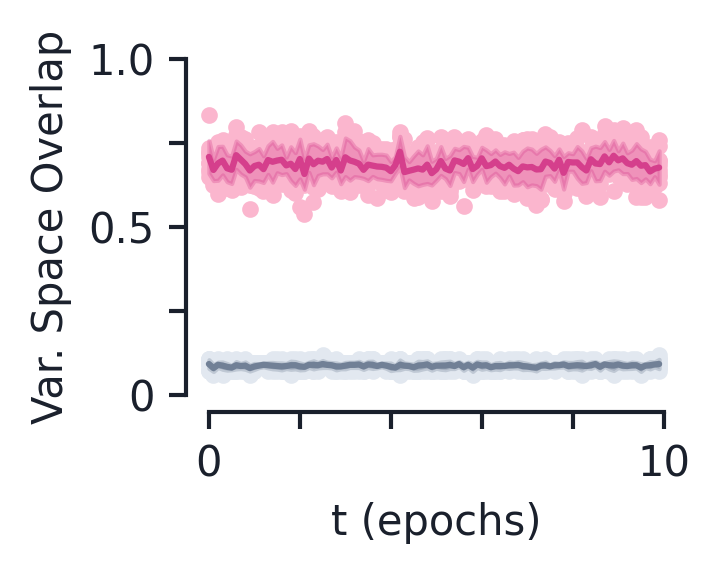

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(2.5,2))

for time_idx in range(n_thresh):

    init_time_idx = idx_thresh[0]+time_idx

    ax.scatter(time_idx*np.ones((n_trials,)), var_space_percs[:, init_time_idx],
               color=c_vals_l[7], marker='.')
    ax.scatter(time_idx*np.ones((n_trials,)), var_space_percs_chance[:, init_time_idx],
               color=c_vals_l[6], marker='.')

avg_var_space_perc = np.mean(var_space_percs[:, idx_thresh[0]:idx_thresh[1]], axis=0)
std_var_space_perc = np.std(var_space_percs[:, idx_thresh[0]:idx_thresh[1]], axis=0)
avg_var_space_perc_chance = np.mean(var_space_percs_chance[:, idx_thresh[0]:idx_thresh[1]], axis=0)
std_var_space_perc_chance = np.std(var_space_percs_chance[:, idx_thresh[0]:idx_thresh[1]], axis=0)

ax.plot(np.arange(n_thresh), avg_var_space_perc,
        color=c_vals[7])
ax.fill_between(np.arange(n_thresh), 
                avg_var_space_perc-std_var_space_perc, avg_var_space_perc+std_var_space_perc,
                alpha=0.3, color=c_vals[7])
ax.plot(np.arange(n_thresh), avg_var_space_perc_chance,
        color=c_vals[6])
ax.fill_between(np.arange(n_thresh), 
                avg_var_space_perc_chance-std_var_space_perc_chance, avg_var_space_perc_chance+std_var_space_perc_chance,
                alpha=0.3, color=c_vals[6])           

ax.set_xlabel('t (epochs)')
ax.set_xlim([0, n_thresh-1])
ax.set_xticks([0, 20, 40, 60, 80, 100])
ax.set_xticklabels([0, None, None, None, None, 10])
ax.set_ylabel('Var. Space Overlap')
ax.set_ylim([0.0, 1.0])
ax.set_yticks([0, 0.25, 0.5, 0.75, 1.0])
ax.set_yticklabels([0, None, 0.5, None, 1.0])

jetplot.breathe(ax=ax)

Compares several different delta t values.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':


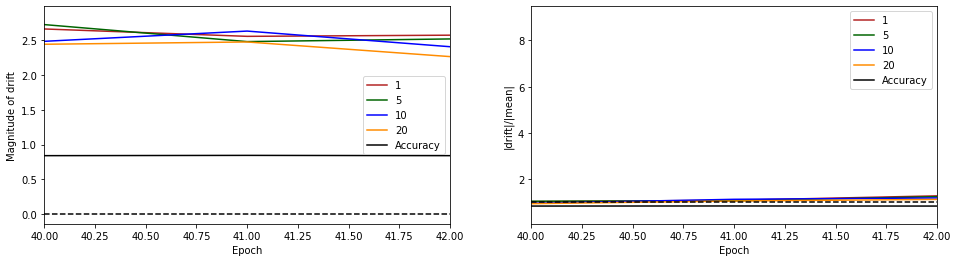

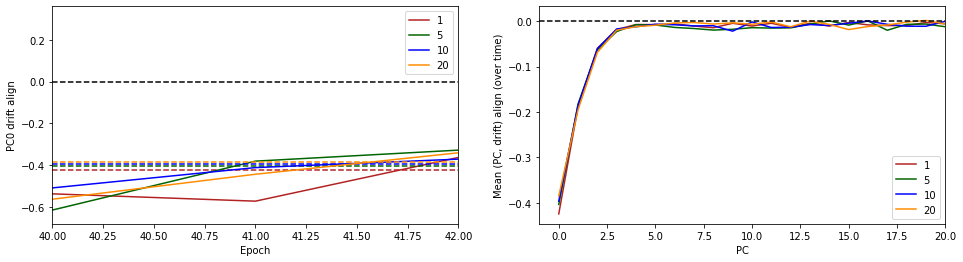

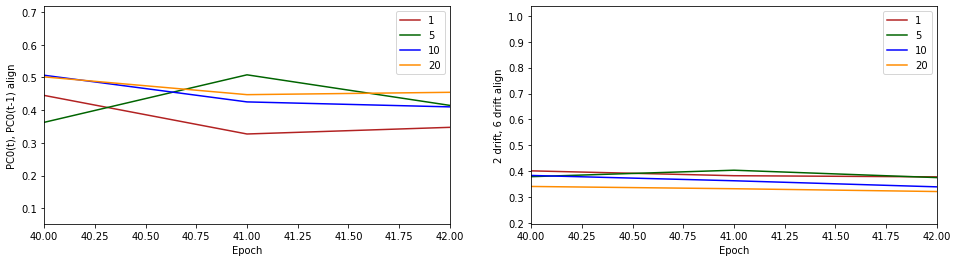

In [ ]:
from sklearn.decomposition import PCA

def participation_ratio_vector(C):
    """Computes the participation ratio of a vector of variances."""
    return np.sum(C) ** 2 / np.sum(C*C)

def get_align(x, y):
     return np.dot(x,y)/(
         np.linalg.norm(x) * np.linalg.norm(y)
     )

subset_labels = (class_labels[data_params['subset_idxs'][0]],
                 class_labels[data_params['subset_idxs'][1]])

class_means = np.zeros((n_trials, n_times, n_classes, n_feats))
class_pca_fits = [[[] for _ in range(n_times)] for _ in range(n_trials)] 

epochs = np.linspace(0, train_params['n_epochs'], 
                     train_params['test_freq']*train_params['n_epochs']+1)

for trial_idx in range(n_trials):
    feature_vals = feat_outs_experiments[trial_idx]
    for time_idx in range(len(feat_outs)):
        for class_idx in range(n_classes):
            class_means[trial_idx, time_idx, class_idx] = np.mean(feature_vals[time_idx][class_idx], axis=0)
            
            n_feat_space = np.min(feature_vals[time_idx][class_idx].shape)
            pca_time_class = PCA(n_components=n_feat_space)

            pca_feats = pca_time_class.fit_transform(feature_vals[time_idx][class_idx])

            # Removes ambiguity in PCA direction by making sure all means (along PC directions) are positive
            pca_dir_signs = np.sign(np.mean(np.matmul(feature_vals[time_idx][class_idx], pca_time_class.components_.T), axis=0))
            for pca_idx, pca_dir in enumerate(pca_time_class.components_):
                pca_time_class.components_[pca_idx, :] = pca_dir_signs[pca_idx] * pca_dir
            class_pca_fits[trial_idx][time_idx].append(pca_time_class)


# Number of time steps to take drift differences
n_time_drifts = [1, 5, 10, 20,]# 100, 150, 200]
class_idx = 0

avg_mean_diff_mags = []
avg_mean_diff_mags_normalized = []

avg_pca_drift_aligns = []
avg_class_drift_aligns = []
avg_pca_pca_aligns = []

for n_time_drift in n_time_drifts:

    mean_diff_mags = np.zeros((n_trials, n_classes, n_times-n_time_drift,))
    mean_diff_mags_normalized = np.zeros((n_trials, n_classes, n_times-n_time_drift,))

    pca_drift_aligns = np.zeros((n_trials, n_classes, n_times-n_time_drift, n_feats))
    class_drift_aligns = np.zeros((n_trials, n_times-n_time_drift,)) # Alignment betwen classes
    drift_drift_aligns = np.zeros((n_trials, n_classes, n_times-n_time_drift, n_times-n_time_drift)) # Alignment betwen classes
    pca_pca_aligns = np.zeros((n_trials, n_classes, n_times-n_time_drift,)) # Alignment between top PCs of current and previous time

    for trial_idx in range(n_trials):
        drifts = np.zeros((n_classes, n_times-n_time_drift, n_feats))
        for time_idx in range(len(feat_outs) - n_time_drift):
            for class_idx in range(n_classes):
                drift = (
                    class_means[trial_idx, time_idx+n_time_drift, class_idx] - 
                    class_means[trial_idx, time_idx, class_idx]
                )
                drifts[class_idx, time_idx] = drift

                mean_diff_mags[trial_idx, class_idx, time_idx] = np.linalg.norm(drift)
                mean_diff_mags_normalized[trial_idx, class_idx, time_idx] = (
                    mean_diff_mags[trial_idx, class_idx, time_idx]/np.linalg.norm(
                        class_means[trial_idx, time_idx, class_idx]
                    )
                )
                
                for pca_idx in range(n_feats):
                    pca_drift_aligns[trial_idx, class_idx, time_idx, pca_idx] = get_align(
                        class_pca_fits[trial_idx][time_idx][class_idx].components_[pca_idx],
                        drift
                    )
                pca_pca_aligns[trial_idx, class_idx, time_idx] = get_align(
                    class_pca_fits[trial_idx][time_idx+n_time_drift][class_idx].components_[0],
                    class_pca_fits[trial_idx][time_idx][class_idx].components_[0]
                )
            if n_classes > 2:
                raise ValueError('This code does not work for more than two classes.')
            class_drift_aligns[trial_idx, time_idx] = get_align(
                drifts[0, time_idx],
                drifts[1, time_idx]
            )

    avg_mean_diff_mags.append(np.mean(mean_diff_mags, axis=0))
    avg_mean_diff_mags_normalized.append(np.mean(mean_diff_mags_normalized, axis=0))

    avg_pca_drift_aligns.append(np.mean(pca_drift_aligns, axis=0))
    avg_class_drift_aligns.append(np.mean(class_drift_aligns, axis=0))
    avg_pca_pca_aligns.append(np.mean(pca_pca_aligns, axis=0))

# Epoch threshold for averaging across time (avoids initial training)
e_thresh = 10

fig, ax = plt.subplots(1, 2, figsize=(16,4))
fig2, ax2 = plt.subplots(1, 2, figsize=(16,4))
fig3, ax3 = plt.subplots(1, 2, figsize=(16,4))

for drift_idx, n_time_drift in enumerate(n_time_drifts):
    ax[0].plot(epochs[:-n_time_drift], avg_mean_diff_mags[drift_idx][class_idx], color=c_vals[drift_idx], 
            label=n_time_drift)
    ax[1].plot(epochs[:-n_time_drift], avg_mean_diff_mags_normalized[drift_idx][class_idx], 
               color=c_vals[drift_idx], label=n_time_drift)

    ax2[0].plot(epochs[:-n_time_drift], avg_pca_drift_aligns[drift_idx][class_idx, :, 0], 
                color=c_vals[drift_idx], label=n_time_drift)
    ax2[0].axhline(np.mean(avg_pca_drift_aligns[drift_idx][class_idx, e_thresh:, 0]), 
                   color=c_vals[drift_idx], linestyle='dashed')
    
    ax2[1].plot(np.mean(avg_pca_drift_aligns[drift_idx][class_idx, e_thresh:], axis=0), 
                color=c_vals[drift_idx], label=n_time_drift)
    
    ax3[0].plot(epochs[:-n_time_drift], avg_pca_pca_aligns[drift_idx][class_idx], 
                color=c_vals[drift_idx], label=n_time_drift)
    ax3[1].plot(epochs[:-n_time_drift], avg_class_drift_aligns[drift_idx], 
                color=c_vals[drift_idx], label=n_time_drift)


# This starts from epoch 0
ax[0].plot(epochs, accuracies, color='k', label='Accuracy')
ax[1].plot(epochs, accuracies, color='k', label='Accuracy')

for i in range(2):
    ax[i].set_xlabel('Epoch')
    ax[i].legend()
    ax2[i].legend()
    ax3[i].legend()
ax[0].set_ylabel('Magnitude of drift')
ax[0].axhline(0.0, color='k', linestyle='dashed')
ax[1].set_ylabel('|drift|/|mean|')
ax[1].axhline(1.0, color='k', linestyle='dashed')

ax2[0].set_xlabel('Epoch')
ax2[0].set_ylabel('PC0 drift align')
ax2[0].axhline(0.0, color='k', linestyle='dashed')

ax2[1].set_xlabel('PC')
ax2[1].set_ylabel('Mean (PC, drift) align (over time)')
ax2[1].axhline(0.0, color='k', linestyle='dashed')
ax2[1].set_xlim([-1,20])

ax3[0].set_xlabel('Epoch')
ax3[0].set_ylabel('PC0(t), PC0(t-1) align')

ax3[1].set_xlabel('Epoch')
ax3[1].set_ylabel('{} drift, {} drift align'.format(
    data_params['subset_idxs'][0], data_params['subset_idxs'][1]
))

ax[0].set_xlim([40, 42])
ax[1].set_xlim([40, 42])
ax2[0].set_xlim([40, 42])
ax3[0].set_xlim([40, 42])
ax3[1].set_xlim([40, 42])

if train_params['switch_datasets']:
    for ax_i in (ax[0], ax[1], ax2[0]):
        ax_i.axvline(train_params['switch_epoch'] - 0.5, color='grey', linestyle='dashed')

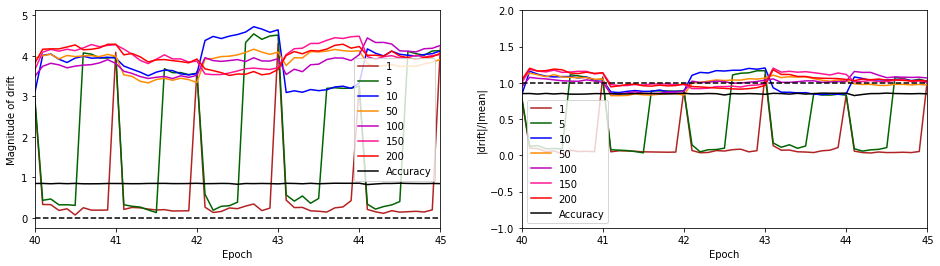

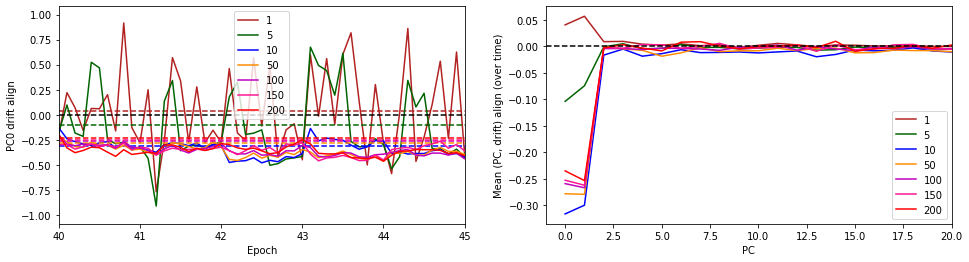

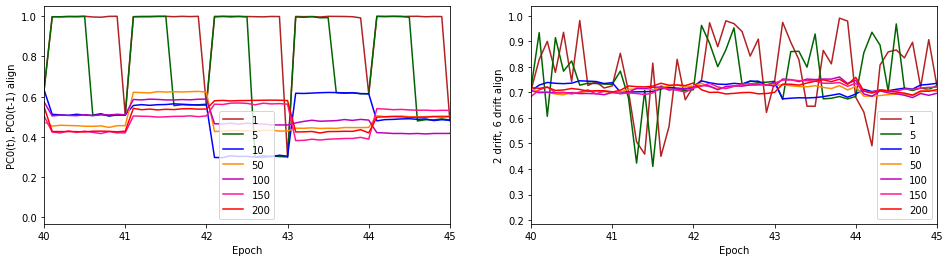

In [ ]:

# Epoch threshold for averaging across time (avoids initial training)
e_thresh = 10

fig, ax = plt.subplots(1, 2, figsize=(16,4))
fig2, ax2 = plt.subplots(1, 2, figsize=(16,4))
fig3, ax3 = plt.subplots(1, 2, figsize=(16,4))

for drift_idx, n_time_drift in enumerate(n_time_drifts):
    ax[0].plot(epochs[:-n_time_drift], avg_mean_diff_mags[drift_idx][class_idx], color=c_vals[drift_idx], 
            label=n_time_drift)
    ax[1].plot(epochs[:-n_time_drift], avg_mean_diff_mags_normalized[drift_idx][class_idx], 
               color=c_vals[drift_idx], label=n_time_drift)

    ax2[0].plot(epochs[:-n_time_drift], avg_pca_drift_aligns[drift_idx][class_idx, :, 0], 
                color=c_vals[drift_idx], label=n_time_drift)
    ax2[0].axhline(np.mean(avg_pca_drift_aligns[drift_idx][class_idx, e_thresh:, 0]), 
                   color=c_vals[drift_idx], linestyle='dashed')
    
    ax2[1].plot(np.mean(avg_pca_drift_aligns[drift_idx][class_idx, e_thresh:], axis=0), 
                color=c_vals[drift_idx], label=n_time_drift)
    
    ax3[0].plot(epochs[:-n_time_drift], avg_pca_pca_aligns[drift_idx][class_idx], 
                color=c_vals[drift_idx], label=n_time_drift)
    ax3[1].plot(epochs[:-n_time_drift], avg_class_drift_aligns[drift_idx], 
                color=c_vals[drift_idx], label=n_time_drift)


# This starts from epoch 0
ax[0].plot(epochs, accuracies, color='k', label='Accuracy')
ax[1].plot(epochs, accuracies, color='k', label='Accuracy')

for i in range(2):
    ax[i].set_xlabel('Epoch')
    ax[i].legend()
    ax2[i].legend()
    ax3[i].legend()
ax[0].set_ylabel('Magnitude of drift')
ax[0].axhline(0.0, color='k', linestyle='dashed')
ax[1].set_ylabel('|drift|/|mean|')
ax[1].axhline(1.0, color='k', linestyle='dashed')

ax2[0].set_xlabel('Epoch')
ax2[0].set_ylabel('PC0 drift align')
ax2[0].axhline(0.0, color='k', linestyle='dashed')

ax2[1].set_xlabel('PC')
ax2[1].set_ylabel('Mean (PC, drift) align (over time)')
ax2[1].axhline(0.0, color='k', linestyle='dashed')
ax2[1].set_xlim([-1,20])

ax3[0].set_xlabel('Epoch')
ax3[0].set_ylabel('PC0(t), PC0(t-1) align')

ax3[1].set_xlabel('Epoch')
ax3[1].set_ylabel('{} drift, {} drift align'.format(
    data_params['subset_idxs'][0], data_params['subset_idxs'][1]
))

ax[1].set_ylim([-1, 2])
ax[0].set_xlim([40, 45])
ax[1].set_xlim([40, 45])
ax2[0].set_xlim([40, 45])
ax3[0].set_xlim([40, 45])
ax3[1].set_xlim([40, 45])

if train_params['switch_datasets']:
    for ax_i in (ax[0], ax[1], ax2[0]):
        ax_i.axvline(train_params['switch_epoch'] - 0.5, color='grey', linestyle='dashed')

#### Scan over parameters and evaluate

In [ ]:
# Loads in comparison data from passive and behavioral datasets
def load_model_comparison(path):

    if not os.path.exists(path):
        raise ValueError('No file at path:', path)
    else:
        with open(path, 'rb') as load_file:
            angle_a = pickle.load(load_file)
            angle_r = pickle.load(load_file)
            var_flow_a = pickle.load(load_file)
            var_flow_r = pickle.load(load_file)
            mag_b = pickle.load(load_file)
            mag_a = pickle.load(load_file)
            var_perc_b = pickle.load(load_file)
            var_perc_a = pickle.load(load_file)
            svc_acc = pickle.load(load_file)
            svc_angle = pickle.load(load_file)

        return (
            angle_a, angle_r,
            var_flow_a, var_flow_r,
            mag_b, mag_a,
            var_perc_b, var_perc_a,
            svc_acc, svc_angle,
        )

def print_data_metrics(data_type, data_comparison):

    # Unpack comparison
    angle_a, angle_r, var_flow_a, var_flow_r, mag_b, mag_a, var_perc_b, var_perc_a, svc_acc, svc_angle = data_comparison

    print('{}- Angle: a {:.1f} (std: {:.2f}) r {:.2f} (std: {:.2f}), Var flow: a {:.2f} (std: {:.2f}) r {:.2f} (std: {:.2f})'.format(
        data_type,
        angle_a[0], angle_a[1],
        angle_r[0], angle_r[1],
        var_flow_a[0], var_flow_a[1],
        var_flow_r[0], var_flow_r[1],
    ))
    print('  Drift mag: b {:.2f} (std: {:.2f}) a {:.2f} (std: {:.2f}), Drift perc: b {:.2f} (std: {:.2f}) a {:.2f} (std: {:.2f})'.format(
        mag_b[0], mag_b[1],
        mag_a[0], mag_a[1],
        var_perc_b[0], var_perc_b[1], 
        var_perc_a[0], var_perc_a[1], 
    ))
    print('  SVC: rel acc {:.2f} (std: {:.2f}) angle {:.1f} (std: {:.1f})'.format(
        svc_acc[0], svc_acc[1],
        svc_angle[0], svc_angle[1],
    ))

# path_passive = '/content/drive/MyDrive/neuro_research/visual_change_drift/summary_data/passive_match_data.pickle'
# path_familiar = '/content/drive/MyDrive/neuro_research/visual_change_drift/summary_data/hit_match_data_familiar.pickle' 
# path_novel = '/content/drive/MyDrive/neuro_research/visual_change_drift/summary_data/hit_match_data_novel.pickle'
path_passive = '/content/drive/MyDrive/neuro_research/visual_change_drift/summary_data/passive_finalmatch_data.pickle'
path_familiar = '/content/drive/MyDrive/neuro_research/visual_change_drift/summary_data/hit_finalmatch_data_familiar.pickle' 
path_novel = '/content/drive/MyDrive/neuro_research/visual_change_drift/summary_data/hit_finalmatch_data_novel.pickle'

passive_comparison = load_model_comparison(path_passive)
familiar_comparison = load_model_comparison(path_familiar)
novel_comparison = load_model_comparison(path_novel)

print_data_metrics('Passive', passive_comparison)
print_data_metrics('Familiar', familiar_comparison)
print_data_metrics('Novel', novel_comparison)

def compare_to_data(data_comparison, trial_idx, compare_deltat=True, verbose=False):
    """ Compares fits of ANN data to experiment """
    
    # Unpack comparison
    angle_a, angle_r, var_flow_a, var_flow_r, mag_b, mag_a, var_perc_b, var_perc_a, svc_acc, svc_angle = data_comparison

    # Angle comparison
    z_angle_a = np.abs((avg_reg2_slope[trial_idx] - angle_a[0]) / angle_a[1])
    z_angle_r = np.abs(np.min(((avg_reg2_r[trial_idx] - angle_r[0]) / angle_r[1], 0.0,)))

    # Var flow comparison
    z_var_flow_a = np.abs((avg_reg3_slope[trial_idx] - var_flow_a[0]) / var_flow_a[1])
    z_var_flow_r = np.abs(np.min(((avg_reg3_r[trial_idx] - var_flow_r[0]) / var_flow_r[1], 0.0,)))

    # Magnitude and Var perc comparison
    z_mag_b = np.abs((avg_reg4_intercept[trial_idx] - mag_b[0]) / mag_b[1])
    z_var_perc_b = np.abs((avg_reg6_intercept[trial_idx] - var_perc_b[0]) / var_perc_b[1])
    if compare_deltat:
        z_mag_a = np.abs((avg_reg4_slope[trial_idx] - mag_a[0]) / mag_a[1])
        z_var_perc_a = np.abs((avg_reg6_slope[trial_idx] - var_perc_a[0]) / var_perc_a[1])
    else:
        z_mag_a, z_var_perc_a = 0, 0

    # SVC comparison
    z_svc_acc = np.abs((avg_cross_accs_rel[trial_idx]- svc_acc[0]) / svc_acc[1])
    z_svc_angle = np.abs((avg_cross_angles[trial_idx] - svc_angle[0]) / svc_angle[1])

    if verbose:
        print('Angle: a {:.2f} r {:.2f}'.format(z_angle_a, z_angle_r))
        print('Var flow: a {:.2f} r {:.2f}'.format(z_var_flow_a, z_var_flow_r))
        print('Var perc: b {:.2f} a {:.2f}'.format(z_var_perc_b, z_var_perc_a))
        print('SVC: acc {:.2f} angle {:.2f}'.format(z_svc_acc, z_svc_angle))

    z_vals = [
        np.max((z_angle_a, z_angle_r)),
        z_angle_r,
        np.max((z_var_flow_a, z_var_flow_r)),
        z_var_flow_r,
        # z_mag_b,
        # z_mag_a,
        z_var_perc_b,
        z_var_perc_a,
        z_svc_acc,
        z_svc_angle,
    ]

    return np.sum(z_vals), np.max(z_vals)

Passive- Angle: a 33.1 (std: 12.44) r 0.80 (std: 0.16), Var flow: a 0.30 (std: 0.12) r 0.85 (std: 0.13)
  Drift mag: b 1.29 (std: 0.76) a -0.00 (std: 0.19), Drift perc: b 0.53 (std: 0.13) a 0.00 (std: 0.05)
  SVC: rel acc 0.97 (std: 0.19) angle 56.6 (std: 13.7)
Familiar- Angle: a 43.9 (std: 58.29) r 0.30 (std: 0.38), Var flow: a 0.40 (std: 0.16) r 0.75 (std: 0.17)
  Drift mag: b 0.61 (std: 0.20) a nan (std: nan), Drift perc: b 0.56 (std: 0.21) a nan (std: nan)
  SVC: rel acc 0.97 (std: 0.11) angle 75.2 (std: 12.2)
Novel- Angle: a 68.7 (std: 50.10) r 0.41 (std: 0.30), Var flow: a 0.46 (std: 0.15) r 0.79 (std: 0.16)
  Drift mag: b 0.68 (std: 0.24) a nan (std: nan), Drift perc: b 0.59 (std: 0.20) a nan (std: nan)
  SVC: rel acc 0.94 (std: 0.11) angle 76.5 (std: 8.2)


In [ ]:
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

from scipy.stats import linregress
from sklearn.decomposition import PCA

def participation_ratio_vector(C):
    """Computes the participation ratio of a vector of variances."""
    return np.sum(C) ** 2 / np.sum(C*C)

def get_align(x, y):
     return np.dot(x,y)/(
         np.linalg.norm(x) * np.linalg.norm(y)
     )

def subspace_perc(A, b):
    """
    A: an N x M matrix, whose column space represents some M-dimensional subspace
    b: an N x P vector
    For each of b's columns, finds the percentage of its magnitude which lies in 
    the subspace formed by the columns of A (its columnspace). Then averages these together
    """
    if len(b.shape) == 1:
        b = b[:, np.newaxis]

    proj = np.matmul(np.matmul(A, np.linalg.inv(np.matmul(A.T, A))), A.T) # N x N matrix
    b_proj = np.matmul(proj, b) # N x P martix

    norm_perc = np.linalg.norm(b_proj, axis=0)/np.linalg.norm(b, axis=0) # P dim vector

    return np.sum(norm_perc**2)/np.min((A.shape[1], b.shape[1]))

def get_align_angle(x, y):
    dot = np.dot(x,y)/(
         np.linalg.norm(x) * np.linalg.norm(y)
     )
    if dot > 1.0:
         dot = 1.0
    elif dot < -1.0:
        dot = -1.0
    
    return 180/np.pi * np.arccos(dot)

class_means = np.zeros((n_trials, n_times, n_classes, n_feats))
class_pca_fits = [[[] for _ in range(n_times)] for _ in range(n_trials)] 
class_prs = np.zeros((n_trials, n_times, n_classes))

epochs = np.linspace(train_params['save_thresh'], train_params['n_epochs'], 
                     train_params['test_freq']*(train_params['n_epochs'] - train_params['save_thresh']))
epochs = np.insert(epochs, 0, 0.0) # Always has initial data, so add 0

for trial_idx in range(n_trials):
    feature_vals = feat_outs_experiments[trial_idx]
    for time_idx in range(len(feat_outs)):
        for class_idx in range(n_classes):
            class_means[trial_idx, time_idx, class_idx] = np.mean(feature_vals[time_idx][class_idx], axis=0)
            
            n_feat_space = np.min(feature_vals[time_idx][class_idx].shape)
            pca_time_class = PCA(n_components=n_feat_space)

            pca_feats = pca_time_class.fit_transform(feature_vals[time_idx][class_idx])

            # Removes ambiguity in PCA direction by making sure all means (along PC directions) are positive
            pca_dir_signs = np.sign(np.mean(np.matmul(feature_vals[time_idx][class_idx], pca_time_class.components_.T), axis=0))
            for pca_idx, pca_dir in enumerate(pca_time_class.components_):
                pca_time_class.components_[pca_idx, :] = pca_dir_signs[pca_idx] * pca_dir
            class_pca_fits[trial_idx][time_idx].append(pca_time_class)

            class_prs[trial_idx, time_idx, class_idx] = participation_ratio_vector(
                pca_time_class.explained_variance_ratio_
            )

# Epoch threshold for averaging across time
e_thresh_len = 10
n_thresh = e_thresh_len * train_params['test_freq']
n_time_drift = 1 # delta t (number of idxs)

# mean_diff_mags = np.zeros((n_trials, n_classes, n_times-n_time_drift,))
# mean_diff_mags_normalized = np.zeros((n_trials, n_classes, n_times-n_time_drift,))

# Time set to n-thresh - n_time_drift so all differences taken within threshold
pca_var_exp_i = np.zeros((n_trials, n_classes, n_thresh-n_time_drift, n_feats))
pca_drift_angles = np.zeros((n_trials, n_classes, n_thresh-n_time_drift, n_feats))
pca_drift_mag = np.zeros((n_trials, n_classes, n_thresh-n_time_drift, n_feats))
pca_i_var_exp_f = np.zeros((n_trials, n_classes, n_thresh-n_time_drift, n_feats))

avg_accs = np.zeros((n_trials,))

for trial_idx in range(n_trials):
    # Can change testing location for each epoch
    e_thresh = (eval_epoch[trial_idx], eval_epoch[trial_idx] +  e_thresh_len)
    idx_thresh = [train_params['test_freq']*(epoch - train_params['save_thresh'])+1 for epoch in e_thresh]
    print('Using epoch threshold:', e_thresh, 'idxs:', idx_thresh)

    avg_accs[trial_idx] = np.mean(accuracies_experiments[trial_idx][idx_thresh[0]:idx_thresh[1]])
    drifts = np.zeros((n_classes, n_times-n_time_drift, n_feats))
    for time_idx in range(n_thresh-n_time_drift):
        init_t_idx = idx_thresh[0]+time_idx
        final_t_idx = idx_thresh[0]+time_idx+n_time_drift
        
        for class_idx in range(n_classes):
            drift = (
                class_means[trial_idx, final_t_idx, class_idx] - 
                class_means[trial_idx, init_t_idx, class_idx]
            )
            drifts[class_idx, time_idx] = drift

            pca_var_exp_i[trial_idx, class_idx, time_idx] = (
                class_pca_fits[trial_idx][init_t_idx][class_idx].explained_variance_ratio_
            )

            pca_drift = np.matmul(
                class_pca_fits[trial_idx][init_t_idx][class_idx].components_,
                drift
            )

            for pca_idx in range(n_feats):
                pca_drift_angles[trial_idx, class_idx, time_idx, pca_idx] = get_align_angle(
                    class_pca_fits[trial_idx][init_t_idx][class_idx].components_[pca_idx],
                    drift
                )
                pca_drift_mag[trial_idx, class_idx, time_idx, pca_idx] = np.abs(
                    pca_drift[pca_idx])

            data_i = feat_outs_experiments[trial_idx][init_t_idx][class_idx]
            data_f = feat_outs_experiments[trial_idx][final_t_idx][class_idx]

            # Flow of variation
            pca_i_data_i = np.matmul(data_i, class_pca_fits[trial_idx][init_t_idx][class_idx].components_.T)
            pca_i_data_f = np.matmul(data_f, class_pca_fits[trial_idx][init_t_idx][class_idx].components_.T)
            
            pca_i_data_i_cov = np.cov(pca_i_data_i.T)
            pca_i_data_i_vars = np.diag(pca_i_data_i_cov)
            pca_i_data_i_vars_ratio = pca_i_data_i_vars/np.sum(pca_i_data_i_vars)
            pca_i_data_f_cov = np.cov(pca_i_data_f.T)
            pca_i_data_f_vars = np.diag(pca_i_data_f_cov)
            pca_i_var_exp_f[trial_idx, class_idx, time_idx] = pca_i_data_f_vars/np.sum(pca_i_data_f_vars)

subset_labels = [class_labels[data_params['subset_idxs'][idx]] for idx in range(n_classes)]

# Number of time steps to take drift differences
n_time_drifts = np.arange(1, 8)

# fig, ax = plt.subplots(1, 3, figsize=(16,4))

n_se = 1.97
class_idx_fit = 1

# Thresholds
min_var_exp = 1e-5

pca_var_exp_i = pca_var_exp_i.reshape((n_trials, n_classes, n_thresh-n_time_drift * n_feats))
pca_drift_angles = pca_drift_angles.reshape((n_trials, n_classes, n_thresh-n_time_drift * n_feats))
pca_drift_mag = pca_drift_mag.reshape((n_trials, n_classes, n_thresh-n_time_drift * n_feats))
pca_i_var_exp_f = pca_i_var_exp_f.reshape((n_trials, n_classes, n_thresh-n_time_drift * n_feats))

z_passive = []
z_familiar = []
z_novel = [] 

avg_reg2_slope = []
avg_reg2_r = []
avg_reg3_slope = []
avg_reg3_r = []
avg_reg4_slope = []
avg_reg4_intercept = []
avg_reg6_slope = []
avg_reg6_intercept = []

for trial_idx in range(n_trials):
    reg2_slope = []
    reg2_r = []
    reg3_slope = []
    reg3_r = []

    for class_idx in range(n_classes): # Fits for all classes and then averages values together
        var_exp_filter = pca_var_exp_i[trial_idx, class_idx] > min_var_exp 
        pca_drift_angles_fit = pca_drift_angles[trial_idx, class_idx, var_exp_filter]
        pca_drift_mag_fit = pca_drift_mag[trial_idx, class_idx, var_exp_filter]
        pca_i_var_exp_f_fit = pca_i_var_exp_f[trial_idx, class_idx, var_exp_filter]
        pca_var_exp_i_fit = pca_var_exp_i[trial_idx, class_idx, var_exp_filter]

        reg1 = linregress(pca_var_exp_i_fit, pca_drift_mag_fit)

        reg2 = linregress(pca_var_exp_i_fit, pca_drift_angles_fit)
        reg2_slope.append(reg2.slope)
        reg2_r.append(reg2.rvalue)

        reg3 = linregress(np.log(pca_var_exp_i_fit), np.log(pca_i_var_exp_f_fit))
        reg3_slope.append(reg3.slope)
        reg3_r.append(reg3.rvalue)
    
    reg4_slope = []
    reg4_intercept = []
    reg6_slope = []
    reg6_intercept = []
    
    for class_idx in range(n_classes):

        # Delta t fits
        delta_ts = []
        drift_mags_norm = []
        delta_prs = []
        drift_percs = []
    
        for n_time_drift in n_time_drifts:
            
            mean_diff_mags = np.zeros((n_thresh-n_time_drift,))
            mean_diff_mags_normalized = np.zeros((n_thresh-n_time_drift,))

            delta_pr_drift = np.zeros((n_thresh-n_time_drift,))
            drift_percs_drift = np.zeros((n_thresh-n_time_drift,))

            drifts = np.zeros((n_thresh-n_time_drift, n_feats))
            for time_idx in range(n_thresh-n_time_drift):
                init_t_idx = idx_thresh[0]+time_idx
                final_t_idx = idx_thresh[0]+time_idx+n_time_drift
                
                drift = (
                    class_means[trial_idx, final_t_idx, class_idx] - 
                    class_means[trial_idx, init_t_idx, class_idx]
                )
                drifts[time_idx] = drift

                mean_diff_mags[time_idx] = np.linalg.norm(drift)
                mean_diff_mags_normalized[time_idx] = (
                    np.linalg.norm(drift)/np.linalg.norm(
                        class_means[trial_idx, init_t_idx, class_idx]
                    )
                )
                
                delta_pr_drift[time_idx] = (
                    class_prs[trial_idx, final_t_idx, class_idx] - 
                    class_prs[trial_idx, init_t_idx, class_idx]
                )
                
                init_var_dim = int(np.ceil(class_prs[trial_idx, init_t_idx, class_idx]))

                drift_percs_drift[time_idx] = subspace_perc(
                    class_pca_fits[trial_idx][init_t_idx][class_idx].components_[:init_var_dim].T,
                    drift
                )

            delta_ts.append(n_time_drift * np.ones(mean_diff_mags.flatten().shape))
            drift_mags_norm.append(mean_diff_mags_normalized.flatten())
            delta_prs.append(delta_pr_drift.flatten())
            drift_percs.append(drift_percs_drift.flatten())

        # Concatenates each of the metrics into one long vector
        delta_ts = np.concatenate(delta_ts, axis=0) 
        drift_mags_norm = np.concatenate(drift_mags_norm, axis=0) 
        delta_prs = np.concatenate(delta_prs, axis=0) 
        drift_percs = np.concatenate(drift_percs, axis=0) 
            
        reg4 = linregress(delta_ts, drift_mags_norm)
        reg5 = linregress(delta_ts, delta_prs)
        reg6 = linregress(delta_ts, drift_percs)

        reg4_slope.append(reg4.slope)
        reg4_intercept.append(reg4.intercept)
        reg6_slope.append(reg6.slope)
        reg6_intercept.append(reg6.intercept)

    print('Trial idx {} - Acc: {:.2f}, Angle a {:.1f} (r {:.2f}), Var flow a {:.2f} (r {:.2f}), Drift mag: {:.2f} (a {:.2f}), Drift perc: {:.2f} (a {:.2f})'.format(
        trial_idx, avg_accs[trial_idx],
        np.mean(reg2_slope), np.mean(reg2_r), 
        np.mean(reg3_slope), np.mean(reg3_r),
        np.mean(drift_mags_norm), np.mean(reg4_slope),
        np.mean(drift_percs), np.mean(reg6_slope),
    ))

    avg_reg2_slope.append(np.mean(reg2_slope))
    avg_reg2_r.append(np.mean(reg2_r))
    avg_reg3_slope.append(np.mean(reg3_slope))
    avg_reg3_r.append(np.mean(reg3_r))
    avg_reg4_slope.append(np.mean(reg4_slope))
    avg_reg4_intercept.append(np.mean(reg4_intercept))
    avg_reg6_slope.append(np.mean(reg6_slope))
    avg_reg6_intercept.append(np.mean(reg6_intercept))

###### Cross classification tests ######

e_thresh_len = 5
n_thresh = e_thresh_len * train_params['test_freq']

n_folds = 10
n_feats = feat_outs_experiments[0][0][0].shape[1]

svc_idxs = [2, 6]

cross_aligns_trial = np.zeros((n_trials, n_thresh, n_thresh))
cross_angles_trial = np.zeros((n_trials, n_thresh, n_thresh))

cross_accs_trial = np.zeros((n_trials, n_thresh, n_thresh))
cross_accs_rel_trial = np.zeros((n_trials, n_thresh, n_thresh))

avg_cross_accs_rel = np.zeros((n_trials,))
avg_cross_angles = np.zeros((n_trials,))

for trial_idx in range(n_trials):
    e_thresh = (eval_epoch[trial_idx], eval_epoch[trial_idx] +  e_thresh_len)
    idx_thresh = [train_params['test_freq']*(epoch - train_params['save_thresh'])+1 for epoch in e_thresh]
    # print('Using epoch threshold:', e_thresh, 'idxs:', idx_thresh)
    
    feature_vals = feat_outs_experiments[trial_idx]
    readout_ws = readout_w_experiments[trial_idx]

    X_data_times = []
    y_labels_times = []

    models_time = []

    for time_idx in range(idx_thresh[0], idx_thresh[1]):
        
        # Create the classification data 
        X_data = []
        y_labels = []

        if n_classes == 2:
            for class_idx in range(n_classes):
                X_data.append(feature_vals[time_idx][class_idx])
                y_labels.append(class_idx * np.ones(
                    feature_vals[time_idx][class_idx].shape[0], 
                    dtype=np.int32
                ))
        else:
            for class_idx_idx, class_idx in enumerate(svc_idxs):
                X_data.append(feature_vals[time_idx][class_idx])
                y_labels.append(class_idx_idx * np.ones(
                    feature_vals[time_idx][class_idx].shape[0], 
                    dtype=np.int32
                ))

        X_data = np.concatenate(X_data, axis=0)
        y_labels = np.concatenate(y_labels, axis=0)

        # Shuffle the classification data
        arr_idxs = np.arange(X_data.shape[0])
        np.random.seed(10)
        np.random.shuffle(arr_idxs)
        X_data = X_data[arr_idxs]
        y_labels = y_labels[arr_idxs]

        X_data_times.append(X_data)
        y_labels_times.append(y_labels)

        # k-Fold Cross validation, saving the model details at each step
        kf = KFold(n_splits=n_folds)

        models = []
        coefs = np.zeros((n_folds, n_feats))
        intercepts = np.zeros((n_folds,))
        raw_accs = np.zeros((n_folds, ))

        for fold_idx, (train_index, test_index) in enumerate(kf.split(X_data)):
            X_train, X_test = X_data[train_index], X_data[test_index]
            y_train, y_test = y_labels[train_index], y_labels[test_index]

            # SVC classifier
            # clf = svm.LinearSVC(class_weight=class_weights, fit_intercept=False)
            clf = svm.LinearSVC(class_weight='balanced', fit_intercept=True, max_iter=100000)
            # clf = svm.LinearSVC(fit_intercept=False)

            clf.fit(X_train, y_train)
            models.append(clf)
            coefs[fold_idx] = clf.coef_[0]
            intercepts[fold_idx] = clf.intercept_[0]

            y_pred = clf.predict(X_test)
            raw_accs[fold_idx] = np.sum(y_pred == y_test) / y_test.shape[0]

        models_time.append(models)

    cross_angles = np.zeros((n_thresh, n_thresh))
    cross_accs = np.zeros((n_thresh, n_thresh))

    for time_idx_c in range(n_thresh): # Classifier index
        
        ro_aligns_folds = aligns = np.zeros((n_folds,))
        
        models = models_time[time_idx_c]
        
        # Cross accuracy/alignment calculation
        for time_idx_d in range(n_thresh): # Data index
            X_data = X_data_times[time_idx_d]
            y_labels = y_labels_times[time_idx_d]

            models_d = models_time[time_idx_d]

            angles = np.zeros((n_folds,))
            cross_accs_folds = np.zeros((n_folds,))

            # k-Fold Cross validation, saving the model details at each step
            kf = KFold(n_splits=n_folds)

            for fold_idx, (train_index, test_index) in enumerate(kf.split(X_data)):
                _, X_test = X_data[train_index], X_data[test_index]
                _, y_test = y_labels[train_index], y_labels[test_index]

                # SVC classifier
                clf = models[fold_idx]
                y_cross_pred = clf.predict(X_test)
                cross_accs_folds[fold_idx] = np.sum(y_cross_pred == y_test) / y_test.shape[0]


                clf_d = models_d[fold_idx]
                angles[fold_idx] = get_align_angle(
                    clf.coef_[0], clf_d.coef_[0]
                ) 
            cross_accs[time_idx_c, time_idx_d] = np.mean(cross_accs_folds)
            cross_angles[time_idx_c, time_idx_d] = np.mean(angles)

    cross_angles_trial[trial_idx] = cross_angles
    cross_accs_trial[trial_idx] = cross_accs

    for time_idx_c in range(n_thresh): # Classifier index
        if cross_accs_trial[trial_idx, time_idx_c, time_idx_c] == 0.0:
            print('Accuracy is zero at idx {}!'.format(time_idx_c))
            continue
        cross_accs_rel_trial[trial_idx, time_idx_c, :] = (
            cross_accs_trial[trial_idx, time_idx_c, :] / 
            cross_accs_trial[trial_idx, time_idx_c, time_idx_c]
        )

    cross_accs = []
    cross_accs_rel = []
    angles = []
    for time_idx_c in range(n_thresh):
        for time_idx_d in range(n_thresh):
            if time_idx_c == time_idx_d:
                continue
            else:
                cross_accs.append(cross_accs_trial[trial_idx, time_idx_c, time_idx_d])
                cross_accs_rel.append(cross_accs_rel_trial[trial_idx, time_idx_c, time_idx_d])
                if time_idx_c > time_idx_d:
                    angles.append(cross_angles_trial[trial_idx, time_idx_c, time_idx_d])

    print('Trial idx {} - Rel Cross Acc: {:.2f}, Acc {:.1f}, Angle {:.1f}'.format(
        trial_idx, np.mean(cross_accs_rel), np.mean(cross_accs), 
        np.mean(angles)
    ))

    avg_cross_accs_rel[trial_idx] = np.mean(cross_accs_rel)
    avg_cross_angles[trial_idx] = np.mean(angles)

z_passive = np.zeros((n_trials,))
z_passive_max = np.zeros((n_trials,))
z_familiar = np.zeros((n_trials,))
z_familiar_max = np.zeros((n_trials,))
z_novel = np.zeros((n_trials,))
z_novel_max = np.zeros((n_trials,))

for trial_idx in range(n_trials):

    z_passive[trial_idx], z_passive_max[trial_idx] = compare_to_data(passive_comparison, trial_idx)
    z_familiar[trial_idx], z_familiar_max[trial_idx] = compare_to_data(familiar_comparison, trial_idx, compare_deltat=False)
    z_novel[trial_idx], z_novel_max[trial_idx] = compare_to_data(novel_comparison, trial_idx, compare_deltat=False)
    print('Ztot - Trial idx {} - Total: {:.1f} \tPassive: {:.1f} \tFamiliar: {:.1f} \tNovel: {:.1f}'.format(
        trial_idx, 
        z_passive[trial_idx] + z_familiar[trial_idx] + z_novel[trial_idx],
        z_passive[trial_idx], 
        z_familiar[trial_idx],
        z_novel[trial_idx],
    ))

for trial_idx in range(n_trials):
    print('Zmax - Trial idx {} - Total: {:.1f} \tPassive: {:.1f} \tFamiliar: {:.1f} \tNovel: {:.1f}'.format(
        trial_idx, 
        z_passive_max[trial_idx] + z_familiar_max[trial_idx] + z_novel_max[trial_idx],
        z_passive_max[trial_idx], 
        z_familiar_max[trial_idx],
        z_novel_max[trial_idx],
    ))

Using epoch threshold: (35, 45) idxs: [36, 46]
Trial idx 0 - Acc: 0.67, Angle a 5.7 (r 0.03), Var flow a 0.97 (r 1.00), Drift mag: 0.12 (a 0.00), Drift perc: 0.59 (a -0.01)
Trial idx 0 - Rel Cross Acc: 0.99, Acc 0.9, Angle 28.5
Ztot - Trial idx 0 - Total: 40.8 	Passive: 18.9 	Familiar: 9.4 	Novel: 12.6
Zmax - Trial idx 0 - Total: 15.3 	Passive: 5.6 	Familiar: 3.8 	Novel: 5.9


In [ ]:
path = '/content/drive/MyDrive/neuro_research/visual_change_drift/summary_data/ann_hyperscan_final_nonoise.pickle'
save_hyperparam_data(path)

File already exists at: /content/drive/MyDrive/neuro_research/visual_change_drift/summary_data/ann_hyperscan_final_nonoise.pickle
Override? (Y/N):Y
Data Saved


In [ ]:
def save_hyperparam_data(path):
    save_the_file = True

    if os.path.exists(path):
        print('File already exists at:', path)
        override = input('Override? (Y/N):')
        if override == 'Y':
            save_the_file = True
        else:
            save_the_file = False

    if save_the_file:
        with open(path, 'wb') as save_file:
            pickle.dump(avg_reg2_slope, save_file, protocol=pickle.HIGHEST_PROTOCOL)
            pickle.dump(avg_reg2_r, save_file, protocol=pickle.HIGHEST_PROTOCOL)
            pickle.dump(avg_reg3_slope, save_file, protocol=pickle.HIGHEST_PROTOCOL)
            pickle.dump(avg_reg3_r, save_file, protocol=pickle.HIGHEST_PROTOCOL)
            pickle.dump(avg_reg4_intercept, save_file, protocol=pickle.HIGHEST_PROTOCOL)
            pickle.dump(avg_reg4_slope, save_file, protocol=pickle.HIGHEST_PROTOCOL)
            pickle.dump(avg_reg6_intercept, save_file, protocol=pickle.HIGHEST_PROTOCOL)
            pickle.dump(avg_reg6_slope, save_file, protocol=pickle.HIGHEST_PROTOCOL)
            pickle.dump(avg_cross_accs_rel, save_file, protocol=pickle.HIGHEST_PROTOCOL)
            pickle.dump(avg_cross_angles, save_file, protocol=pickle.HIGHEST_PROTOCOL)
        print('Data Saved')
    else:
        print('Data Not Saved')

def load_hyperparam_data(path):
    
    if not os.path.exists(path):
        raise ValueError('No file at path:', path)
    else:
        outs = []
        with open(path, 'rb') as load_file:
            outs.append(pickle.load(load_file))
            outs.append(pickle.load(load_file))
            outs.append(pickle.load(load_file))
            outs.append(pickle.load(load_file))
            outs.append(pickle.load(load_file))
            outs.append(pickle.load(load_file))
            outs.append(pickle.load(load_file))
            outs.append(pickle.load(load_file))
            outs.append(pickle.load(load_file))
            outs.append(pickle.load(load_file))

        return outs

Type: feature Min idx: 4
Type: gradient Min idx: 7
Type: node Min idx: 4
Type: weight Min idx: 5
Type: mgn Min idx: 6


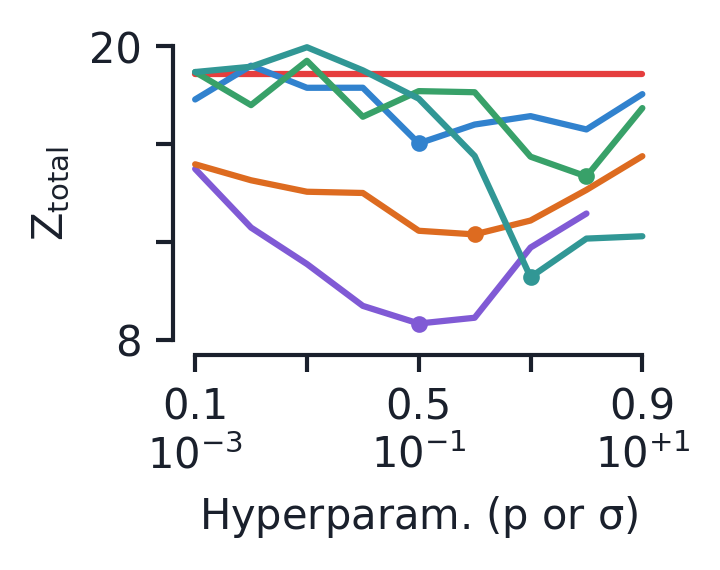

In [ ]:
root_path = '/content/drive/MyDrive/neuro_research/visual_change_drift/summary_data/ann_hyperscan_final_'

plot_types = ['nonoise', 'feature', 'gradient',  'node', 'weight', 'mgn',] 

fig, ax = plt.subplots(1, 1, figsize=(2.5,2))

for type_idx in range(len(plot_types)):

    path = root_path + plot_types[type_idx] + '.pickle'

    (
        avg_reg2_slope,
        avg_reg2_r,
        avg_reg3_slope,
        avg_reg3_r,
        avg_reg4_intercept,
        avg_reg4_slope,
        avg_reg6_intercept,
        avg_reg6_slope,
        avg_cross_accs_rel,
        avg_cross_angles,
    ) = load_hyperparam_data(path)

    n_trials = len(avg_reg2_slope)

    z_passive = np.zeros((n_trials,))
    z_passive_max = np.zeros((n_trials,))
    z_familiar = np.zeros((n_trials,))
    z_familiar_max = np.zeros((n_trials,))
    z_novel = np.zeros((n_trials,))
    z_novel_max = np.zeros((n_trials,))

    for trial_idx in range(n_trials):
        z_passive[trial_idx], z_passive_max[trial_idx] = compare_to_data(passive_comparison, trial_idx)
        z_familiar[trial_idx], z_familiar_max[trial_idx] = compare_to_data(familiar_comparison, trial_idx, compare_deltat=False)
        z_novel[trial_idx], z_novel_max[trial_idx] = compare_to_data(novel_comparison, trial_idx, compare_deltat=False)

        # if type_idx == 3:
        #     print('Ztot - Trial idx {} - Total: {:.1f} \tPassive: {:.1f} \tFamiliar: {:.1f} \tNovel: {:.1f}'.format(
        #         trial_idx, 
        #         z_passive[trial_idx] + z_familiar[trial_idx] + z_novel[trial_idx],
        #         z_passive[trial_idx], 
        #         z_familiar[trial_idx],
        #         z_novel[trial_idx],
        #     ))
            

    if n_trials < 9: # No noise case
        ax.plot(np.arange(9), z_passive*np.ones((9,)), color=c_vals[type_idx])
    else:
        ax.plot(np.arange(9), z_passive, color=c_vals[type_idx])
        ax.scatter(np.nanargmin(z_passive), np.nanmin(z_passive), color=c_vals[type_idx],
                   marker='.')
        print('Type:', plot_types[type_idx], 'Min idx:', np.nanargmin(z_passive))


ax.set_xlabel('Hyperparam. (p or $\sigma$)')
ax.set_ylabel('$Z_{total}$')
ax.set_xlim([0, 8])
ax.set_xticks([0, 2, 4, 6, 8])
ax.set_xticklabels(['0.1\n$10^{-3}$', None, '0.5\n$10^{-1}$', None, '0.9\n$10^{+1}$'])
ax.set_ylim([8, 20])
ax.set_yticks([8, 12, 16, 20])
ax.set_yticklabels([8, None, None, 20])

jetplot.breathe(ax=ax)

#### Drift from Dropout Redraws Check

Looks at the properties of drift from doing dropout redraws. Note since dropout is drawn 10 times in test set by default, this just reanalyzes already saved data by treating the 10 redraws as "time".

Feature outs is a nested list in order: [trial_idx][seq_idx][class_idx](n_test, feture_space_dim) where now seq_idx goes from 0 to 9 for the 10 redraws, and n_test is 10 times smaller.

In [69]:
from sklearn.decomposition import PCA

# Epoch value to get data from
epoch_num = 70
epoch_idx = train_params['test_freq']*(epoch_num - train_params['save_thresh'])+1
n_time_drift = 1 # delta t (number of idxs)

n_drops = 10
n_per_dropout = 100

for trial in range(n_trials):
    feature_vals_new = [[[] for _ in range(n_classes)] for _ in range(n_drops)]

    feat_outs = feat_outs_experiments[trial]
    targets = targets_experiments[trial]

    for drop_idx in range(n_drops):
        # print('Time {}:'.format(time_idx))
        for class_idx in range(n_classes):
            feature_vals_new[drop_idx][class_idx] = (
                feat_outs_experiments[trial][epoch_idx][class_idx]
                [drop_idx*n_per_dropout:(drop_idx+1)*n_per_dropout]
            )

    feat_outs_experiments[trial] = feature_vals_new

print('Trials:', len(feat_outs_experiments))
print('Drop idxs/Seq len:', len(feat_outs_experiments[0]))
print('Classes:', len(feat_outs_experiments[0][0]))
print('Feature shape:', feat_outs_experiments[0][0][0].shape)

Trials: 5
Drop idxs/Seq len: 10
Classes: 2
Feature shape: (100, 126)


### Save Run Data

In [ ]:
def save_plot_data(path):
    """ Saves everything needed to compute hyperparameter comparison """ 
    save_the_file = True

    if os.path.exists(path):
        print('File already exists at:', path)
        override = input('Override? (Y/N):')
        if override == 'Y':
            save_the_file = True
        else:
            save_the_file = False

    if save_the_file:
        with open(path, 'wb') as save_file:
            # Variance explained plots
            pickle.dump(drift_mag_fits_X, save_file, protocol=pickle.HIGHEST_PROTOCOL)
            pickle.dump(drift_mag_fits_y, save_file, protocol=pickle.HIGHEST_PROTOCOL)
            pickle.dump(drift_mag_rs, save_file, protocol=pickle.HIGHEST_PROTOCOL)
            pickle.dump(drift_angle_fits_X, save_file, protocol=pickle.HIGHEST_PROTOCOL)
            pickle.dump(drift_angle_fits_y, save_file, protocol=pickle.HIGHEST_PROTOCOL)
            pickle.dump(drift_angle_rs, save_file, protocol=pickle.HIGHEST_PROTOCOL)
            pickle.dump(change_varexp_fits_X, save_file, protocol=pickle.HIGHEST_PROTOCOL)
            pickle.dump(change_varexp_fits_y, save_file, protocol=pickle.HIGHEST_PROTOCOL)
            pickle.dump(change_varexp_rs, save_file, protocol=pickle.HIGHEST_PROTOCOL)
            # Delta t plots
            pickle.dump(drift_mags_norm_fits_X, save_file, protocol=pickle.HIGHEST_PROTOCOL)
            pickle.dump(drift_mags_norm_fits_y, save_file, protocol=pickle.HIGHEST_PROTOCOL)
            pickle.dump(drift_mags_norm_rs, save_file, protocol=pickle.HIGHEST_PROTOCOL)
            pickle.dump(delta_prs_fits_X, save_file, protocol=pickle.HIGHEST_PROTOCOL)
            pickle.dump(delta_prs_fits_y, save_file, protocol=pickle.HIGHEST_PROTOCOL)
            pickle.dump(delta_prs_rs, save_file, protocol=pickle.HIGHEST_PROTOCOL)
            pickle.dump(drift_percs_fits_X, save_file, protocol=pickle.HIGHEST_PROTOCOL)
            pickle.dump(drift_percs_fits_y, save_file, protocol=pickle.HIGHEST_PROTOCOL)
            pickle.dump(drift_percs_rs, save_file, protocol=pickle.HIGHEST_PROTOCOL)
            # Accuracies
            pickle.dump(np.array(accuracies_experiments), save_file, protocol=pickle.HIGHEST_PROTOCOL)
        print('Data Saved')
    else:
        print('Data Not Saved')

def load_plot_data(path):

    if not os.path.exists(path):
        raise ValueError('No file at path:', path)
    else:
        with open(path, 'rb') as load_file:
            drift_mag_fits_X = pickle.load(load_file)
            drift_mag_fits_y = pickle.load(load_file)
            drift_mag_rs = pickle.load(load_file)
            drift_angle_fits_X = pickle.load(load_file)
            drift_angle_fits_y = pickle.load(load_file)
            drift_angle_rs = pickle.load(load_file)
            change_varexp_fits_X = pickle.load(load_file)
            change_varexp_fits_y = pickle.load(load_file)
            change_varexp_rs = pickle.load(load_file)

            drift_mags_norm_fits_X = pickle.load(load_file)
            drift_mags_norm_fits_y = pickle.load(load_file)
            drift_mags_norm_rs = pickle.load(load_file)
            delta_prs_fits_X = pickle.load(load_file)
            delta_prs_fits_y = pickle.load(load_file)
            delta_prs_rs = pickle.load(load_file)
            drift_percs_fits_X = pickle.load(load_file)
            drift_percs_fits_y = pickle.load(load_file)
            drift_percs_rs = pickle.load(load_file)

            accuracies_experiments = pickle.load(load_file)

        return (
            drift_mag_fits_X,
            drift_mag_fits_y,
            drift_mag_rs,
            drift_angle_fits_X,
            drift_angle_fits_y,
            drift_angle_rs,
            change_varexp_fits_X,
            change_varexp_fits_y,
            change_varexp_rs,
            drift_mags_norm_fits_X,
            drift_mags_norm_fits_y,
            drift_mags_norm_rs,
            delta_prs_fits_X,
            delta_prs_fits_y,
            delta_prs_rs,
            drift_percs_fits_X,
            drift_percs_fits_y,
            drift_percs_rs,
            accuracies_experiments
        )

In [ ]:
path = '/content/drive/MyDrive/neuro_research/visual_change_drift/summary_data/CIFAR10_finalplot_data_feature.pickle'
save_plot_data(path)

Data Saved


Idx thresh: [51, 151]
Idx thresh: [1, 101]
Idx thresh: [1, 101]
Idx thresh: [101, 201]
Idx thresh: [1, 101]
Idx thresh: [51, 151]


/usr/local/lib/python3.7/dist-packages/google/colab/_event_manager.py:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/IPython/core/pylabtools.py:125: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


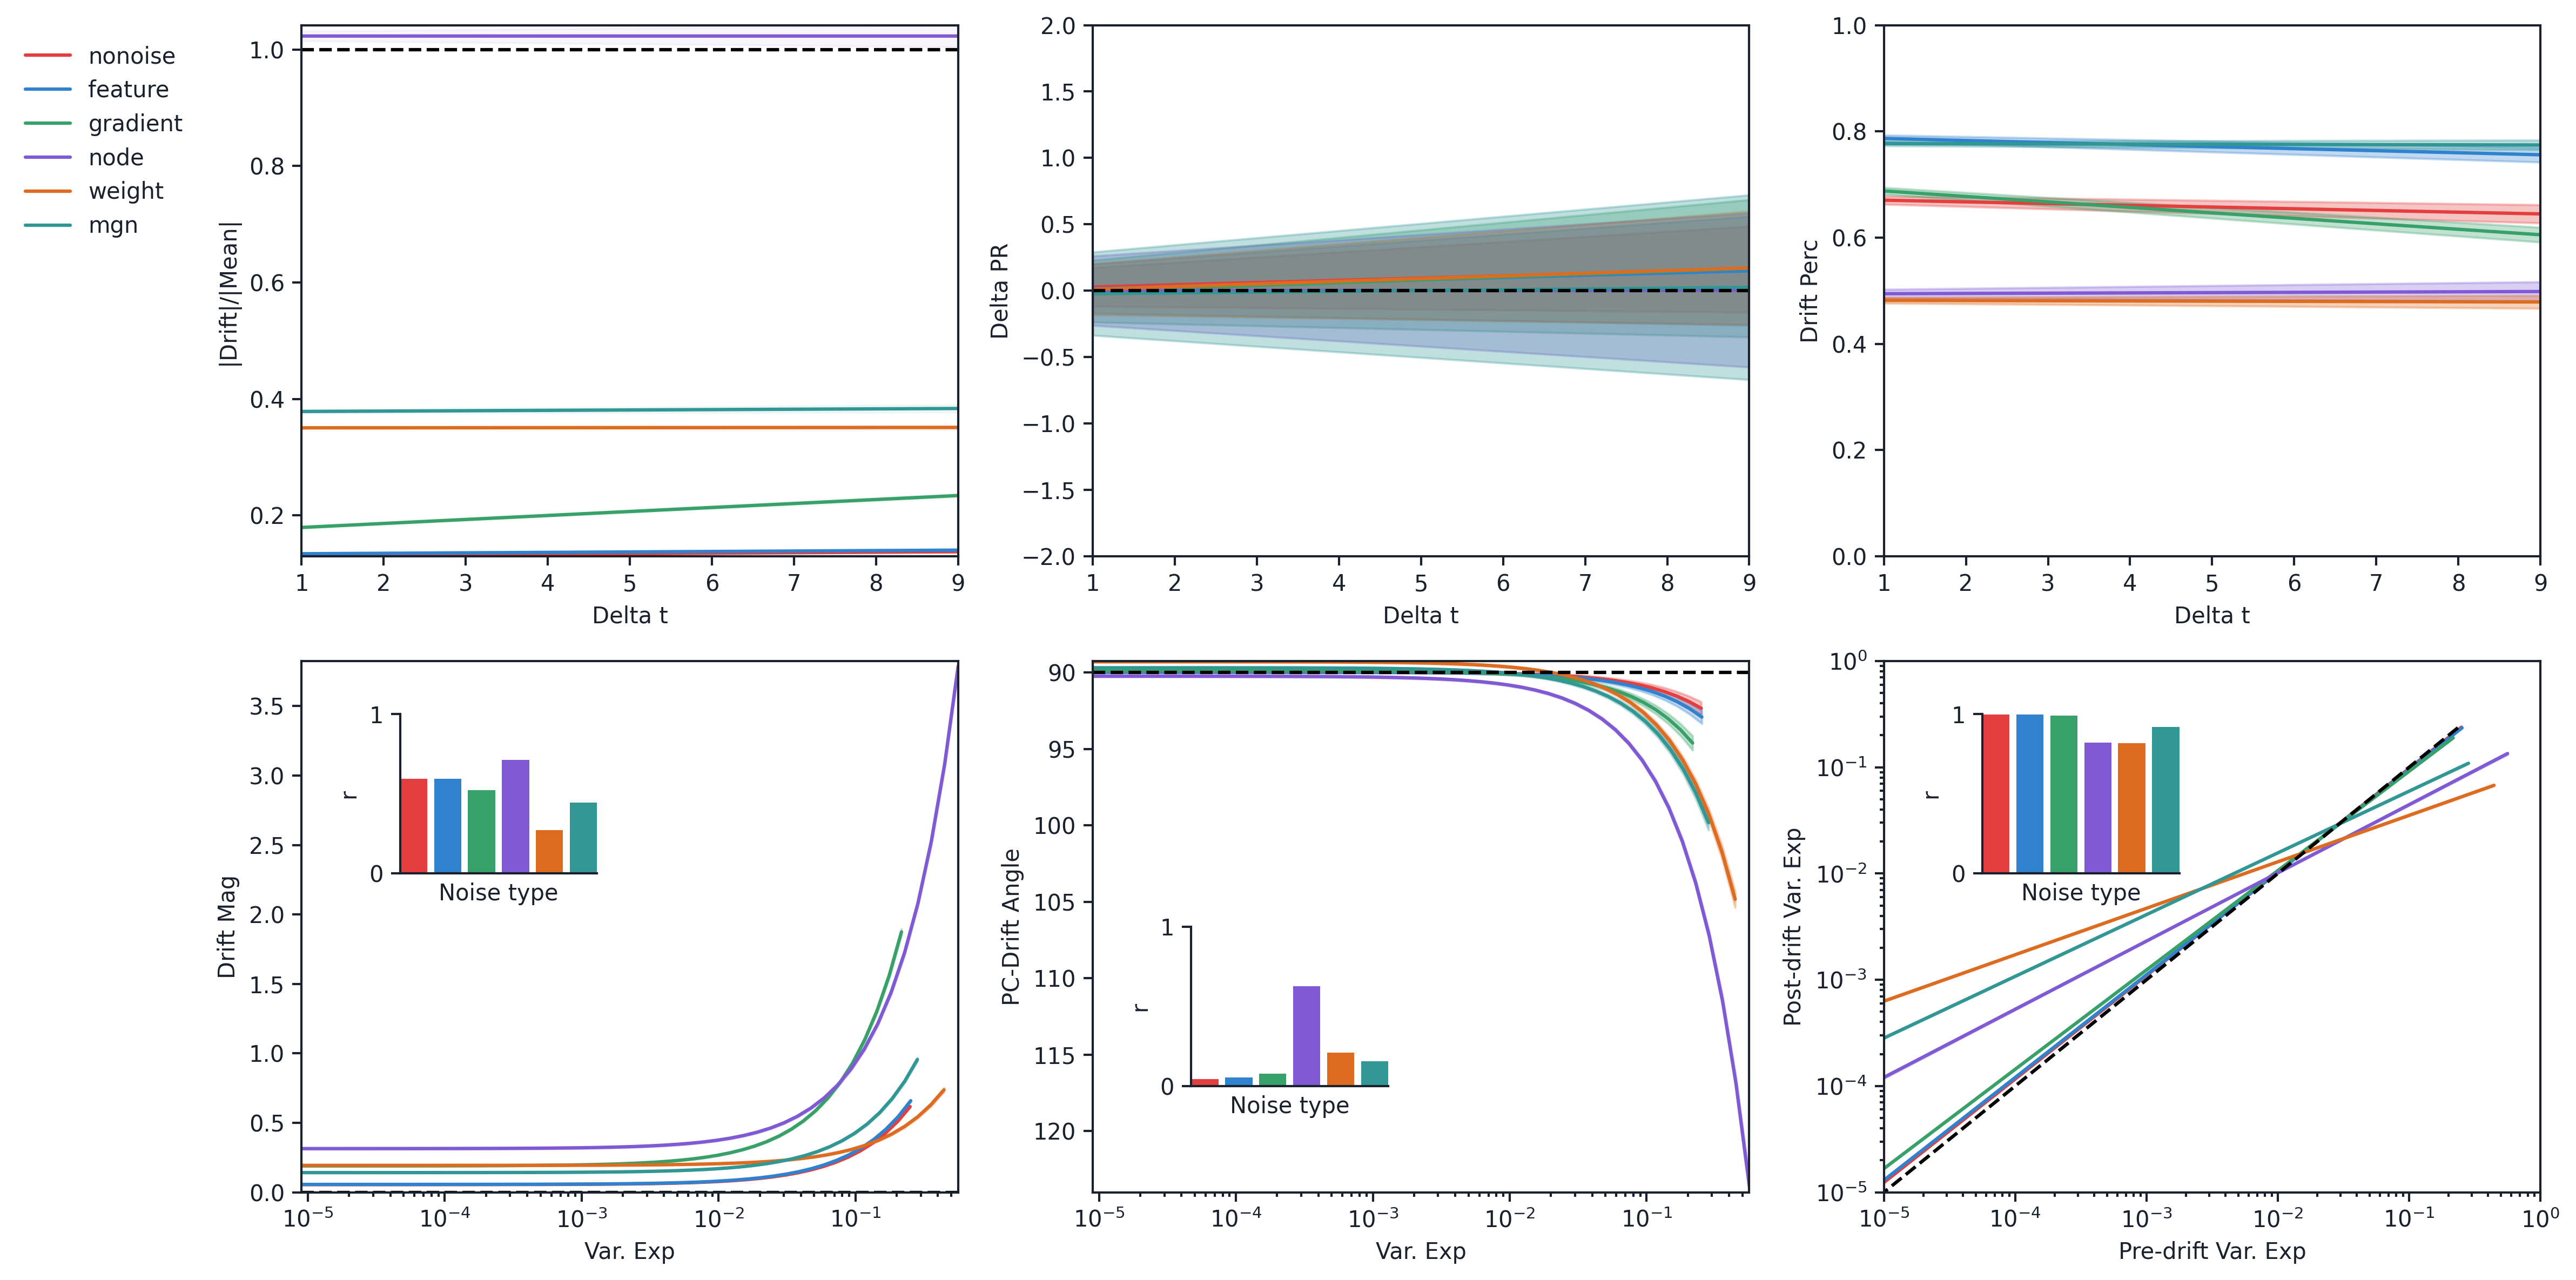

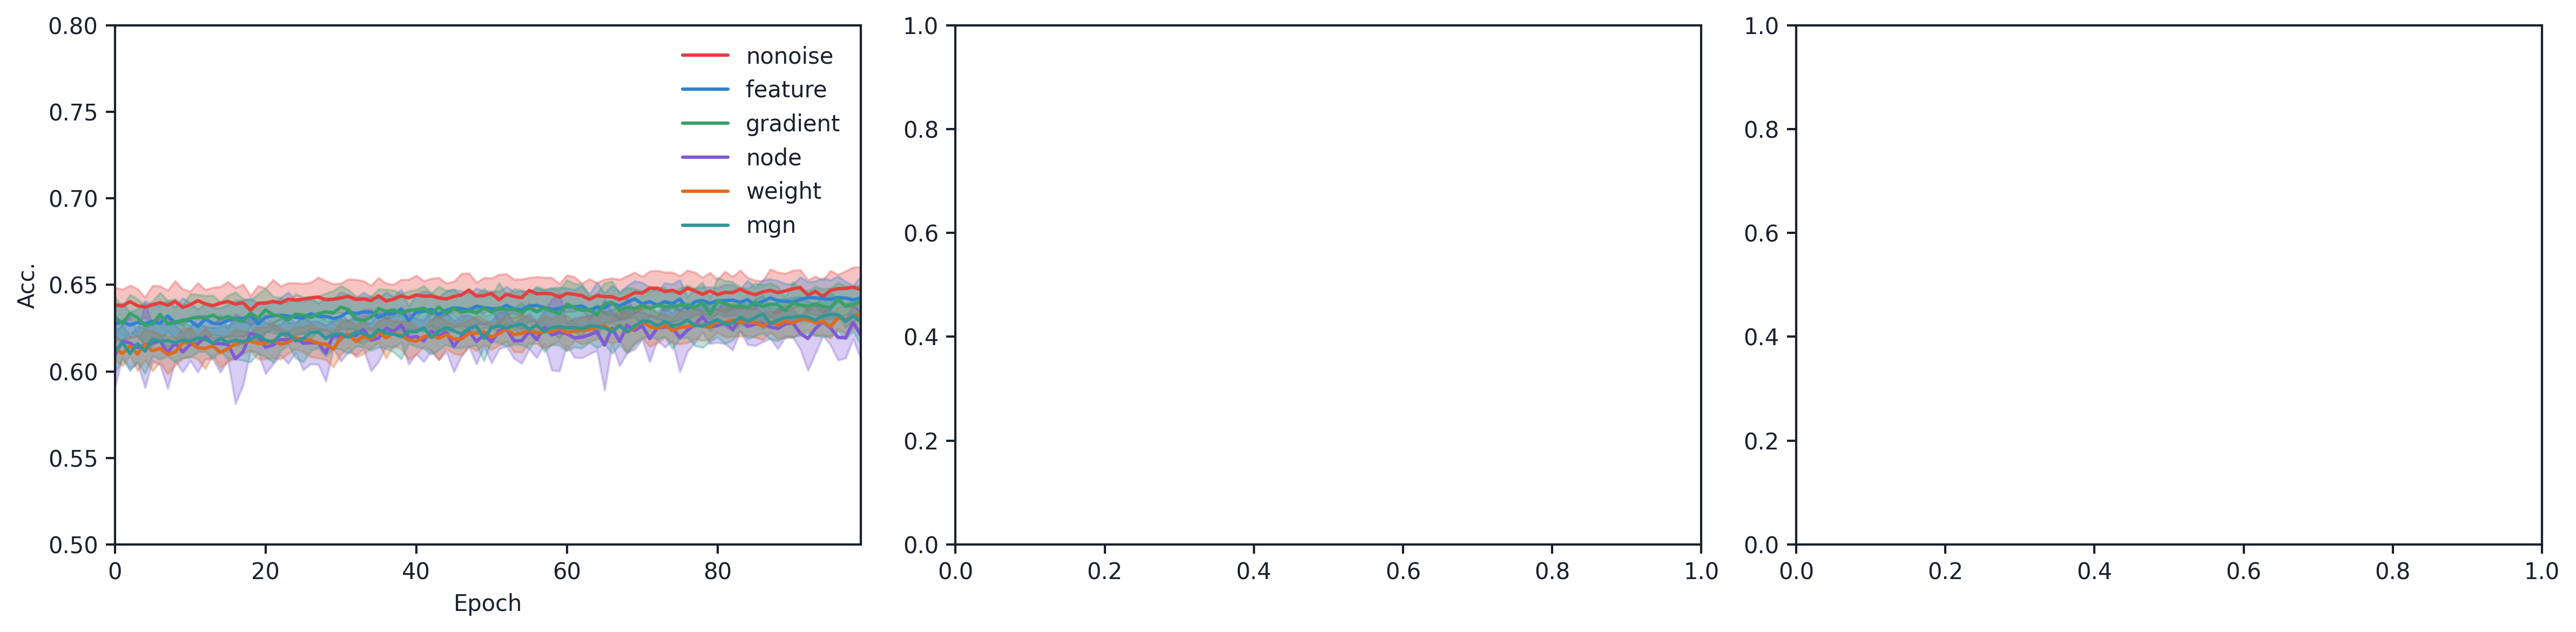

In [ ]:
from mpl_toolkits.axes_grid.inset_locator import (inset_axes, InsetPosition, mark_inset)

min_var_exp = 1e-5

plot_types = ['nonoise', 'feature', 'gradient',  'node', 'weight', 'mgn',] 
# plot_types = ['nonoise', 'feature', 'gradient',  'node_2', 'weight', 'mgn',] # node_2 is p=0.1


fig, ax = plt.subplots(2, 3, figsize=(16,8))
fig2, ax2 = plt.subplots(1, 3, figsize=(16,4))

r1s = []
r2s = []
r3s = []

# root_path = '/content/drive/MyDrive/neuro_research/visual_change_drift/summary_data/CIFAR_plot_data_'
# root_path = '/content/drive/MyDrive/neuro_research/visual_change_drift/summary_data/CIFAR_plot_data_minvarexp1e-5_'
# root_path = '/content/drive/MyDrive/neuro_research/visual_change_drift/summary_data/CIFAR10_plot_data_minvarexp1e-3_'
# root_path = '/content/drive/MyDrive/neuro_research/visual_change_drift/summary_data/CIFAR10_plot_data_minvarexp1e-5_'
root_path = '/content/drive/MyDrive/neuro_research/visual_change_drift/summary_data/CIFAR10_plot_data_l21e-3_minvarexp1e-5_'

e_threshs = [(35,45), (30, 40), (20, 30), (60,70), (70, 80), (35,45)]
n_epochs = [(30, 60), (30, 50), (20, 40), (50, 80), (60, 80), (30, 60)]

for type_idx in range(len(plot_types)):

    path = root_path + plot_types[type_idx] + '.pickle'

    X1, y1, r1, X2, y2, r2, X3, y3, r3, X4, y4, r4, X5, y5, r5, X6, y6, r6, accs = load_plot_data(path)

    ax[0, 0].fill_between(X4, y4[1], y4[2], color=c_vals[type_idx], alpha=0.05)
    ax[0, 0].plot(X4, y4[0], color=c_vals[type_idx], label=plot_types[type_idx])

    ax[0, 1].fill_between(X5, y5[1], y5[2], color=c_vals[type_idx], alpha=0.3)
    ax[0, 1].plot(X5, y5[0], color=c_vals[type_idx], label=plot_types[type_idx])

    ax[0, 2].fill_between(X6, y6[1], y6[2], color=c_vals[type_idx], alpha=0.3)
    ax[0, 2].plot(X6, y6[0], color=c_vals[type_idx], label=plot_types[type_idx])

    ax[1, 0].fill_between(X1, y1[1], y1[2], color=c_vals[type_idx], alpha=0.3)
    ax[1, 0].plot(X1, y1[0], color=c_vals[type_idx], label=plot_types[type_idx])

    ax[1, 1].fill_between(X2, y2[1], y2[2], color=c_vals[type_idx], alpha=0.3)
    ax[1, 1].plot(X2, y2[0], color=c_vals[type_idx], label=plot_types[type_idx])

    ax[1, 2].fill_between(X3, y3[1], y3[2], color=c_vals[type_idx], alpha=0.3)
    ax[1, 2].plot(X3, y3[0], color=c_vals[type_idx], label=plot_types[type_idx])

    idx_thresh = [10*(epoch - n_epochs[type_idx][0])+1 for epoch in e_threshs[type_idx]]

    avg_acc = np.mean(accs, axis=0)[idx_thresh[0]:idx_thresh[1]]
    std_acc = np.std(accs, axis=0)[idx_thresh[0]:idx_thresh[1]]
    epochs = np.arange(100)

    print('Idx thresh:', idx_thresh)

    ax2[0].fill_between(epochs, avg_acc-std_acc, avg_acc+std_acc, 
                        color=c_vals[type_idx], alpha=0.3)
    ax2[0].plot(epochs, avg_acc, color=c_vals[type_idx], label=plot_types[type_idx])

    r1s.append(r1)
    r2s.append(r2)
    r3s.append(r3)

ax[0, 0].axhline(1.0, color='k', linestyle='dashed')
ax[0, 0].set_xlabel('Delta t')
ax[0, 0].set_ylabel('|Drift|/|Mean|')
ax[0, 0].legend(bbox_to_anchor=(-0.15, 1.0))

ax[0, 1].axhline(0.0, color='k', linestyle='dashed')
ax[0, 1].set_xlabel('Delta t')
ax[0, 1].set_ylabel('Delta PR')
ax[0, 1].set_ylim([-2.0, 2.0])

ax[0, 2].set_xlabel('Delta t')
ax[0, 2].set_ylabel('Drift Perc')
ax[0, 2].set_ylim([0.0, 1.0])

ax[1, 0].axhline(0.0, color='k', linestyle='dashed')
ax[1, 0].set_xlabel('Var. Exp')
ax[1, 0].set_ylabel('Drift Mag')
ax[1, 0].set_xscale('log')

ax[1, 1].axhline(90.0, color='k', linestyle='dashed')
ax[1, 1].set_xlabel('Var. Exp')
ax[1, 1].set_ylabel('PC-Drift Angle')
ax[1, 1].set_xscale('log')
ax[1, 1].invert_yaxis()

ax[1, 2].plot(reg_plot_X, reg_plot_X, color='k', linestyle='dashed')
ax[1, 2].set_xlabel('Pre-drift Var. Exp')
ax[1, 2].set_ylabel('Post-drift Var. Exp')
ax[1, 2].set_xlim([min_var_exp, 1.0])
ax[1, 2].set_ylim([min_var_exp, 1.0])
ax[1, 2].set_xscale('log')
ax[1, 2].set_yscale('log')

iax0 = fig.add_axes([0,0,1,1])
iax0.set_axes_locator(InsetPosition(ax[1, 0], [0.15,0.6,0.3,0.3]))
iax0.bar(np.arange(len(plot_types)), r1s, color=c_vals[:len(plot_types)])
iax0.set_ylabel('r')
iax0.set_xlabel('Noise type')
iax0.set_ylim(0,1.0)
# iax2.set_xlim(1,n_to_plot)
iax0.set_xticks([])
iax0.set_yticks([0, 1])
iax0.spines["top"].set_visible(False)
iax0.spines["right"].set_visible(False)
# iax0.spines["bottom"].set_visible(False)
# iax0.spines["left"].set_visible(False)

iax1 = fig.add_axes([0,0,1.1,1.1])
iax1.set_axes_locator(InsetPosition(ax[1, 1], [0.15,0.2,0.3,0.3]))
iax1.bar(np.arange(len(plot_types)), r2s, color=c_vals[:len(plot_types)])
iax1.set_ylabel('r')
iax1.set_xlabel('Noise type')
iax1.set_ylim(0,1.0)
# iax2.set_xlim(1,n_to_plot)
iax1.set_xticks([])
iax1.set_yticks([0, 1])
iax1.spines["top"].set_visible(False)
iax1.spines["right"].set_visible(False)

iax2 = fig.add_axes([0,0,1.2,1.2])
iax2.set_axes_locator(InsetPosition(ax[1, 2], [0.15,0.6,0.3,0.3]))
iax2.bar(np.arange(len(plot_types)), r3s, color=c_vals[:len(plot_types)])
iax2.set_ylabel('r')
iax2.set_xlabel('Noise type')
iax2.set_ylim(0,1.0)
# iax2.set_xlim(1,n_to_plot)
iax2.set_xticks([])
iax2.set_yticks([0, 1])
iax2.spines["top"].set_visible(False)
iax2.spines["right"].set_visible(False)

ax2[0].set_xlabel('Epoch')
ax2[0].set_ylabel('Acc.')
ax2[0].set_ylim([.50, .80])
ax2[0].legend()


Squaring var percentage.
Idx thresh: [51, 151]
Squaring var percentage.
Idx thresh: [1, 101]
Squaring var percentage.
Idx thresh: [1, 101]
Squaring var percentage.
Idx thresh: [101, 201]
Squaring var percentage.
Idx thresh: [101, 201]
Squaring var percentage.
Idx thresh: [51, 151]


/usr/local/lib/python3.7/dist-packages/google/colab/_event_manager.py:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/IPython/core/pylabtools.py:125: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


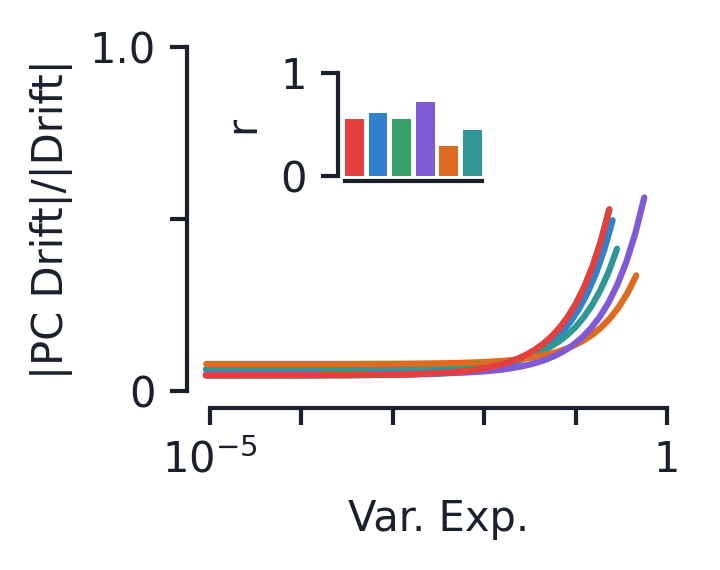

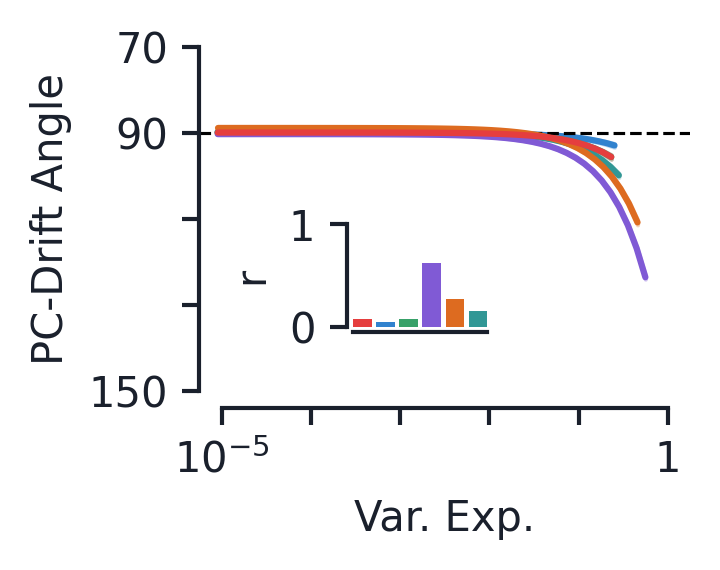

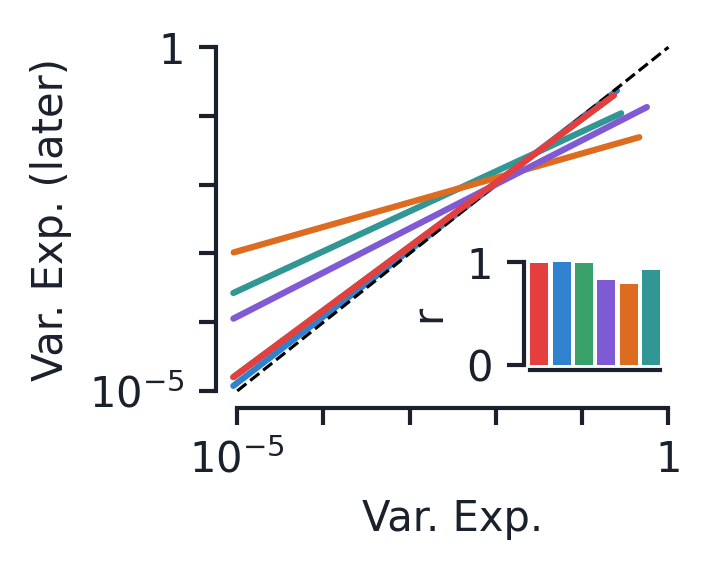

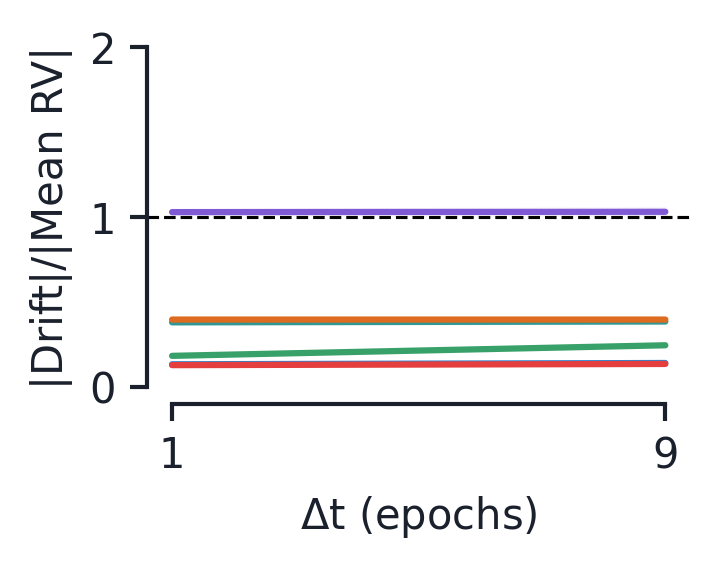

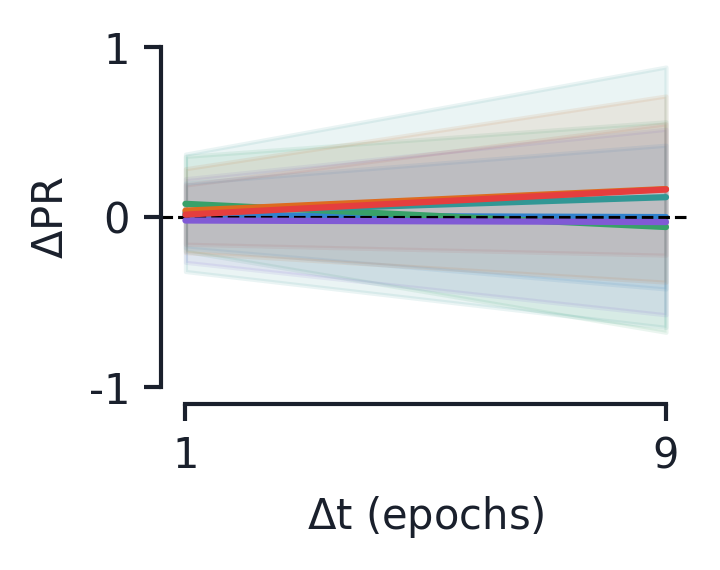

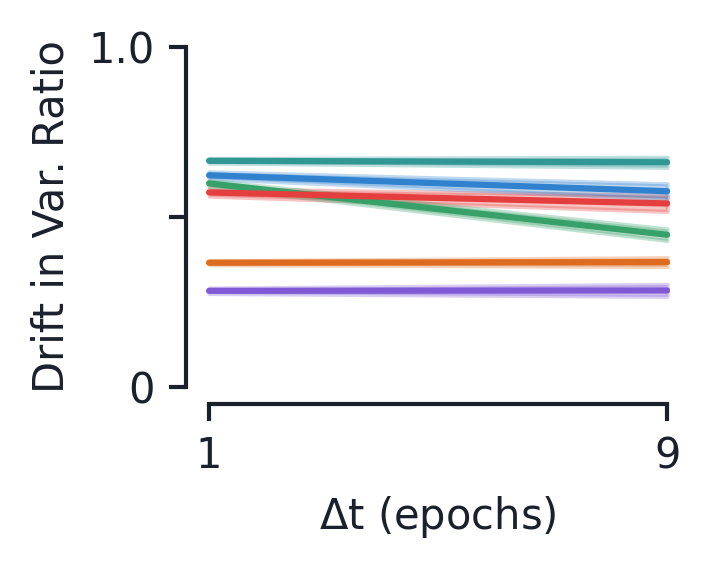

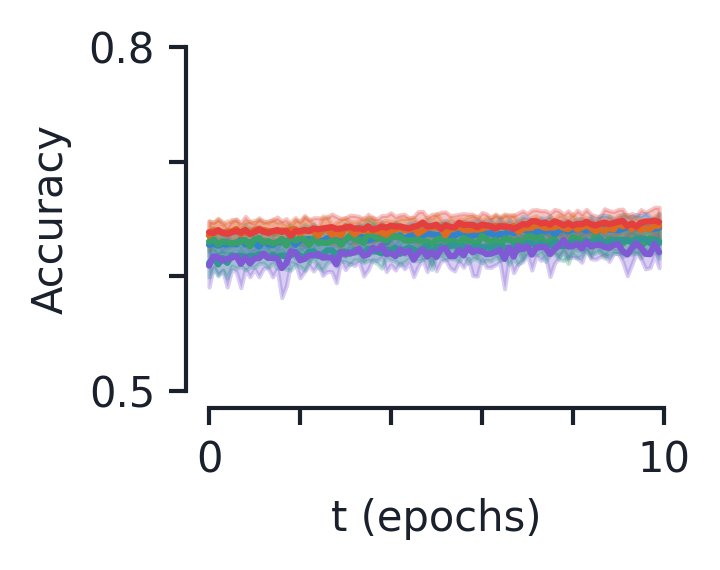

In [ ]:
from mpl_toolkits.axes_grid.inset_locator import (inset_axes, InsetPosition, mark_inset)

min_var_exp = 1e-5

plot_types = ['nonoise', 'feature', 'gradient',  'node', 'weight', 'mgn',] 
# plot_types = ['nonoise', 'feature', 'gradient',  'node_2', 'weight', 'mgn',] # node_2 is p=0.1

fig0, ax0 = plt.subplots(1, 1, figsize=(2.5,2))
fig1, ax1 = plt.subplots(1, 1, figsize=(2.5,2))
fig2, ax2 = plt.subplots(1, 1, figsize=(2.5,2))
fig3, ax3 = plt.subplots(1, 1, figsize=(2.5,2))
fig4, ax4 = plt.subplots(1, 1, figsize=(2.5,2))
fig5, ax5 = plt.subplots(1, 1, figsize=(2.5,2))
fig6, ax6 = plt.subplots(1, 1, figsize=(2.5,2))

r1s = []
r2s = []
r3s = []

# root_path = '/content/drive/MyDrive/neuro_research/visual_change_drift/summary_data/CIFAR_plot_data_'
# root_path = '/content/drive/MyDrive/neuro_research/visual_change_drift/summary_data/CIFAR_plot_data_minvarexp1e-5_'
# root_path = '/content/drive/MyDrive/neuro_research/visual_change_drift/summary_data/CIFAR10_plot_data_minvarexp1e-3_'
# root_path = '/content/drive/MyDrive/neuro_research/visual_change_drift/summary_data/CIFAR10_plot_data_minvarexp1e-5_'

root_path = '/content/drive/MyDrive/neuro_research/visual_change_drift/summary_data/CIFAR10_plot_data_l21e-3_minvarexp1e-5_'

plot_types = ['nonoise', 'feature', 'gradient',  'node', 'weight', 'mgn',] 
e_threshs = [(35,45), (30, 40), (20, 30), (60,70), (70, 80), (35,45)]
n_epochs = [(30, 60), (30, 50), (20, 40), (50, 80), (60, 80), (30, 60)]
plot_type_c_idxs = [0, 1, 2, 3, 4, 5]

# plot_types = ['node', 'node_tar_max', 'node_tar_min',]
# e_threshs = [(60,70), (49, 59), (35, 45)]
# n_epochs = [(50, 80), (0, 60), (0, 60)]
# plot_type_c_idxs = [3, 7, 8]

for type_idx in range(len(plot_types)):

    if type_idx == 0: # Make sure certain types are more visible
        zorder_val = 5
    elif type_idx == 3:
        zorder_val = 4
    elif type_idx == 4:
        zorder_val = 3
    else:
        zorder_val = 1

    path = root_path + plot_types[type_idx] + '.pickle'

    X1, y1, r1, X2, y2, r2, X3, y3, r3, X4, y4, r4, X5, y5, r5, X6, y6, r6, accs = load_plot_data(path)

    # Gamma was defined differently in these saves, so squaring it to match new definition
    print('Squaring var percentage.')
    y6new = [y6[0]**2, y6[1]**2, y6[2]**2]

    c_idx = plot_type_c_idxs[type_idx]

    ax3.fill_between(X4, y4[1], y4[2], color=c_vals[c_idx], alpha=0.05)
    ax3.plot(X4, y4[0], color=c_vals[c_idx], label=plot_types[type_idx], zorder=zorder_val)

    ax4.fill_between(X5, y5[1], y5[2], color=c_vals[c_idx], alpha=0.1)
    ax4.plot(X5, y5[0], color=c_vals[c_idx], label=plot_types[type_idx], zorder=zorder_val)

    ax5.fill_between(X6, y6new[1], y6new[2], color=c_vals[c_idx], alpha=0.3)
    ax5.plot(X6, y6new[0], color=c_vals[c_idx], label=plot_types[type_idx], zorder=zorder_val)

    ax0.fill_between(X1, y1[1], y1[2], color=c_vals[c_idx], alpha=0.3)
    ax0.plot(X1, y1[0], color=c_vals[c_idx], label=plot_types[type_idx], zorder=zorder_val)

    ax1.fill_between(X2, y2[1], y2[2], color=c_vals[c_idx], alpha=0.3)
    ax1.plot(X2, y2[0], color=c_vals[c_idx], label=plot_types[type_idx], zorder=zorder_val)

    ax2.fill_between(X3, y3[1], y3[2], color=c_vals[c_idx], alpha=0.3)
    ax2.plot(X3, y3[0], color=c_vals[c_idx], label=plot_types[type_idx], zorder=zorder_val)

    idx_thresh = [10*(epoch - n_epochs[type_idx][0])+1 for epoch in e_threshs[type_idx]]

    avg_acc = np.mean(accs, axis=0)[idx_thresh[0]:idx_thresh[1]]
    std_acc = np.std(accs, axis=0)[idx_thresh[0]:idx_thresh[1]]
    epochs = np.arange(100)

    print('Idx thresh:', idx_thresh)

    ax6.fill_between(epochs, avg_acc-std_acc, avg_acc+std_acc, 
                        color=c_vals[c_idx], alpha=0.3)
    ax6.plot(epochs, avg_acc, color=c_vals[c_idx], label=plot_types[type_idx], zorder=zorder_val)

    r1s.append(r1)
    r2s.append(r2)
    r3s.append(r3)

ax3.axhline(1.0, color='k', linestyle='dashed', linewidth=0.75)
ax3.set_xlabel('$\Delta$t (epochs)')
ax3.set_xlim([1, 9])
ax3.set_xticks([1, 9])
ax3.set_ylabel('|Drift|/|Mean RV|')
ax3.set_ylim([0, 2])
ax3.set_yticks([0, 1, 2])
ax3.set_yticklabels([0, 1, 2])

ax4.axhline(0.0, color='k', linestyle='dashed', linewidth=0.75)
ax4.set_xlabel('$\Delta$t (epochs)')
ax4.set_xlim([1, 9])
ax4.set_xticks([1, 9])
ax4.set_ylabel('$\Delta$PR')
ax4.set_ylim([-1, 1])
ax4.set_yticks([-1, 0, 1])
ax4.set_yticklabels([-1, 0, 1])

ax5.set_xlabel('$\Delta$t (epochs)')
ax5.set_xlim([1, 9])
ax5.set_xticks([1, 9])
ax5.set_ylabel('Drift in Var. Ratio')
ax5.set_ylim([0.0, 1.0])
ax5.set_yticks([0, 0.5, 1.0])
ax5.set_yticklabels([0, None, 1.0])

ax0.set_xlabel('Var. Exp.')
ax0.set_ylabel('|PC Drift|/|Drift|')
ax0.set_xscale('log')
ax0.set_xlim([min_var_exp, 1.0])
ax0.set_xticks([1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1])
ax0.set_xticklabels(['$10^{-5}$', None, None, None, None, 1])
ax0.set_ylim([0, 1.0])
ax0.set_yticks([0, 0.5, 1.0])
ax0.set_yticklabels([0, None, 1.0])

ax1.axhline(90.0, color='k', linestyle='dashed', linewidth=0.75)
ax1.set_xscale('log')
ax1.set_xlabel('Var. Exp.')
ax1.set_xlim([min_var_exp, 1.0])
ax1.set_xticks([1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1])
ax1.set_xticklabels(['$10^{-5}$', None, None, None, None, 1])
ax1.set_ylabel('PC-Drift Angle')
ax1.set_ylim([70, 150])
ax1.set_yticks([70, 90, 110, 130, 150])
ax1.set_yticklabels([70, 90, None, None, 150])
ax1.invert_yaxis()

ax2.plot([min_var_exp, 1.0], [min_var_exp, 1.0], color='k', linestyle='dashed', linewidth=0.75)
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_xlabel('Var. Exp.')
ax2.set_xlim([min_var_exp, 1.0])
ax2.set_xticks([1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1])
ax2.set_xticklabels(['$10^{-5}$', None, None, None, None, 1])
ax2.set_ylabel('Var. Exp. (later)')
ax2.set_ylim([min_var_exp, 1.0])
ax2.set_yticks([1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1])
ax2.set_yticklabels(['$10^{-5}$', None, None, None, None, 1])

bar_colors = [c_vals[c_idx] for c_idx in plot_type_c_idxs]

iax0 = fig0.add_axes([0,0,1,1])
iax0.set_axes_locator(InsetPosition(ax0, [0.3,0.6,0.3,0.3]))
iax0.bar(np.arange(len(plot_types)), r1s, color=bar_colors)
iax0.set_ylabel('r')
# iax0.set_xlabel('Noise')
iax0.set_ylim(0,1.0)
# iax2.set_xlim(1,n_to_plot)
iax0.set_xticks([])
iax0.set_yticks([0, 1])
iax0.spines["top"].set_visible(False)
iax0.spines["right"].set_visible(False)
# iax0.spines["bottom"].set_visible(False)
# iax0.spines["left"].set_visible(False)

iax1 = fig1.add_axes([0,0,1.01,1.01])
iax1.set_axes_locator(InsetPosition(ax1, [0.3,0.2,0.3,0.3]))
iax1.bar(np.arange(len(plot_types)), r2s, color=bar_colors)
iax1.set_ylabel('r')
# iax1.set_xlabel('Noise')
iax1.set_ylim(0,1.0)
# iax2.set_xlim(1,n_to_plot)
iax1.set_xticks([])
iax1.set_yticks([0, 1])
iax1.spines["top"].set_visible(False)
iax1.spines["right"].set_visible(False)

iax2 = fig2.add_axes([0,0,1.02,1.02])
iax2.set_axes_locator(InsetPosition(ax2, [0.65,0.1,0.3,0.3]))
iax2.bar(np.arange(len(plot_types)), r3s, color=bar_colors)
iax2.set_ylabel('r')
# iax2.set_xlabel('Noise')
iax2.set_ylim(0,1.0)
iax2.set_yticks([0, 1])
# iax2.set_xlim(1,n_to_plot)
iax2.set_xticks([])
iax2.spines["top"].set_visible(False)
iax2.spines["right"].set_visible(False)

ax6.set_xlabel('t (epochs)')
ax6.set_xlim([0, 100])
ax6.set_xticks([0, 20, 40, 60, 80, 100])
ax6.set_xticklabels([0, None, None, None, None, 10])
ax6.set_ylabel('Accuracy')
ax6.set_ylim([.50, .80])
ax6.set_yticks([0.5, 0.6, 0.7, 0.8])
ax6.set_yticklabels([0.5, None, None, 0.8])

jetplot.breathe(ax=ax0)
jetplot.breathe(ax=ax1)
jetplot.breathe(ax=ax2)
jetplot.breathe(ax=ax3)
jetplot.breathe(ax=ax4)
jetplot.breathe(ax=ax5)
jetplot.breathe(ax=ax6)

jetplot.breathe(ax=iax0)
jetplot.breathe(ax=iax1)
jetplot.breathe(ax=iax2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.
  """Entry point for launching an IPython kernel.


NameError: ignored

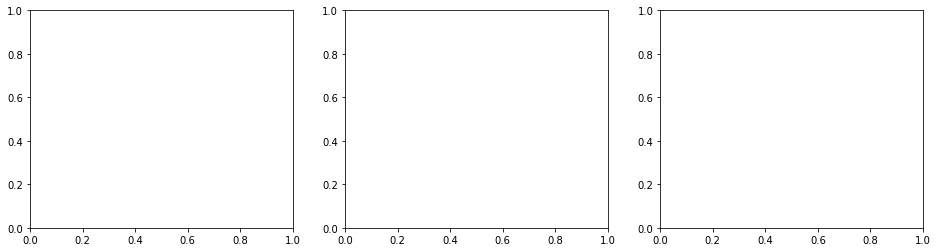

In [17]:
from mpl_toolkits.axes_grid.inset_locator import (inset_axes, InsetPosition, mark_inset)

min_var_exp = 1e-5
n_time_drift = 1

plot_types = ['nonoise', 'feature', 'gradient',  'node', 'weight', 'mgn',]
type_idx = 2

fig, ax = plt.subplots(1, 3, figsize=(16,4))

ax[0].scatter(pca_var_exp_i_fit[class_idx_save],
                  pca_drift_mag_fit[class_idx_save],
                  marker='.', color=c_vals_l[type_idx], 
                  alpha=0.01)
ax[0].fill_between(drift_mag_fits_X, drift_mag_fits_y[1], drift_mag_fits_y[2], color=c_vals[type_idx], alpha=0.3)
ax[0].plot(drift_mag_fits_X, drift_mag_fits_y[0], color=c_vals[type_idx], label=plot_types[type_idx])

ax[1].scatter(pca_var_exp_i_fit[class_idx_save],
                pca_drift_angles_fit[class_idx_save],
                marker='.', color=c_vals_l[type_idx], 
                alpha=0.01)
ax[1].fill_between(drift_angle_fits_X, drift_angle_fits_y[1], drift_angle_fits_y[2], color=c_vals[type_idx], alpha=0.3)
ax[1].plot(drift_angle_fits_X, drift_angle_fits_y[0], color=c_vals[type_idx], label=plot_types[type_idx])

ax[2].scatter(pca_var_exp_i_fit[class_idx_save], 
                pca_i_var_exp_f_fit[class_idx_save],
                marker='.', color=c_vals_l[type_idx], 
                alpha=0.01)
ax[2].fill_between(change_varexp_fits_X, change_varexp_fits_y[1], change_varexp_fits_y[2], color=c_vals[type_idx], alpha=0.3)
ax[2].plot(change_varexp_fits_X, change_varexp_fits_y[0], color=c_vals[type_idx], label=plot_types[type_idx])

ax[0].axhline(0.0, color='k', linestyle='dashed')
ax[0].set_xlim([min_var_exp, 1.0])
ax[0].set_xlabel('Var. Exp')
ax[0].set_ylabel('Drift Mag')
ax[0].set_xscale('log')
ax[0].set_ylim([-0.25, 4.0])

ax[1].axhline(90.0, color='k', linestyle='dashed')
ax[1].set_xlim([min_var_exp, 1.0])
ax[1].set_xlabel('Var. Exp')
ax[1].set_ylabel('PC-Drift Angle')
ax[1].set_xscale('log')
# ax[1].set_ylim([85, 135])
ax[1].invert_yaxis()
ax[1].text(0.3, 0.2, 'r = {:.2f}\na = {:.1f}'.format(reg2.rvalue, reg2.slope), 
           horizontalalignment='center', verticalalignment='center', 
           transform=ax[1].transAxes, color=c_vals[type_idx])

ax[2].plot(reg_plot_X, reg_plot_X, color='k', linestyle='dashed')
ax[2].set_xlabel('Pre-drift Var. Exp')
ax[2].set_ylabel('Post-drift Var. Exp')
ax[2].set_xlim([min_var_exp, 1.0])
ax[2].set_ylim([min_var_exp, 1.0])
ax[2].set_xscale('log')
ax[2].set_yscale('log')
ax[2].text(0.6, 0.2, 'r = {:.2f}\na = {:.2f}'.format(reg3.rvalue, reg3.slope), 
           horizontalalignment='center', verticalalignment='center', 
           transform=ax[2].transAxes, color=c_vals[type_idx])


max_pc = 20

fig, ax = plt.subplots(1, 3, figsize=(16,4))

pcs = np.arange(1, n_feats+1)
pcs_flat = np.concatenate([(i+1)*np.ones((n_trials * (n_thresh-n_time_drift), 1)) for i in range(n_feats)], axis=-1)
pca_drift_mag_flat = pca_drift_mag[:, class_idx_save].reshape((n_trials * (n_thresh-n_time_drift), n_feats))
pca_drift_angles_flat = pca_drift_angles[:, class_idx_save].reshape((n_trials * (n_thresh-n_time_drift), n_feats))
pca_i_var_exp_f_flat = pca_i_var_exp_f[:, class_idx_save].reshape((n_trials * (n_thresh-n_time_drift), n_feats))

avg_drift_mag = np.mean(pca_drift_mag_flat, axis=0)
std_drift_mag = np.std(pca_drift_mag_flat, axis=0)
avg_drift_angle = np.mean(pca_drift_angles_flat, axis=0)
std_drift_angle = np.std(pca_drift_angles_flat, axis=0)
avg_var_flow = np.mean(pca_i_var_exp_f_flat, axis=0)
std_var_flow = np.std(pca_i_var_exp_f_flat, axis=0)

for pc_idx in range(n_feats):
    ax[0].scatter(pcs_flat[:, pc_idx], pca_drift_mag_flat[:, pc_idx],
                  marker='.', color=c_vals_l[type_idx], 
                  alpha=0.01)
    ax[1].scatter(pcs_flat[:, pc_idx], pca_drift_angles_flat[:, pc_idx],
                  marker='.', color=c_vals_l[type_idx], 
                  alpha=0.01)
    ax[2].scatter(pcs_flat[:, pc_idx], pca_i_var_exp_f_flat[:, pc_idx],
                  marker='.', color=c_vals_l[type_idx], 
                  alpha=0.01)
    
ax[0].fill_between(pcs, avg_drift_mag-std_drift_mag, 
                   avg_drift_mag+std_drift_mag, color=c_vals[type_idx], 
                   alpha=0.3)
ax[0].plot(pcs, avg_drift_mag, color=c_vals[type_idx], label=plot_types[type_idx])

ax[1].fill_between(pcs, avg_drift_angle-std_drift_angle, 
                   avg_drift_angle+std_drift_angle, color=c_vals[type_idx], 
                   alpha=0.3)
ax[1].plot(pcs, avg_drift_angle, color=c_vals[type_idx], label=plot_types[type_idx])

ax[2].fill_between(pcs, avg_var_flow-std_var_flow, 
                   avg_var_flow+std_var_flow, color=c_vals[type_idx], 
                   alpha=0.3)
ax[2].plot(pcs, avg_var_flow, color=c_vals[type_idx], label=plot_types[type_idx])

ax[0].axhline(0.0, color='k', linestyle='dashed')
ax[0].set_xlabel('PC')
ax[0].set_ylabel('Drift Mag')
ax[0].set_xlim((0, max_pc+1))
ax[0].set_ylim([-0.25, 4.0])

ax[1].axhline(90.0, color='k', linestyle='dashed')
ax[1].set_xlabel('PC')
ax[1].set_ylabel('PC-Drift Angle')
ax[1].set_xlim((0, max_pc+1))
# ax[1].set_ylim([85, 135])
ax[1].invert_yaxis()

ax[2].set_xlabel('PC')
ax[2].set_ylabel('Post-drift Var. Exp')
ax[2].set_xlim((0, max_pc+1))
ax[2].set_ylim([min_var_exp, 1.0])
ax[2].set_yscale('log')


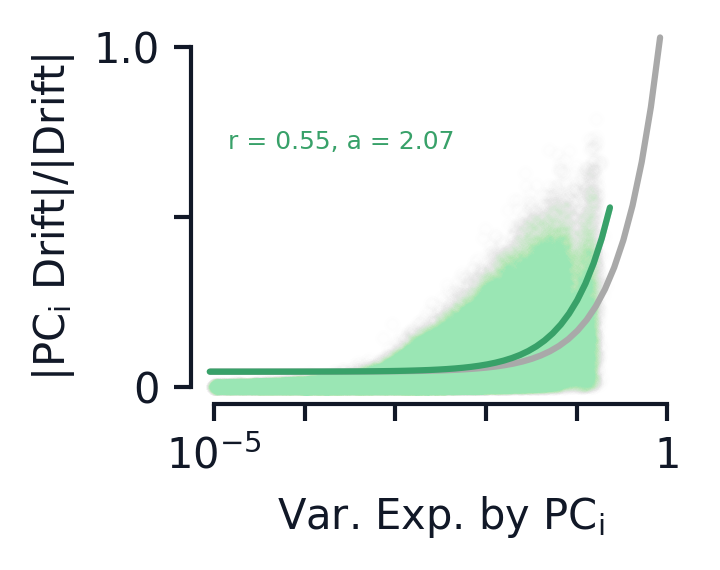

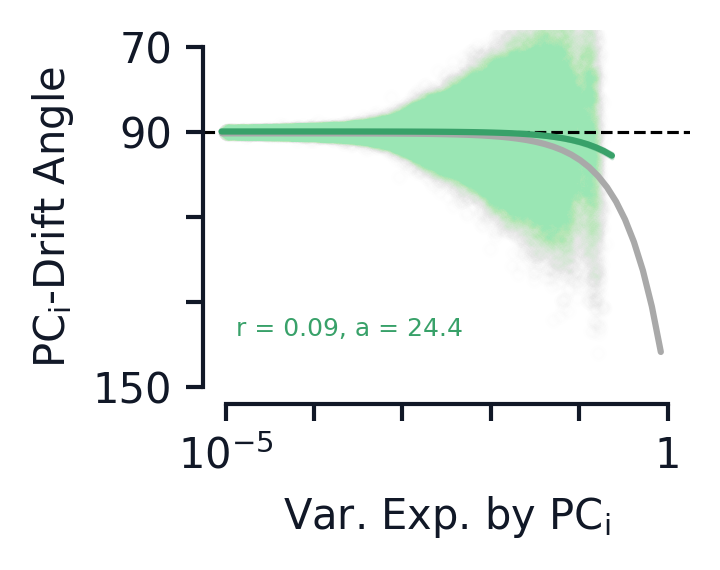

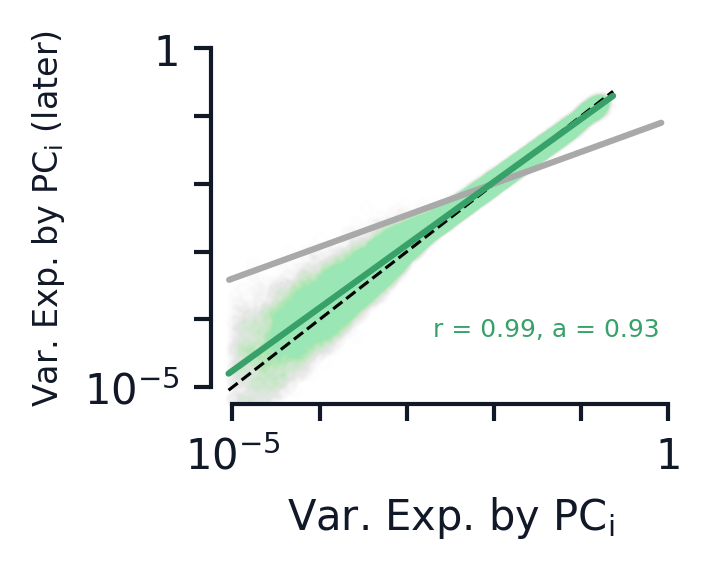

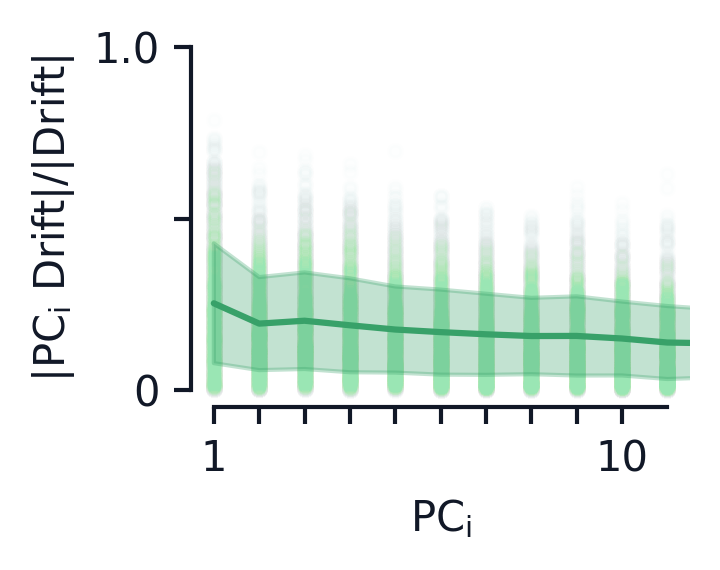

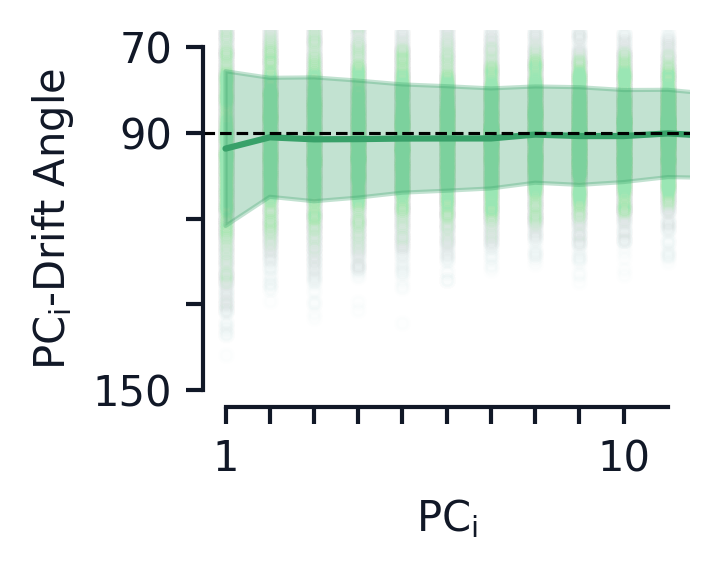

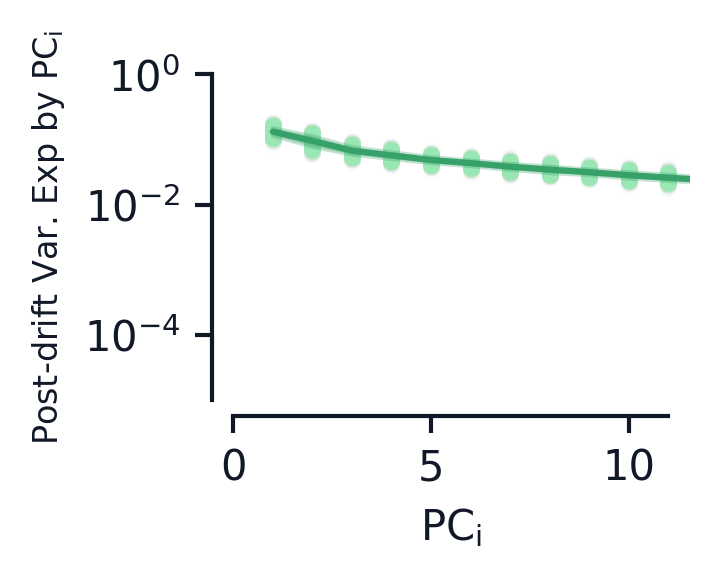

In [ ]:
from mpl_toolkits.axes_grid.inset_locator import (inset_axes, InsetPosition, mark_inset)

min_var_exp = 1e-5

plot_types = ['nonoise', 'feature', 'gradient',  'node', 'weight', 'mgn',]
type_idx = 2

n_time_drift = 1 # Resets after delta t runs

fig0, ax0 = plt.subplots(1, 1, figsize=(2.5,2))
fig1, ax1 = plt.subplots(1, 1, figsize=(2.5,2))
fig2, ax2 = plt.subplots(1, 1, figsize=(2.5,2))
fig3, ax3 = plt.subplots(1, 1, figsize=(2.5,2))
fig4, ax4 = plt.subplots(1, 1, figsize=(2.5,2))
fig5, ax5 = plt.subplots(1, 1, figsize=(2.5,2))

ax0.scatter(pca_var_exp_i_fit[class_idx_save],
                  pca_drift_mag_fit[class_idx_save],
                  marker='.', color=c_vals_l[type_idx], 
                  alpha=0.005)
ax0.fill_between(drift_mag_fits_X, drift_mag_fits_y[1], drift_mag_fits_y[2], color=c_vals[type_idx], alpha=0.3)
ax0.plot(drift_mag_fits_X, drift_mag_fits_y[0], color=c_vals[type_idx], label=plot_types[type_idx])

ax1.scatter(pca_var_exp_i_fit[class_idx_save],
                pca_drift_angles_fit[class_idx_save],
                marker='.', color=c_vals_l[type_idx], 
                alpha=0.005)
ax1.fill_between(drift_angle_fits_X, drift_angle_fits_y[1], drift_angle_fits_y[2], color=c_vals[type_idx], alpha=0.3)
ax1.plot(drift_angle_fits_X, drift_angle_fits_y[0], color=c_vals[type_idx], label=plot_types[type_idx])

ax2.scatter(pca_var_exp_i_fit[class_idx_save], 
                pca_i_var_exp_f_fit[class_idx_save],
                marker='.', color=c_vals_l[type_idx], 
                alpha=0.005)
ax2.fill_between(change_varexp_fits_X, change_varexp_fits_y[1], change_varexp_fits_y[2], color=c_vals[type_idx], alpha=0.3)
ax2.plot(change_varexp_fits_X, change_varexp_fits_y[0], color=c_vals[type_idx], label=plot_types[type_idx])

max_pc = 10

pcs = np.arange(1, n_feats+1)
pcs_flat = np.concatenate([(i+1)*np.ones((n_trials * (n_thresh-n_time_drift), 1)) for i in range(n_feats)], axis=-1)
pca_drift_mag_flat = pca_drift_mag[:, class_idx_save].reshape((n_trials * (n_thresh-n_time_drift), n_feats))
pca_drift_angles_flat = pca_drift_angles[:, class_idx_save].reshape((n_trials * (n_thresh-n_time_drift), n_feats))
pca_i_var_exp_f_flat = pca_i_var_exp_f[:, class_idx_save].reshape((n_trials * (n_thresh-n_time_drift), n_feats))

avg_drift_mag = np.mean(pca_drift_mag_flat, axis=0)
std_drift_mag = np.std(pca_drift_mag_flat, axis=0)
avg_drift_angle = np.mean(pca_drift_angles_flat, axis=0)
std_drift_angle = np.std(pca_drift_angles_flat, axis=0)
avg_var_flow = np.mean(pca_i_var_exp_f_flat, axis=0)
std_var_flow = np.std(pca_i_var_exp_f_flat, axis=0)

for pc_idx in range(n_feats):
    ax3.scatter(pcs_flat[:, pc_idx], pca_drift_mag_flat[:, pc_idx],
                  marker='.', color=c_vals_l[type_idx], 
                  alpha=0.01)
    ax4.scatter(pcs_flat[:, pc_idx], pca_drift_angles_flat[:, pc_idx],
                  marker='.', color=c_vals_l[type_idx], 
                  alpha=0.01)
    ax5.scatter(pcs_flat[:, pc_idx], pca_i_var_exp_f_flat[:, pc_idx],
                  marker='.', color=c_vals_l[type_idx], 
                  alpha=0.01)
    
ax3.fill_between(pcs, avg_drift_mag-std_drift_mag, 
                   avg_drift_mag+std_drift_mag, color=c_vals[type_idx], 
                   alpha=0.3)
ax3.plot(pcs, avg_drift_mag, color=c_vals[type_idx], label=plot_types[type_idx])

ax4.fill_between(pcs, avg_drift_angle-std_drift_angle, 
                   avg_drift_angle+std_drift_angle, color=c_vals[type_idx], 
                   alpha=0.3)
ax4.plot(pcs, avg_drift_angle, color=c_vals[type_idx], label=plot_types[type_idx])

ax5.fill_between(pcs, avg_var_flow-std_var_flow, 
                   avg_var_flow+std_var_flow, color=c_vals[type_idx], 
                   alpha=0.3)
ax5.plot(pcs, avg_var_flow, color=c_vals[type_idx], label=plot_types[type_idx])

ax0.set_xlabel('Var. Exp.')
ax0.set_ylabel('|PC Drift|/|Drift|')
ax0.set_xscale('log')
ax0.set_xlim([min_var_exp, 1.0])
ax0.set_xticks([1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1])
ax0.set_xticklabels(['$10^{-5}$', None, None, None, None, 1])
ax0.set_ylim([0, 1.0])
ax0.set_yticks([0, 0.5, 1.0])
ax0.set_yticklabels([0, None, 1.0])
ax0.text(0.3, 0.7, 'r = {:.2f}, a = {:.2f}'.format(reg1.rvalue, reg1.slope), 
           horizontalalignment='center', verticalalignment='center', 
           color=c_vals[type_idx], fontsize=6, transform=ax0.transAxes)

ax1.axhline(90.0, color='k', linestyle='dashed', linewidth=0.75)
ax1.set_xscale('log')
ax1.set_xlabel('Var. Exp.')
ax1.set_xlim([min_var_exp, 1.0])
ax1.set_xticks([1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1])
ax1.set_xticklabels(['$10^{-5}$', None, None, None, None, 1])
ax1.set_ylabel('PC-Drift Angle')
ax1.set_ylim([70, 150])
ax1.set_yticks([70, 90, 110, 130, 150])
ax1.set_yticklabels([70, 90, None, None, 150])
ax1.invert_yaxis()
ax1.text(0.3, 0.2, 'r = {:.2f}, a = {:.1f}'.format(reg2.rvalue, reg2.slope), 
           horizontalalignment='center', verticalalignment='center', 
           transform=ax1.transAxes, color=c_vals[type_idx], fontsize=6,)

ax2.plot(reg_plot_X, reg_plot_X, color='k', linestyle='dashed', linewidth=0.75)
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_xlabel('Var. Exp.')
ax2.set_xlim([min_var_exp, 1.0])
ax2.set_xticks([1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1])
ax2.set_xticklabels(['$10^{-5}$', None, None, None, None, 1])
ax2.set_ylabel('Var. Exp. (later)')
ax2.set_ylim([min_var_exp, 1.0])
ax2.set_yticks([1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1])
ax2.set_yticklabels(['$10^{-5}$', None, None, None, None, 1])
ax2.text(0.7, 0.2, 'r = {:.2f}, a = {:.2f}'.format(reg3.rvalue, reg3.slope), 
           horizontalalignment='center', verticalalignment='center', 
           transform=ax2.transAxes, color=c_vals[type_idx], fontsize=6,)

# ax3.axhline(0.0, color='k', linestyle='dashed')
ax3.set_xlabel('PC')
ax3.set_ylabel('|PC Drift|/|Drift|')
ax3.set_xlim((1, max_pc+1))
ax3.set_xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
ax3.set_xticklabels([1, None, None, None, None, None, None, None, None, 10])
ax3.set_ylim([0, 1.0])
ax3.set_yticks([0, 0.5, 1.0])
ax3.set_yticklabels([0, None, 1.0])

ax4.axhline(90.0, color='k', linestyle='dashed', linewidth=0.75)
ax4.set_xlabel('PC')
ax4.set_ylabel('PC-Drift Angle')
ax4.set_xlim((1, max_pc+1))
ax4.set_xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
ax4.set_xticklabels([1, None, None, None, None, None, None, None, None, 10])
ax4.set_ylim([70, 150])
ax4.set_yticks([70, 90, 110, 130, 150])
ax4.set_yticklabels([70, 90, None, None, 150])
ax4.invert_yaxis()

ax5.set_xlabel('PC')
ax5.set_ylabel('Post-drift Var. Exp')
ax5.set_xlim((0, max_pc+1))
ax5.set_ylim([min_var_exp, 1.0])
ax5.set_yscale('log')

jetplot.breathe(ax=ax0)
jetplot.breathe(ax=ax1)
jetplot.breathe(ax=ax2)
jetplot.breathe(ax=ax3)
jetplot.breathe(ax=ax4)
jetplot.breathe(ax=ax5)

### Fancy Plotting Code

In [ ]:
!python -m pip install git+https://github.com/nirum/jetplot

  Cloning https://github.com/nirum/jetplot to /tmp/pip-req-build-mbd4hle7
  Running command git clone -q https://github.com/nirum/jetplot /tmp/pip-req-build-mbd4hle7
  Created wheel for jetplot: filename=jetplot-0.4.1-py3-none-any.whl size=11927 sha256=355b31236ef8c49c521842c66b674bf792c4f7dc3c54b2a1bc7904295fc2bcf5
  Stored in directory: /tmp/pip-ephem-wheel-cache-qujsthud/wheels/d6/cc/1a/e4ac81d12b484cdd54e3c32836bee518ea4f7d35d56e6038a8
Successfully built jetplot


In [ ]:
import jetplot

print('Jetpack version:', jetplot.__version__)

Jetpack version: 0.4.1


In [ ]:
from matplotlib import rcParams

rcParams.update({
    'lines.linewidth': 1.5,
    'lines.linestyle': '-',
    'lines.marker': None,
    'lines.markeredgewidth': 0.,
    'lines.markersize': 6.,
    'lines.antialiased': True,
    'lines.solid_joinstyle': 'round',
    'lines.solid_capstyle': 'round',

    'patch.linewidth': 1.,
    'patch.facecolor': '#cccccc',
    'patch.edgecolor': 'none',
    'patch.antialiased': True,

    'font.size': 10,
    'text.usetex': False,
    'mathtext.default': 'regular',

    'axes.linewidth': 1.0,
    'axes.grid': False,
    'axes.titlesize': 10,
    'axes.labelsize': 10,
    'axes.labelweight': 'normal',
    'axes.axisbelow': True,
    'axes.formatter.use_mathtext': False,
    'axes.xmargin': 0.,
    'axes.ymargin': 0.,
    'polaraxes.grid': True,

    'xtick.direction': 'out',
    'xtick.labelsize': 10.,
    'xtick.major.size': 4.,
    'xtick.minor.size': 2.,
    'xtick.major.width': 1.,
    'xtick.minor.width': 1.,

    'ytick.direction': 'out',
    'ytick.labelsize': 10.,
    'ytick.major.size': 4.,
    'ytick.minor.size': 2.,
    'ytick.major.width': 1.,
    'ytick.minor.width': 1.,

    'grid.linestyle': 'dotted',
    'grid.alpha': 0.5,
    'grid.linewidth': 1.0,

    'legend.frameon': False,
    'legend.fancybox': True,
    'legend.fontsize': 10.,
    'legend.loc': 'best',

    'figure.figsize': (5, 3),
    'figure.dpi': 300,
    'figure.autolayout': True,

    'image.cmap': 'viridis',
    'image.interpolation': None,
    'image.aspect': 'equal',

    'savefig.format': 'pdf',
    'savefig.bbox': 'tight',
    'savefig.pad_inches': 0.1,
    'pdf.fonttype': 42,
})

In [ ]:
c_vals = [jetplot.colors.red.v6, jetplot.colors.blue.v6, jetplot.colors.green.v6, jetplot.colors.purple.v6,
         jetplot.colors.orange.v6, jetplot.colors.teal.v6, jetplot.colors.gray.v6, jetplot.colors.pink.v6, jetplot.colors.yellow.v6,
         jetplot.colors.pink.v6]
c_vals_l = [jetplot.colors.red.v3, jetplot.colors.blue.v3, jetplot.colors.green.v3, jetplot.colors.purple.v3,
                jetplot.colors.orange.v3, jetplot.colors.teal.v3, jetplot.colors.gray.v3, jetplot.colors.pink.v3,
            jetplot.colors.yellow.v3, jetplot.colors.pink.v6]
c_vals_d = [jetplot.colors.red.v8, jetplot.colors.blue.v8, jetplot.colors.green.v8, jetplot.colors.purple.v8,
                jetplot.colors.orange.v8, jetplot.colors.teal.v8, jetplot.colors.gray.v8, jetplot.colors.pink.v8]

ordered_map = list(jetplot.colors.cmap_colors('RdYlGn', 7))
ordered_map[3] = jetplot.colors.yellow.v3